In [ ]:
#installs

!pip install gensim
!pip install nltk
!pip install yellowbrick
!pip install pyldavis
!pip install wordcloud
!pip install umap-learn
!pip install hdbscan
!pip install bertopic
!pip install bertopic[visualization]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating pa

In [ ]:
#initial imports

import os
from google.colab import drive
import nltk

In [ ]:
#import google drive containing project csv

drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/MSDS 453/Final Project/
!pwd
#!ls
print('Working Directory')
print(os.getcwd())
work_dir = "/content/gdrive/My Drive/MSDS 453/Final Project/"

Mounted at /content/gdrive
/content/gdrive/My Drive/MSDS 453/Final Project
/content/gdrive/My Drive/MSDS 453/Final Project
Working Directory
/content/gdrive/My Drive/MSDS 453/Final Project


In [ ]:
nltk_data = work_dir +'/nltk_download' #creating a new working directory path for stopwords files
nltk.download('stopwords',download_dir=nltk_data)
nltk.download('wordnet',download_dir=nltk_data)
nltk.download('omw-1.4',download_dir=nltk_data)
nltk.data.path.append(nltk_data)

[nltk_data] Downloading package stopwords to /content/gdrive/My
[nltk_data]     Drive/MSDS 453/Final Project//nltk_download...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /content/gdrive/My
[nltk_data]     Drive/MSDS 453/Final Project//nltk_download...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /content/gdrive/My
[nltk_data]     Drive/MSDS 453/Final Project//nltk_download...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
#imports

import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd
import os

import gensim
from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim.models.phrases import Phrases, Phraser
from gensim import corpora


from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess
import numpy as np

from IPython.core.interactiveshell import InteractiveShell

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from PIL import Image
from wordcloud import WordCloud

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter

#Bert
from sentence_transformers import SentenceTransformer
import umap #umap - Dimension reduction
import hdbscan #HDBSCAN - Clustering
from bertopic import BERTopic


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/tornado/httputil.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class HTTPHeaders(collections.MutableMapping):


In [ ]:
#Rules for notebook

#Set all nodes to run interactively, likely not necessary?
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
#clean document functions
#use this order

def punctuation(tokens):
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    #tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [re_punc.sub('#', w).split(r'#') for w in tokens]
    tokens = [item for sublist in tokens for item in sublist]
    return tokens

def remove_deadspace(tokens):    
    # using list comprehension to perform the task
    tokens = [i for i in tokens if i != '']
    return tokens

def remove_stopwords(tokens):
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    return tokens

def remove_nonletters(tokens):
    tokens = [word for word in tokens if word.isalpha()]
    return tokens

def remove_us(tokens): #TEST
    tokens = [word for word in tokens if word != 'us']
    return(tokens)

def lowercase_words(tokens):
     tokens = [word.lower() for word in tokens]
     return tokens

shortwords_exceptions = ['us','g7', 'war', 'eu', 'oil', 'gas', 'job', 'ev', 'evs', 'rfs', 'joe', 'fed', 'cpi', 'gun', 'law', 'gop', 'red', 'off', 'low']
def remove_shortwords(tokens):
    tokens = [word for word in tokens if (len(word) > 4 or word in shortwords_exceptions)]
    return tokens

stop_words_extra = ['could','would','should', 'billion', 'billions']
def stop_words(tokens):
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if not word in stop_words]
    tokens = [word for word in tokens if not word in stop_words_extra]
    return tokens

lemmatize_exempt = ['us','rfs', 'states']
def lemmatization(tokens):
    lem = WordNetLemmatizer()
    tokens = [lem.lemmatize(word) if word not in lemmatize_exempt else word for word in tokens]
    return tokens

#Removed stemming, tried combining stemming, lemmatization, and running both
#on their own. This had the best result.

def clean_doc(doc): 
    #split document into individual words
    tokens = doc.split()
    #cleaning functions
    tokens = punctuation(tokens)
    tokens = remove_deadspace(tokens)
    tokens = remove_stopwords(tokens)
    tokens = remove_nonletters(tokens)
    tokens = remove_us(tokens)
    tokens = lowercase_words(tokens)
    tokens = remove_shortwords(tokens)
    tokens = stop_words(tokens)
    tokens = lemmatization(tokens)

    return tokens


In [ ]:
#Was in the original code but was never called, so I commented it out until I
#could find a use for it. Will either move to a better location or remove

#one hot encoding

#def One_Hot(variable):
#    LE=LabelEncoder()
#    LE.fit(variable)
#    Label1=LE.transform(variable)
#    OHE=OneHotEncoder()
#    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
#    return labels, LE, OHE

In [ ]:
#read in csv
data=pd.read_csv(work_dir + '2022_Summer_453_Class_Corpus_final.csv')

#create titles
titles=[]
for i in range(0,len(data)):
    temp_text=data['DSI_Title'].iloc[i]
    titles.append(temp_text)

#create text bodies
text_body=[]
for i in range(0,len(data)):
    temp_text=data['Text'].iloc[i]
    text_body.append(temp_text)

#call document cleaning on text bodies
processed_text=[]
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)


In [ ]:
print(processed_text)

[['american', 'rescue', 'fueled', 'inflation', 'covid', 'shortage', 'march', 'democratic', 'included', 'payment', 'american', 'state', 'local', 'government', 'expanded', 'unemployment', 'benefit', 'among', 'thing', 'month', 'followed', 'inflation', 'taken', 'march', 'price', 'higher', 'month', 'earlier', 'filtering', 'energy', 'quickly', 'inflation', 'still', 'yearly', 'american', 'rescue', 'still', 'inflation', 'federal', 'target', 'goldwein', 'covid', 'inflation', 'story', 'complicated', 'federal', 'spending', 'force', 'including', 'change', 'labor', 'market', 'rising', 'global', 'energy', 'commodity', 'price', 'supply', 'chain', 'dysfunction', 'war', 'ukraine', 'contributed', 'higher', 'price', 'estimating', 'impact', 'american', 'rescue', 'magic', 'formula', 'reveal', 'precisely', 'american', 'rescue', 'fueled', 'inflation', 'general', 'consensus', 'contributor', 'economist', 'estimate', 'added', 'percentage', 'point', 'added', 'percentage', 'point', 'another', 'march', 'measure', 

In [ ]:
### WORD FREQUENCY VISUALIZATION ###
flattened = [i for doc in processed_text for i in doc]

frequency = [flattened.count(i) for i in flattened]

myDict = dict(zip(flattened, frequency))

new_list = [(value, key) for (key,value) in myDict.items()]
new_list.sort(reverse=True,key=lambda y: y[0])

Text(0, 0.5, 'frequency')

Text(0.5, 0, 'word')

Text(0.5, 1.0, 'Corpus Word Frequency')

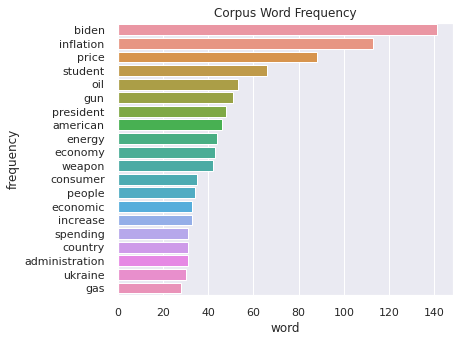

In [ ]:
sns.set(rc={"figure.figsize":(6, 5)})
sns.color_palette("mako", as_cmap=True)
sns.barplot(data=pd.DataFrame(new_list, columns =['value', 'key'])[0:20],x='value', y='key')

plt.ylabel('frequency')
plt.xlabel('word')
plt.title('Corpus Word Frequency')

In [ ]:
#Bigrams and Trigrams
#Added this, felt it was important. There are ways to build in custom bigrams
#but after review of text I don't think it would help to do so.

#search processed text for bigram phrases. Min count is number of pairings required
#to appear to become a bigram and threshold is number of bigrams. I found this to
#lead to decent results
bigram_phrases = Phrases(processed_text, min_count=4, threshold = 20)
#search processed text for bigram phrases that correlate with another word
#to form trigrams. There ended up being only a couple.
trigram_phrases = Phrases(bigram_phrases[processed_text], min_count=4, threshold = 20)


bigram = Phraser(bigram_phrases)
trigram = Phraser(trigram_phrases)

def make_bigrams(texts):
  return(bigram[doc] for doc in texts)

def make_trigrams(texts):
  return(trigram[bigram[doc]] for doc in texts)

#call functions and run on the processed text to make bigrams/ trigrams
#trigrams 
data_bigrams = make_bigrams(processed_text)
data_bigrams_trigrams = make_trigrams(data_bigrams)

data_gram = list(data_bigrams_trigrams)


In [ ]:
print(data_gram)

[['american_rescue', 'fueled', 'inflation', 'covid', 'shortage', 'march', 'democratic', 'included', 'payment', 'american', 'state', 'local', 'government', 'expanded', 'unemployment', 'benefit', 'among', 'thing', 'month', 'followed', 'inflation', 'taken', 'march', 'price', 'higher', 'month', 'earlier', 'filtering', 'energy', 'quickly', 'inflation', 'still', 'yearly', 'american_rescue', 'still', 'inflation', 'federal', 'target', 'goldwein', 'covid', 'inflation', 'story', 'complicated', 'federal', 'spending', 'force', 'including', 'change', 'labor_market', 'rising', 'global', 'energy', 'commodity', 'price', 'supply_chain', 'dysfunction', 'war_ukraine', 'contributed', 'higher', 'price', 'estimating', 'impact', 'american_rescue', 'magic', 'formula', 'reveal', 'precisely', 'american_rescue', 'fueled', 'inflation', 'general', 'consensus', 'contributor', 'economist', 'estimate', 'added', 'percentage_point', 'added', 'percentage_point', 'another', 'march', 'measure', 'accounted', 'something', '

In [ ]:
#TF-IDF remove common words with no value for topic classification

texts = data_gram

id2word = corpora.Dictionary(texts)


corpus = [id2word.doc2bow(text) for text in texts]
#print(corpus)

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words = []
words_missing_in_tfidf = []

for i in range(0, len(corpus)):
  bow = corpus[i]
  low_value_words = []
  tfidf_ids = [id for id, value in tfidf[bow]]
  bow_ids = [id for id, value in bow]
  low_value_words = [id for id, value in tfidf[bow] if value < low_value]
  drops = low_value_words+words_missing_in_tfidf
  for item in drops:
    words.append(id2word[item])
  words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]

  new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
  corpus[i] = new_bow


In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(
    corpus = corpus,
    id2word = id2word,
    num_topics = 20,
    random_state = 100,
    update_every = 1,
    chunksize=100,
    passes=10,
    alpha="auto"
)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word, mds="mmds", R=20)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.158869  0.206199       1        1  13.074426
17     0.054560 -0.279326       2        1  10.813488
6     -0.220796 -0.177116       3        1  10.348198
15    -0.132710  0.237158       4        1   9.649852
13     0.158287 -0.219875       5        1   7.212456
2      0.274712 -0.058739       6        1   7.157334
19     0.036281  0.271304       7        1   7.012518
18    -0.102603 -0.245674       8        1   6.732372
12    -0.300031  0.090395       9        1   5.964441
5      0.247666  0.118380      10        1   5.864984
4      0.190150  0.009559      11        1   3.944902
10    -0.010845  0.154360      12        1   3.654815
0     -0.199033 -0.040949      13        1   3.219317
9     -0.140515  0.076948      14        1   2.951138
11    -0.022660 -0.117563      15        1   2.347195
1      0.001664 -0.004788      16        1   0.010874
14     0.002140 -0.004937      17        1   0.010739
7      0.001337 -0.004895      18        1   0.010731
3      0.001685 -0.005180      19        1   0.010405
16     0.001843 -0.005262      20        1   0.009815, topic_info=                   Term       Freq      Total Category  logprob  loglift
70            inflation  81.000000  81.000000  Default  20.0000  20.0000
99                price  49.000000  49.000000  Default  19.0000  19.0000
83                  oil  24.000000  24.000000  Default  18.0000  18.0000
267                  us  16.000000  16.000000  Default  17.0000  17.0000
171            consumer  16.000000  16.000000  Default  16.0000  16.0000
...                 ...        ...        ...      ...      ...      ...
86             pandemic   0.000275  11.329799  Topic20  -7.6991  -1.3960
40              economy   0.000276  19.046031  Topic20  -7.6953  -1.9117
42               energy   0.000277  29.086302  Topic20  -7.6919  -2.3317
1597  military_spending   0.000273   7.369357  Topic20  -7.7082  -0.9750
66               impact   0.000274  12.600278  Topic20  -7.7043  -1.5075

[940 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1048      8  0.746741  acceptance
381       4  0.168825   according
381       5  0.168825   according
381       7  0.253238   according
381      10  0.253238   according
...     ...       ...         ...
495       6  0.199701        year
495       7  0.199701        year
495       9  0.299551        year
1125      8  0.690378  zaccarelli
1970      1  0.873509   zelenskyy

[1195 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 18, 7, 16, 14, 3, 20, 19, 13, 6, 5, 11, 1, 10, 12, 2, 15, 8, 4, 17])

In [ ]:
final_processed_text=[]
for i in processed_text:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    final_processed_text.append(temp_DSI)

**WordCloud**

<Figure size 1080x1080 with 0 Axes>

(-0.5, 2767.5, 1364.5, -0.5)

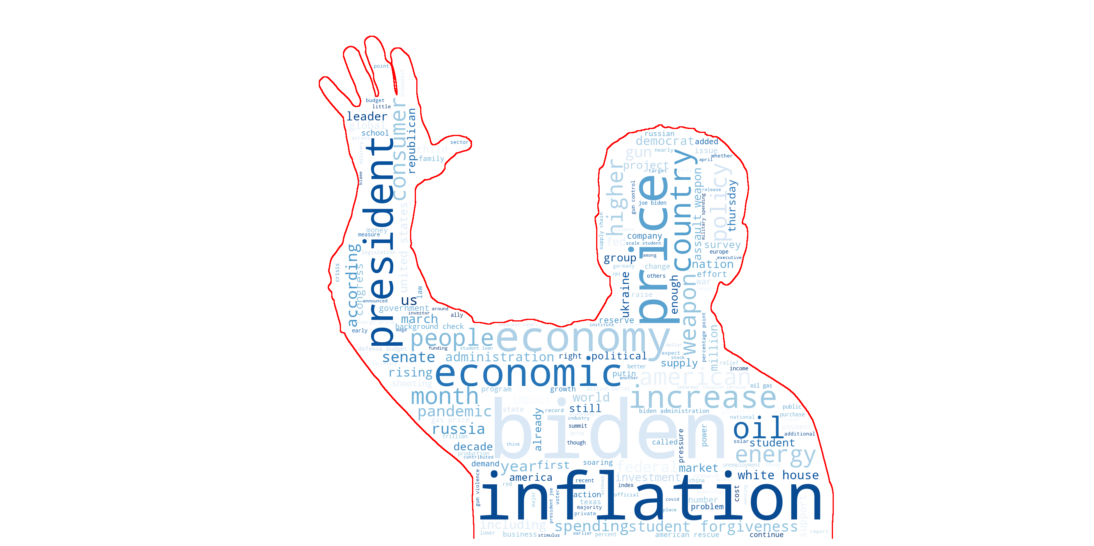

In [ ]:
#create wordcloud

cand_mask=np.array(Image.open(work_dir + 'photo_mask/biden.png'))

# this line will take all values greater than 3 and make them 255 (white)
# if they are less than 3, they will be whatever value they are in the array
cand_mask=np.where(cand_mask > 3, 255, cand_mask)

wordcloud_string = ''.join(final_processed_text)
#wordcloud = WordCloud(background_color="white",mask=cand_mask, width=3000, height=2000).generate(wordcloud_string)

#create and generate our wordcloud object
wordcloud = WordCloud(background_color='white',
                      contour_color='red',
                      mask=cand_mask, 
                      colormap='Blues',
                      contour_width=4).generate(wordcloud_string)

#if we want all words black instead of multicolored
# def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
#     return("hsl(0,100%, 1%)")

# wordcloud.recolor(color_func = black_color_func)

# plot wordcloud                     
plt.figure(figsize = (15, 15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

#below doesn't really work far as I can tell
#wordcloud.to_file(work_dir + "wordcloud.png")

**Sklearn TFIDF**

> ngram_range is used to include multiple words within the TFIDF matrix.For example an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (1, 3) means unigrams, bigrams & trigrams. Only applies if analyzer is not callable.




In [ ]:
#Call Tfidf Vectorizer
Tfidf=TfidfVectorizer(ngram_range=(1,3))

#fit the vectorizer using final processed documents.  The vectorizer requires the 
#stiched back together document.

TFIDF_matrix=Tfidf.fit_transform(final_processed_text)
# print(TFIDF_matrix.get_feature_names_out())
#creating datafram from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names_out(), index=titles)

In [ ]:
matrix.head()

abandon  abandon war  \
BAC_Doc1_Biden-Rescue-Plan.docx                  0.0          0.0   
BAC_Doc2_Biden-worsened -Inflation.docx          0.0          0.0   
CMP_Doc1_Consumer_Price_Index.docx               0.0          0.0   
CMP_Doc2_Voters_have_made.docx                   0.0          0.0   
DT_Doc1_Biden_Administration_Renewable.docx      0.0          0.0   

                                             abandon war though   ability  \
BAC_Doc1_Biden-Rescue-Plan.docx                             0.0  0.000000   
BAC_Doc2_Biden-worsened -Inflation.docx                     0.0  0.000000   
CMP_Doc1_Consumer_Price_Index.docx                          0.0  0.000000   
CMP_Doc2_Voters_have_made.docx                              0.0  0.000000   
DT_Doc1_Biden_Administration_Renewable.docx                 0.0  0.027369   

                                             ability carry  \
BAC_Doc1_Biden-Rescue-Plan.docx                        0.0   
BAC_Doc2_Biden-worsened -Inflation.docx                0.0   
CMP_Doc1_Consumer_Price_Index.docx                     0.0   
CMP_Doc2_Voters_have_made.docx                         0.0   
DT_Doc1_Biden_Administration_Renewable.docx            0.0   

                                             ability carry concealed  \
BAC_Doc1_Biden-Rescue-Plan.docx                                  0.0   
BAC_Doc2_Biden-worsened -Inflation.docx                          0.0   
CMP_Doc1_Consumer_Price_Index.docx                               0.0   
CMP_Doc2_Voters_have_made.docx                                   0.0   
DT_Doc1_Biden_Administration_Renewable.docx                      0.0   

                                             ability handle  \
BAC_Doc1_Biden-Rescue-Plan.docx                    0.000000   
BAC_Doc2_Biden-worsened -Inflation.docx            0.000000   
CMP_Doc1_Consumer_Price_Index.docx                 0.000000   
CMP_Doc2_Voters_have_made.docx                     0.000000   
DT_Doc1_Biden_Administration_Renewable.docx        0.033733   

                                             ability handle growing  \
BAC_Doc1_Biden-Rescue-Plan.docx                            0.000000   
BAC_Doc2_Biden-worsened -Inflation.docx                    0.000000   
CMP_Doc1_Consumer_Price_Index.docx                         0.000000   
CMP_Doc2_Voters_have_made.docx                             0.000000   
DT_Doc1_Biden_Administration_Renewable.docx                0.033733   

                                             ability produce  \
BAC_Doc1_Biden-Rescue-Plan.docx                          0.0   
BAC_Doc2_Biden-worsened -Inflation.docx                  0.0   
CMP_Doc1_Consumer_Price_Index.docx                       0.0   
CMP_Doc2_Voters_have_made.docx                           0.0   
DT_Doc1_Biden_Administration_Renewable.docx              0.0   

                                             ability produce oil  ...  \
BAC_Doc1_Biden-Rescue-Plan.docx                              0.0  ...   
BAC_Doc2_Biden-worsened -Inflation.docx                      0.0  ...   
CMP_Doc1_Consumer_Price_Index.docx                           0.0  ...   
CMP_Doc2_Voters_have_made.docx                               0.0  ...   
DT_Doc1_Biden_Administration_Renewable.docx                  0.0  ...   

                                             zeitlin economics  \
BAC_Doc1_Biden-Rescue-Plan.docx                       0.000000   
BAC_Doc2_Biden-worsened -Inflation.docx               0.000000   
CMP_Doc1_Consumer_Price_Index.docx                    0.040495   
CMP_Doc2_Voters_have_made.docx                        0.000000   
DT_Doc1_Biden_Administration_Renewable.docx           0.000000   

                                             zeitlin economics reporter  \
BAC_Doc1_Biden-Rescue-Plan.docx                                0.000000   
BAC_Doc2_Biden-worsened -Inflation.docx                        0.000000   
CMP_Doc1_Consumer_Price_Index.docx                             0.040495   
CMP_Doc2_Voters_have_made.docx    

# **Experiment 1**: 

> K-Means Clustering - TFIDF

> Experiment with different clusters





**Elblow Method**

[KMeans(max_iter=600, n_clusters=1),
 KMeans(max_iter=600, n_clusters=2),
 KMeans(max_iter=600, n_clusters=3),
 KMeans(max_iter=600, n_clusters=4),
 KMeans(max_iter=600, n_clusters=5),
 KMeans(max_iter=600, n_clusters=6),
 KMeans(max_iter=600, n_clusters=7),
 KMeans(max_iter=600),
 KMeans(max_iter=600, n_clusters=9),
 KMeans(max_iter=600, n_clusters=10),
 KMeans(max_iter=600, n_clusters=11)]

[-25.950750645582563,
 -24.528725026700776,
 -23.25977325059919,
 -22.092463501420152,
 -20.947690355119697,
 -19.68720487706537,
 -18.684051584143393,
 -17.62387951519118,
 -16.648093816509473,
 -15.617988505320762,
 -14.608452005309388]

Text(0.5, 0, 'Number of Clusters')

Text(0, 0.5, 'Score')

Text(0.5, 1.0, 'Elbow Method')

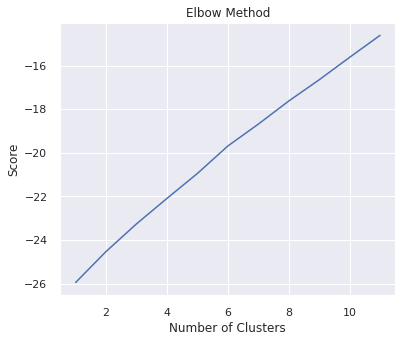

In [ ]:
number_clusters = range(1, 12)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(TFIDF_matrix).score(TFIDF_matrix) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

**Silhouette Score**

In [ ]:
def calculate_metrics(estimator, data):
    # Calculate and print metrics
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    print('Inertia: {}'.format(estimator.inertia_))
    print('Silhouette: {}'.format(metrics.silhouette_score(data, estimator.labels_)))

KMeans(n_clusters=2, random_state=89)

Number of Clusters: 2
Inertia: 24.673506173011024
Silhouette: 0.013379944986795749


KMeans(n_clusters=3, random_state=89)

Number of Clusters: 3
Inertia: 23.346588496253865
Silhouette: 0.01938499937402822


KMeans(n_clusters=4, random_state=89)

Number of Clusters: 4
Inertia: 22.060144808325102
Silhouette: 0.02540388439867458


KMeans(n_clusters=5, random_state=89)

Number of Clusters: 5
Inertia: 20.959506928522963
Silhouette: 0.0281397034085606


KMeans(n_clusters=6, random_state=89)

Number of Clusters: 6
Inertia: 19.81970344229911
Silhouette: 0.03080473522916941


KMeans(n_clusters=7, random_state=89)

Number of Clusters: 7
Inertia: 18.685287885563902
Silhouette: 0.036176973470347804


KMeans(random_state=89)

Number of Clusters: 8
Inertia: 17.650551634532306
Silhouette: 0.036071500527617574


KMeans(n_clusters=9, random_state=89)

Number of Clusters: 9
Inertia: 16.58490814602817
Silhouette: 0.04082948239668501


KMeans(n_clusters=10, random_state=89)

Number of Clusters: 10
Inertia: 15.60895561977204
Silhouette: 0.04106479095435629


'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca5c496f90>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=2, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca5934f8d0>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=3, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca59371110>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=4, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca5931d410>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=5, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca5933f9d0>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=6, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca592e3210>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=7, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca5928e550>,
                     colors='yellowbrick', estimator=KMeans(random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca592aeb10>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=9, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca5924dc50>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=10, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca59279250>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=11, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca59222d10>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=12, random_state=89))

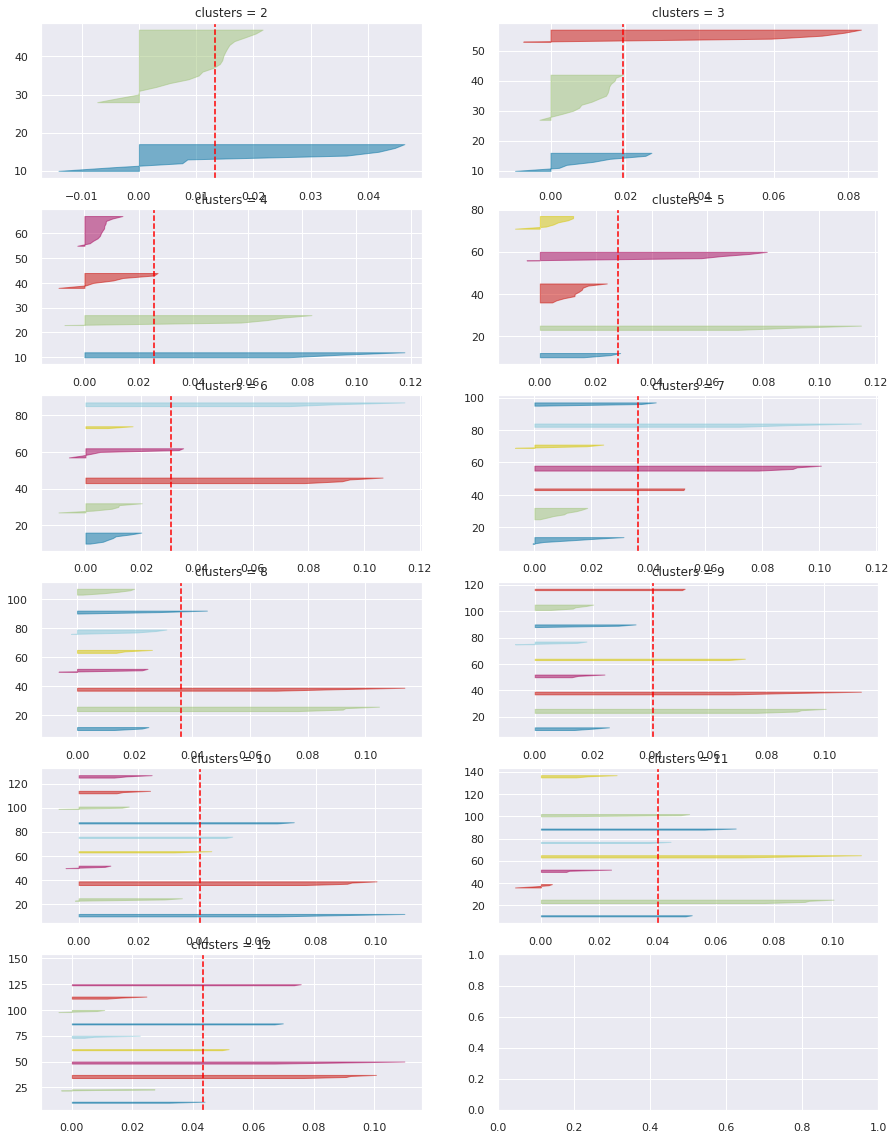

In [ ]:
clusters = [2,3, 4, 5, 6, 7, 8, 9, 10]

# test different numbers of clusters
for n_clusters in clusters:
    km = KMeans(n_clusters=n_clusters, random_state =89)
    km.fit(TFIDF_matrix)
    
    #print(km.labels_)
    # print cluster metrics
    calculate_metrics(km,TFIDF_matrix)

#Silhouette Visualizer for cluster

fig, ax = plt.subplots(6, 2, figsize=(15,20))
for i in range(2, 13):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, random_state =89)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    ax[q-1][mod].title.set_text(f'clusters = {i}')
    visualizer.fit(TFIDF_matrix)

**Cluster size 6**

In [ ]:
###############################################################################
### K Means Clustering - TFIDF
###############################################################################
k=6
km = KMeans(n_clusters=k, random_state =89)
km.fit(TFIDF_matrix)
clusters = km.labels_.tolist()


terms = Tfidf.get_feature_names()
Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]


#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

#dictionary to store terms and titles
cluster_terms={}
cluster_title={}


for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles

KMeans(n_clusters=6, random_state=89)

Top terms per cluster:
Cluster 0:


(None,)

 inflation
 price
 fed
 point
 consumer
 survey
 american rescue
 rescue
 american
 higher
Cluster 0 titles: BAC_Doc1_Biden-Rescue-Plan.docx, BAC_Doc2_Biden-worsened -Inflation.docx, CMP_Doc2_Voters_have_made.docx, JJ_Doc1_Consumers-Are-Feeling.docx, JJ_Doc2_Why_Is_Inflation.docx, Sieminski_Doc2_Recession.docx, Sieminski_Doc1_Inflation.docx,Cluster 1:


(None,)

 defense
 budget
 defense budget
 world
 project
 investment
 military
 russia
 sanction
 global
Cluster 1 titles: KN_Doc1_Biden-urges-G7.docx, MRD_Doc1_Civil-Society-Groups.docx, MRD_Doc2_Not-Even-Halfway.docx, PSJ_doc1_President_Biden_announced.docx, PSJ_doc2_The_worlds_wealthiest.docx, SS_Doc1_Mission_Not_Yet.docx,Cluster 2:


(None,)

 gun
 weapon
 assault
 shooting
 violence
 assault weapon
 uvalde
 texas
 background check
 background
Cluster 2 titles: JS_DOC_1_lives_will_be_saved.docx, JS_DOC_2_Biden_signs_gun_control.docx, TSS_Doc1_Biden-Gun-Control.docx, TSS_Doc2_Biden-Remarks-Gun-Violence.docx,Cluster 3:


(None,)

 oil
 price
 biden
 barrel
 reserve
 million barrel
 inflation
 energy
 russian
 supply
Cluster 3 titles: CMP_Doc1_Consumer_Price_Index.docx, MCD_Doc1_Biden-Oil-Reserve .docx, MCD_Doc2_More-Biden-Oil.docx, MCD_Doc3_Even-More-Biden-Oil.docx, SS_Doc1_job_growth_double-edged_sword.docx, SS_Doc2_A_New_Task.docx,Cluster 4:


(None,)

 solar
 renewable
 rfs
 energy
 tesla
 project
 administration
 vehicle
 electric
 policy
Cluster 4 titles: DT_Doc1_Biden_Administration_Renewable.docx, DT_Doc2_Biden_More_Rewable.docx,Cluster 5:


(None,)

 student
 forgiveness
 student forgiveness
 borrower
 inflation
 biden
 relief
 payment
 loan
 cancellation
Cluster 5 titles: JAS_D0c1_Student_Loan_Forgiveness.docx, JAS_Doc2_Inflation-complicates_Biden.docx, SS_Doc2_inflation_impacts_Student-Loan-Forgiveness.docx,

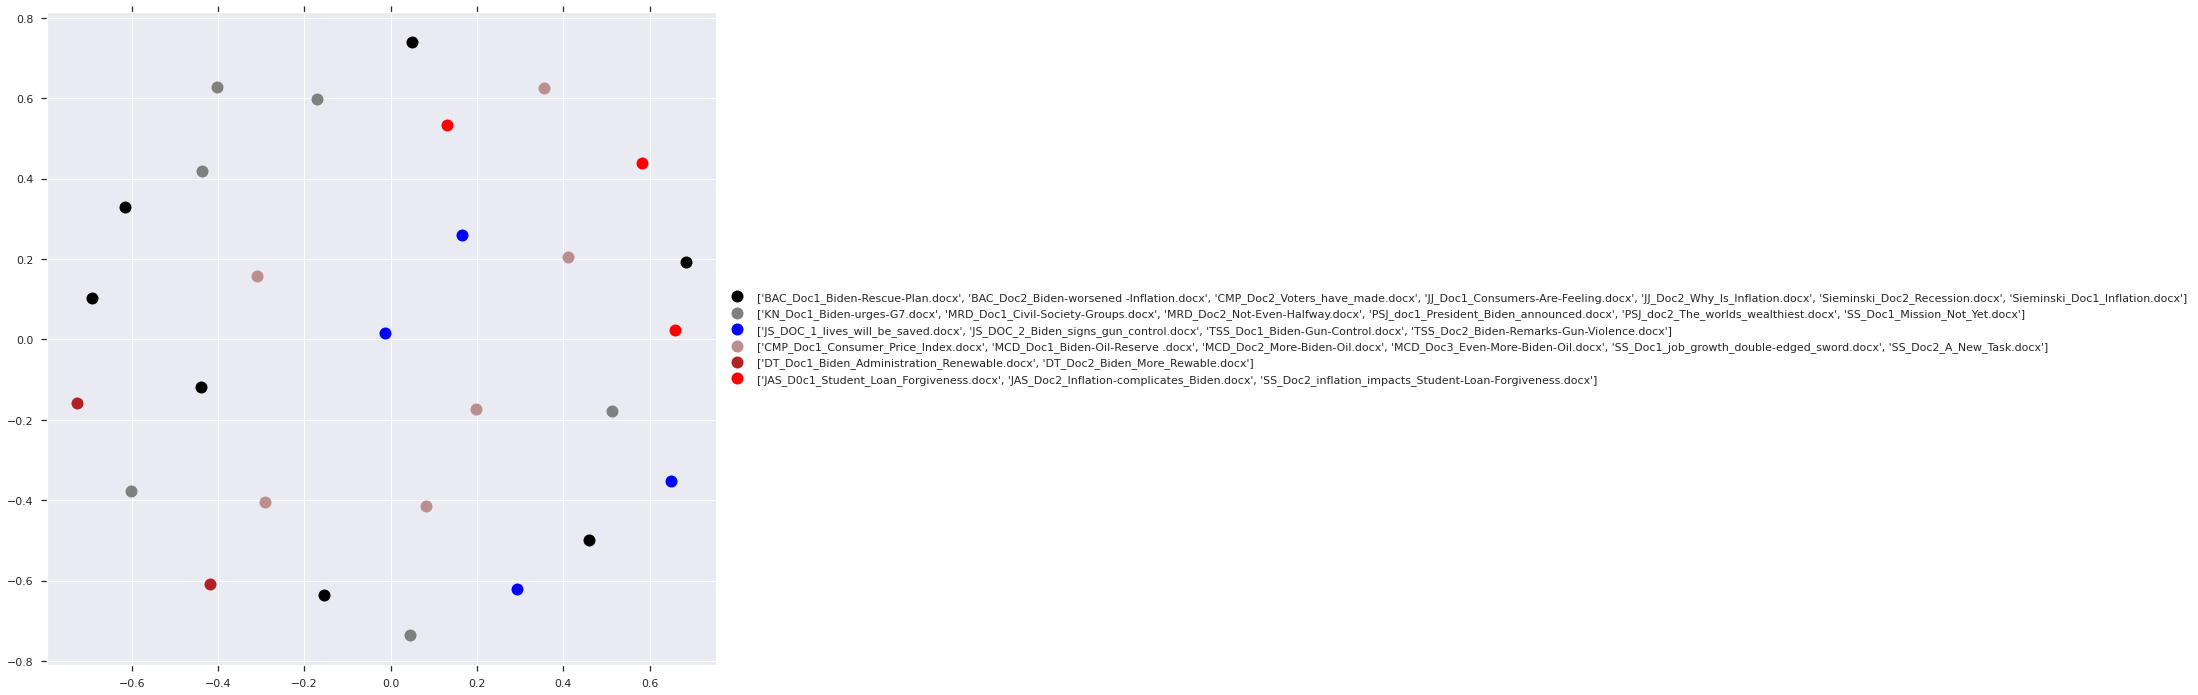

In [ ]:
###############################################################################
### Plotting
###############################################################################

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.

X=TFIDF_matrix
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(X)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                  5:'red', 6:'darksalmon', 7:'sienna', 8:'green'}


#set up cluster names using a dict.  
cluster_dict=cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

**Review Clusters**





In [ ]:
term_clusters = pd.DataFrame.from_dict(cluster_terms) #pull out terms into a dataframe
terms = term_clusters.stack() #stack terms names into 1 column
terms = terms.reset_index() #move index into a column
terms = terms.rename(columns={'level_1': 'cluster_term', 0:'term'}) #rename columns
terms = terms.drop(['level_0'], axis=1) #drop unecessary column
terms.head()

cluster_term       term
0             0  inflation
1             1    defense
2             2        gun
3             3        oil
4             4      solar

In [ ]:
# look at frequent terms across clusters
term_clusters

0               1                 2               3  \
0        inflation         defense               gun             oil   
1            price          budget            weapon           price   
2              fed  defense budget           assault           biden   
3            point           world          shooting          barrel   
4         consumer         project          violence         reserve   
5           survey      investment    assault weapon  million barrel   
6  american rescue        military            uvalde       inflation   
7           rescue          russia             texas          energy   
8         american        sanction  background check         russian   
9           higher          global        background          supply   

                4                    5  
0           solar              student  
1       renewable          forgiveness  
2             rfs  student forgiveness  
3          energy             borrower  
4           tesla            inflation  
5         project                biden  
6  administration               relief  
7         vehicle              payment  
8        electric                 loan  
9          policy         cancellation

In [ ]:
Clusters = pd.DataFrame.from_dict(cluster_title, orient='index') #convert tiles to a dataframe
Clusters = Clusters.stack() #stack document names into 1 column
Clusters = Clusters.reset_index() #move index into a column
Clusters = Clusters.rename(columns={'level_0': 'cluster_doc', 0:'document'}) #rename columns
Clusters = Clusters.drop(['level_1'], axis=1) #drop unecessary column
Clusters.value_counts(sort=False)

cluster_doc  document                                               
0            BAC_Doc1_Biden-Rescue-Plan.docx                            1
             BAC_Doc2_Biden-worsened -Inflation.docx                    1
             CMP_Doc2_Voters_have_made.docx                             1
             JJ_Doc1_Consumers-Are-Feeling.docx                         1
             JJ_Doc2_Why_Is_Inflation.docx                              1
             Sieminski_Doc1_Inflation.docx                              1
             Sieminski_Doc2_Recession.docx                              1
1            KN_Doc1_Biden-urges-G7.docx                                1
             MRD_Doc1_Civil-Society-Groups.docx                         1
             MRD_Doc2_Not-Even-Halfway.docx                             1
             PSJ_doc1_President_Biden_announced.docx                    1
             PSJ_doc2_The_worlds_wealthiest.docx                        1
             SS_Doc1_Mission_Not_Yet.docx  

**Cluster size 7**

In [ ]:
###############################################################################
### K Means Clustering - TFIDF
###############################################################################
k=7
km = KMeans(n_clusters=k, random_state =89)
km.fit(TFIDF_matrix)
clusters = km.labels_.tolist()


terms = Tfidf.get_feature_names()
Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]


#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

#dictionary to store terms and titles
cluster_terms={}
cluster_title={}


for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles

KMeans(n_clusters=7, random_state=89)

Top terms per cluster:
Cluster 0:


(None,)

 leader
 russian
 world
 global
 russia
 sanction
 biden
 infrastructure
 investment
 project
Cluster 0 titles: KN_Doc1_Biden-urges-G7.docx, PSJ_doc1_President_Biden_announced.docx, PSJ_doc2_The_worlds_wealthiest.docx, SS_Doc1_Mission_Not_Yet.docx, SS_Doc2_A_New_Task.docx,Cluster 1:


(None,)

 inflation
 price
 fed
 consumer
 point
 american
 survey
 rescue
 american rescue
 higher
Cluster 1 titles: BAC_Doc1_Biden-Rescue-Plan.docx, BAC_Doc2_Biden-worsened -Inflation.docx, CMP_Doc2_Voters_have_made.docx, JJ_Doc1_Consumers-Are-Feeling.docx, JJ_Doc2_Why_Is_Inflation.docx, SS_Doc1_job_growth_double-edged_sword.docx, Sieminski_Doc2_Recession.docx, Sieminski_Doc1_Inflation.docx,Cluster 2:


(None,)

 budget
 defense
 defense budget
 military
 military spending
 pentagon
 senate
 fiscal
 spending
 us
Cluster 2 titles: MRD_Doc1_Civil-Society-Groups.docx, MRD_Doc2_Not-Even-Halfway.docx,Cluster 3:


(None,)

 gun
 weapon
 assault
 shooting
 violence
 assault weapon
 uvalde
 texas
 background check
 background
Cluster 3 titles: JS_DOC_1_lives_will_be_saved.docx, JS_DOC_2_Biden_signs_gun_control.docx, TSS_Doc1_Biden-Gun-Control.docx, TSS_Doc2_Biden-Remarks-Gun-Violence.docx,Cluster 4:


(None,)

 energy
 oil
 administration
 renewable
 solar
 rfs
 production
 federal
 tesla
 gas
Cluster 4 titles: DT_Doc1_Biden_Administration_Renewable.docx, DT_Doc2_Biden_More_Rewable.docx, MCD_Doc3_Even-More-Biden-Oil.docx,Cluster 5:


(None,)

 student
 forgiveness
 student forgiveness
 borrower
 inflation
 biden
 relief
 payment
 loan
 cancellation
Cluster 5 titles: JAS_D0c1_Student_Loan_Forgiveness.docx, JAS_Doc2_Inflation-complicates_Biden.docx, SS_Doc2_inflation_impacts_Student-Loan-Forgiveness.docx,Cluster 6:


(None,)

 price
 oil
 barrel
 reserve
 million barrel
 cpi
 gas price
 march
 million
 release
Cluster 6 titles: CMP_Doc1_Consumer_Price_Index.docx, MCD_Doc1_Biden-Oil-Reserve .docx, MCD_Doc2_More-Biden-Oil.docx,

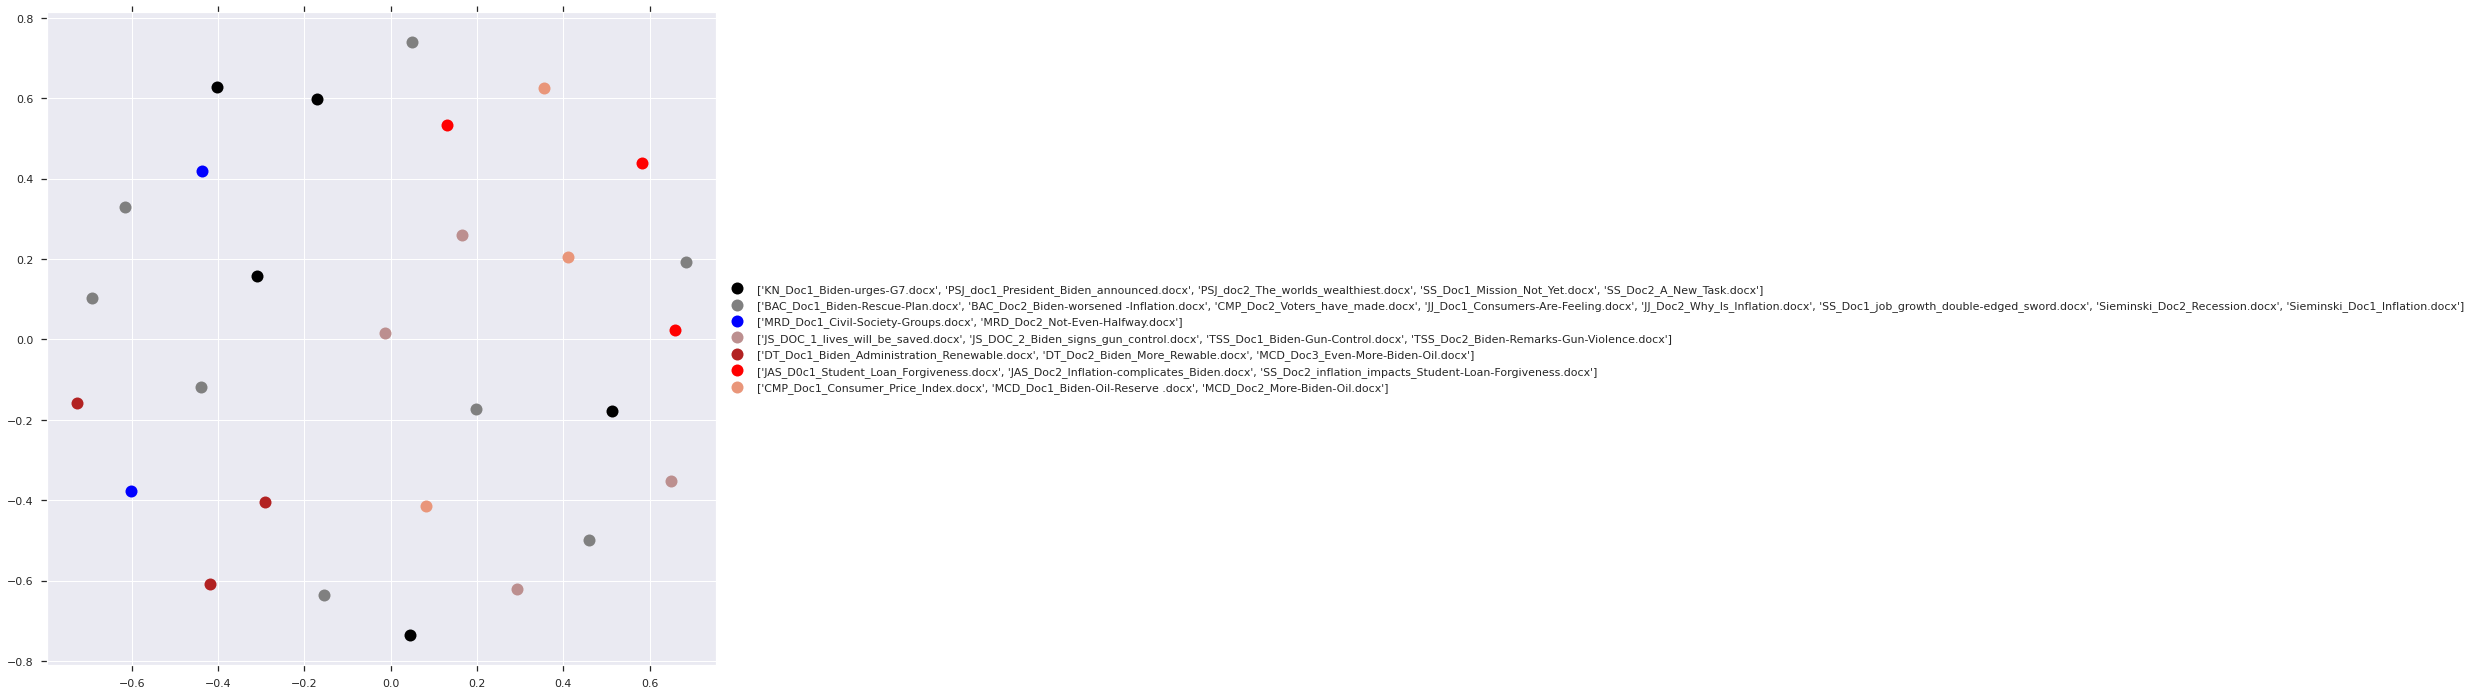

In [ ]:
###############################################################################
### Plotting
###############################################################################

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.

X=TFIDF_matrix
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(X)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                  5:'red', 6:'darksalmon', 7:'sienna', 8:'green'}


#set up cluster names using a dict.  
cluster_dict=cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

**Review Clusters**

In [ ]:
term_clusters = pd.DataFrame.from_dict(cluster_terms) #pull out terms into a dataframe
terms = term_clusters.stack() #stack terms names into 1 column
terms = terms.reset_index() #move index into a column
terms = terms.rename(columns={'level_1': 'cluster_term', 0:'term'}) #rename columns
terms = terms.drop(['level_0'], axis=1) #drop unecessary column
terms.head()
term_clusters

cluster_term       term
0             0     leader
1             1  inflation
2             2     budget
3             3        gun
4             4     energy

0                1                  2                 3  \
0          leader        inflation             budget               gun   
1         russian            price            defense            weapon   
2           world              fed     defense budget           assault   
3          global         consumer           military          shooting   
4          russia            point  military spending          violence   
5        sanction         american           pentagon    assault weapon   
6           biden           survey             senate            uvalde   
7  infrastructure           rescue             fiscal             texas   
8      investment  american rescue           spending  background check   
9         project           higher                 us        background   

                4                    5               6  
0          energy              student           price  
1             oil          forgiveness             oil  
2  administration  student forgiveness          barrel  
3       renewable             borrower         reserve  
4           solar            inflation  million barrel  
5             rfs                biden             cpi  
6      production               relief       gas price  
7         federal              payment           march  
8           tesla                 loan         million  
9             gas         cancellation         release

In [ ]:
Clusters = pd.DataFrame.from_dict(cluster_title, orient='index') #convert tiles to a dataframe
Clusters = Clusters.stack() #stack document names into 1 column
Clusters = Clusters.reset_index() #move index into a column
Clusters = Clusters.rename(columns={'level_0': 'cluster_doc', 0:'document'}) #rename columns
Clusters = Clusters.drop(['level_1'], axis=1) #drop unecessary column
Clusters.value_counts(sort=False)

cluster_doc  document                                               
0            KN_Doc1_Biden-urges-G7.docx                                1
             PSJ_doc1_President_Biden_announced.docx                    1
             PSJ_doc2_The_worlds_wealthiest.docx                        1
             SS_Doc1_Mission_Not_Yet.docx                               1
             SS_Doc2_A_New_Task.docx                                    1
1            BAC_Doc1_Biden-Rescue-Plan.docx                            1
             BAC_Doc2_Biden-worsened -Inflation.docx                    1
             CMP_Doc2_Voters_have_made.docx                             1
             JJ_Doc1_Consumers-Are-Feeling.docx                         1
             JJ_Doc2_Why_Is_Inflation.docx                              1
             SS_Doc1_job_growth_double-edged_sword.docx                 1
             Sieminski_Doc1_Inflation.docx                              1
             Sieminski_Doc2_Recession.docx 

In [ ]:
term_list = terms['term'].values.tolist() #pull all terms into a list
matrix_clustering = matrix[term_list] #pull out only terms in clusters
full_titles = Clusters.set_index('document').join(matrix_clustering, how='left') # join in tf-idf values
full_titles.shape

(28, 71)

In [ ]:
# calculate average tf-idf values for each cluster of terms
for i in range (k):
    full_titles[i] = full_titles[term_clusters[i].values.tolist()].mean(axis=1)

In [ ]:
# remove all other columsn leaving only the average 
full_titles = full_titles.set_index('cluster_doc', append=True)
full_titles_final = full_titles[full_titles.columns[-k:]]

<Figure size 360x1800 with 0 Axes>

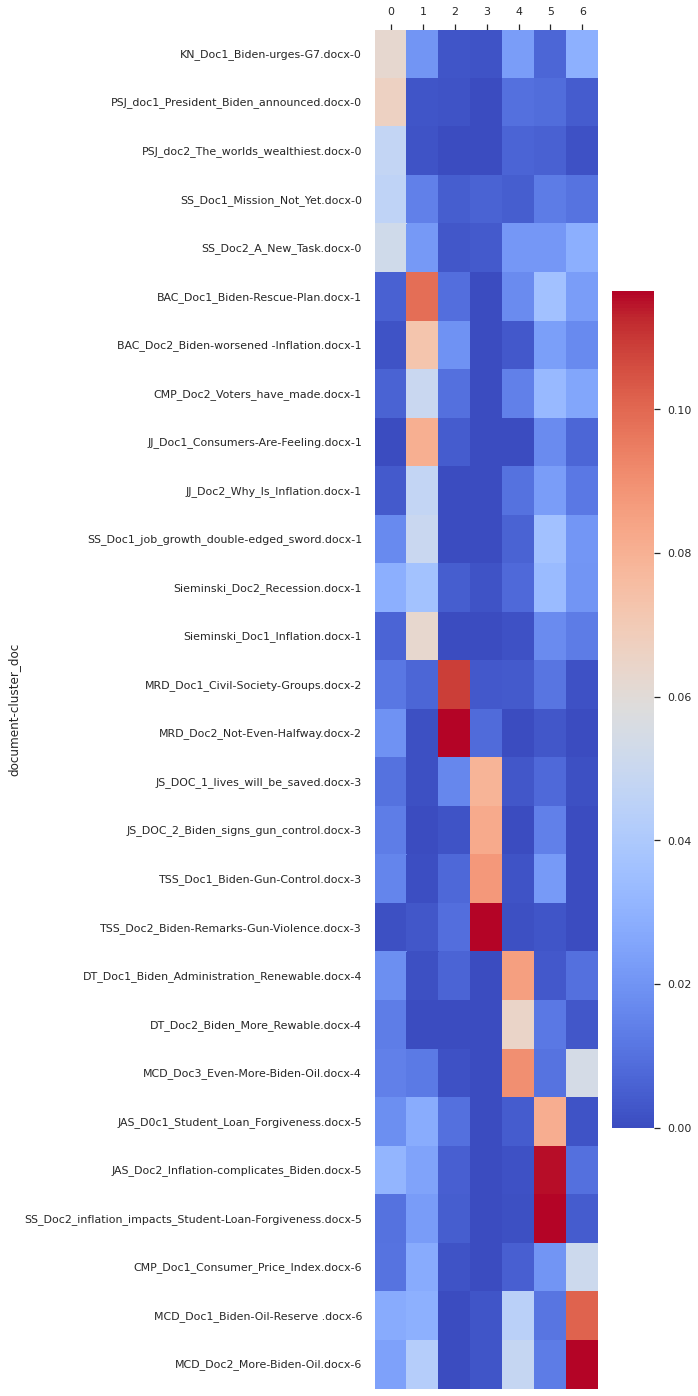

In [ ]:
plt.figure(figsize=(5,25))
plt.rcParams['font.size'] = 10
p=sns.heatmap(full_titles_final, cmap='coolwarm', robust=True)
p.xaxis.tick_top()
p.xaxis.set_label_position('top')

**Cluster size 8**

In [ ]:
###############################################################################
### K Means Clustering - TFIDF 
###############################################################################
k=8
km = KMeans(n_clusters=k, random_state =89)
km.fit(TFIDF_matrix)
clusters = km.labels_.tolist()


terms = Tfidf.get_feature_names()
Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]


#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

#dictionary to store terms and titles
cluster_terms={}
cluster_title={}


for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles

KMeans(random_state=89)

Top terms per cluster:
Cluster 0:


(None,)

 fed
 inflation
 consumer
 survey
 point
 rate
 interest rate
 market
 interest
 price
Cluster 0 titles: JJ_Doc1_Consumers-Are-Feeling.docx, JJ_Doc2_Why_Is_Inflation.docx, Sieminski_Doc1_Inflation.docx,Cluster 1:


(None,)

 gun
 weapon
 assault
 shooting
 violence
 assault weapon
 uvalde
 texas
 background check
 background
Cluster 1 titles: JS_DOC_1_lives_will_be_saved.docx, JS_DOC_2_Biden_signs_gun_control.docx, TSS_Doc1_Biden-Gun-Control.docx, TSS_Doc2_Biden-Remarks-Gun-Violence.docx,Cluster 2:


(None,)

 student
 forgiveness
 student forgiveness
 borrower
 inflation
 biden
 relief
 payment
 loan
 cancellation
Cluster 2 titles: JAS_D0c1_Student_Loan_Forgiveness.docx, JAS_Doc2_Inflation-complicates_Biden.docx, SS_Doc2_inflation_impacts_Student-Loan-Forgiveness.docx,Cluster 3:


(None,)

 budget
 defense
 defense budget
 military
 military spending
 rfs
 pentagon
 tesla
 senate
 fiscal
Cluster 3 titles: DT_Doc2_Biden_More_Rewable.docx, MRD_Doc1_Civil-Society-Groups.docx, MRD_Doc2_Not-Even-Halfway.docx,Cluster 4:


(None,)

 russian
 leader
 russia
 sanction
 price
 ukraine
 war
 global
 putin
 biden
Cluster 4 titles: KN_Doc1_Biden-urges-G7.docx, SS_Doc1_Mission_Not_Yet.docx, SS_Doc2_A_New_Task.docx,Cluster 5:


(None,)

 oil
 price
 barrel
 reserve
 million barrel
 biden
 energy
 million
 release
 production
Cluster 5 titles: MCD_Doc1_Biden-Oil-Reserve .docx, MCD_Doc2_More-Biden-Oil.docx, MCD_Doc3_Even-More-Biden-Oil.docx, Sieminski_Doc2_Recession.docx,Cluster 6:


(None,)

 project
 solar
 world
 energy
 investment
 infrastructure
 africa
 offering
 developing
 developing world
Cluster 6 titles: DT_Doc1_Biden_Administration_Renewable.docx, PSJ_doc1_President_Biden_announced.docx, PSJ_doc2_The_worlds_wealthiest.docx,Cluster 7:


(None,)

 inflation
 price
 rescue
 american rescue
 march
 american
 job
 spending
 cpi
 problem
Cluster 7 titles: BAC_Doc1_Biden-Rescue-Plan.docx, BAC_Doc2_Biden-worsened -Inflation.docx, CMP_Doc1_Consumer_Price_Index.docx, CMP_Doc2_Voters_have_made.docx, SS_Doc1_job_growth_double-edged_sword.docx,

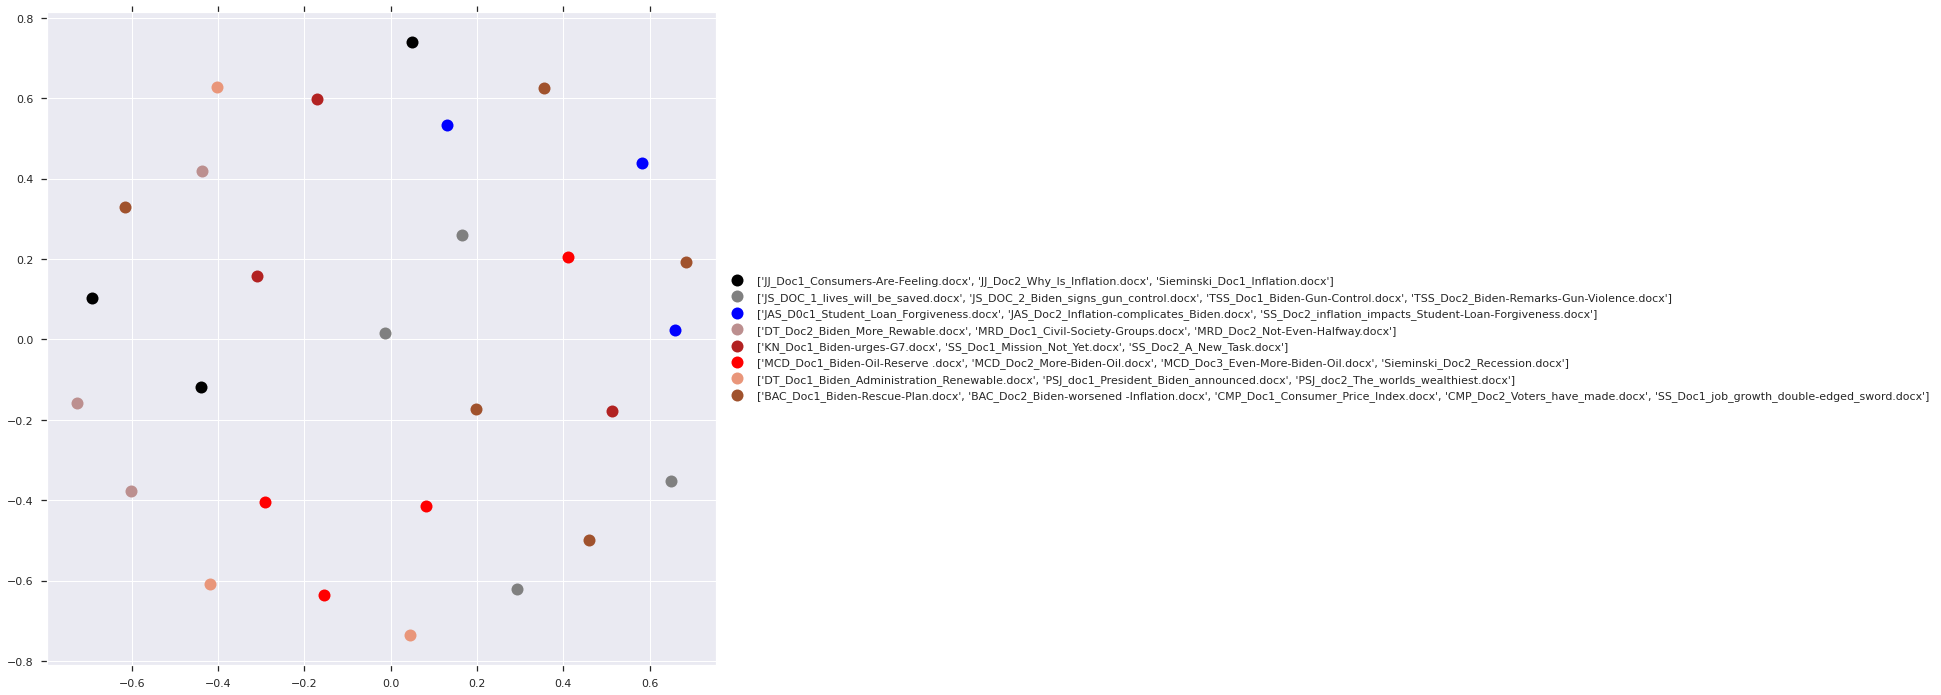

In [ ]:
###############################################################################
### Plotting
###############################################################################

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.

X=TFIDF_matrix
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(X)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                  5:'red', 6:'darksalmon', 7:'sienna', 8:'green'}


#set up cluster names using a dict.  
cluster_dict=cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

**Review Clusters**

In [ ]:
term_clusters = pd.DataFrame.from_dict(cluster_terms) #pull out terms into a dataframe
terms = term_clusters.stack() #stack terms names into 1 column
terms = terms.reset_index() #move index into a column
terms = terms.rename(columns={'level_1': 'cluster_term', 0:'term'}) #rename columns
terms = terms.drop(['level_0'], axis=1) #drop unecessary column
terms.head()
term_clusters

cluster_term     term
0             0      fed
1             1      gun
2             2  student
3             3   budget
4             4  russian

0                 1                    2                  3  \
0            fed               gun              student             budget   
1      inflation            weapon          forgiveness            defense   
2       consumer           assault  student forgiveness     defense budget   
3         survey          shooting             borrower           military   
4          point          violence            inflation  military spending   
5           rate    assault weapon                biden                rfs   
6  interest rate            uvalde               relief           pentagon   
7         market             texas              payment              tesla   
8       interest  background check                 loan             senate   
9          price        background         cancellation             fiscal   

          4               5                 6                7  
0   russian             oil           project        inflation  
1    leader           price             solar            price  
2    russia          barrel             world           rescue  
3  sanction         reserve            energy  american rescue  
4     price  million barrel        investment            march  
5   ukraine           biden    infrastructure         american  
6       war          energy            africa              job  
7    global         million          offering         spending  
8     putin         release        developing              cpi  
9     biden      production  developing world          problem

In [ ]:
Clusters = pd.DataFrame.from_dict(cluster_title, orient='index') #convert tiles to a dataframe
Clusters = Clusters.stack() #stack document names into 1 column
Clusters = Clusters.reset_index() #move index into a column
Clusters = Clusters.rename(columns={'level_0': 'cluster_doc', 0:'document'}) #rename columns
Clusters = Clusters.drop(['level_1'], axis=1) #drop unecessary column
Clusters.value_counts(sort=False)

cluster_doc  document                                               
0            JJ_Doc1_Consumers-Are-Feeling.docx                         1
             JJ_Doc2_Why_Is_Inflation.docx                              1
             Sieminski_Doc1_Inflation.docx                              1
1            JS_DOC_1_lives_will_be_saved.docx                          1
             JS_DOC_2_Biden_signs_gun_control.docx                      1
             TSS_Doc1_Biden-Gun-Control.docx                            1
             TSS_Doc2_Biden-Remarks-Gun-Violence.docx                   1
2            JAS_D0c1_Student_Loan_Forgiveness.docx                     1
             JAS_Doc2_Inflation-complicates_Biden.docx                  1
             SS_Doc2_inflation_impacts_Student-Loan-Forgiveness.docx    1
3            DT_Doc2_Biden_More_Rewable.docx                            1
             MRD_Doc1_Civil-Society-Groups.docx                         1
             MRD_Doc2_Not-Even-Halfway.docx

In [ ]:
term_list = terms['term'].values.tolist() #pull all terms into a list
matrix_clustering = matrix[term_list] #pull out only terms in clusters
full_titles = Clusters.set_index('document').join(matrix_clustering, how='left') # join in tf-idf values
full_titles.shape

(28, 81)

In [ ]:
# calculate average tf-idf values for each cluster of terms
for i in range (k):
    full_titles[i] = full_titles[term_clusters[i].values.tolist()].mean(axis=1)

In [ ]:
# remove all other columsn leaving only the average 
full_titles = full_titles.set_index('cluster_doc', append=True)
full_titles_final = full_titles[full_titles.columns[-k:]]

<Figure size 360x1800 with 0 Axes>

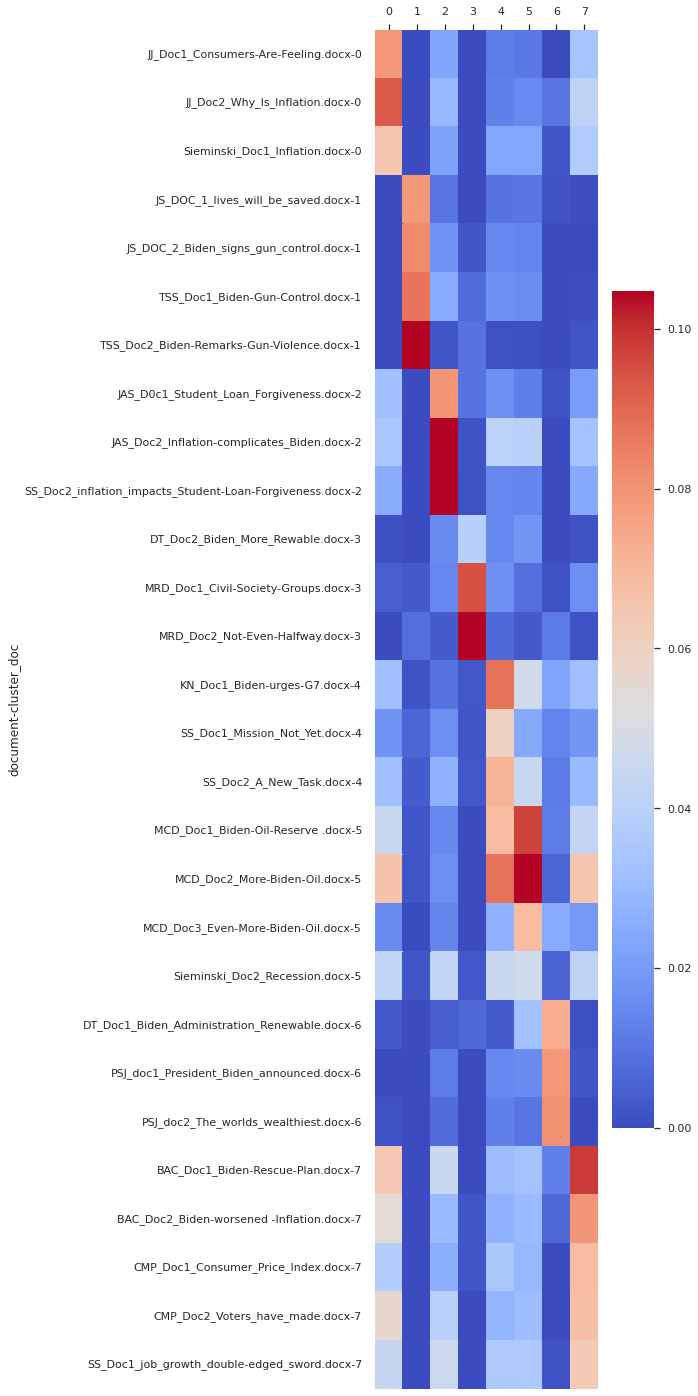

In [ ]:
plt.figure(figsize=(5,25))
plt.rcParams['font.size'] = 10
p=sns.heatmap(full_titles_final, cmap='coolwarm', robust=True)
p.xaxis.tick_top()
p.xaxis.set_label_position('top')

**Cluster size 9**

In [ ]:
###############################################################################
### K Means Clustering - TFIDF 
###############################################################################
k=9
km = KMeans(n_clusters=k, random_state =89)
km.fit(TFIDF_matrix)
clusters = km.labels_.tolist()


terms = Tfidf.get_feature_names()
Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]


#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

#dictionary to store terms and titles
cluster_terms={}
cluster_title={}


for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles

KMeans(n_clusters=9, random_state=89)

Top terms per cluster:
Cluster 0:


(None,)

 fed
 inflation
 consumer
 survey
 point
 rate
 interest rate
 market
 interest
 price
Cluster 0 titles: JJ_Doc1_Consumers-Are-Feeling.docx, JJ_Doc2_Why_Is_Inflation.docx, Sieminski_Doc1_Inflation.docx,Cluster 1:


(None,)

 gun
 weapon
 assault
 shooting
 violence
 assault weapon
 uvalde
 texas
 background check
 background
Cluster 1 titles: JS_DOC_1_lives_will_be_saved.docx, JS_DOC_2_Biden_signs_gun_control.docx, TSS_Doc1_Biden-Gun-Control.docx, TSS_Doc2_Biden-Remarks-Gun-Violence.docx,Cluster 2:


(None,)

 student
 forgiveness
 student forgiveness
 borrower
 inflation
 biden
 relief
 payment
 loan
 cancellation
Cluster 2 titles: JAS_D0c1_Student_Loan_Forgiveness.docx, JAS_Doc2_Inflation-complicates_Biden.docx, SS_Doc2_inflation_impacts_Student-Loan-Forgiveness.docx,Cluster 3:


(None,)

 russian
 leader
 russia
 sanction
 price
 ukraine
 war
 global
 putin
 biden
Cluster 3 titles: KN_Doc1_Biden-urges-G7.docx, SS_Doc1_Mission_Not_Yet.docx, SS_Doc2_A_New_Task.docx,Cluster 4:


(None,)

 world
 project
 investment
 infrastructure
 africa
 offering
 developing
 developing world
 democracy
 sunday
Cluster 4 titles: PSJ_doc1_President_Biden_announced.docx, PSJ_doc2_The_worlds_wealthiest.docx,Cluster 5:


(None,)

 energy
 oil
 administration
 renewable
 solar
 rfs
 production
 federal
 tesla
 gas
Cluster 5 titles: DT_Doc1_Biden_Administration_Renewable.docx, DT_Doc2_Biden_More_Rewable.docx, MCD_Doc3_Even-More-Biden-Oil.docx,Cluster 6:


(None,)

 price
 oil
 barrel
 reserve
 million barrel
 cpi
 gas price
 march
 million
 release
Cluster 6 titles: CMP_Doc1_Consumer_Price_Index.docx, MCD_Doc1_Biden-Oil-Reserve .docx, MCD_Doc2_More-Biden-Oil.docx,Cluster 7:


(None,)

 inflation
 price
 rescue
 american rescue
 american
 job
 biden
 spending
 economist
 unemployment
Cluster 7 titles: BAC_Doc1_Biden-Rescue-Plan.docx, BAC_Doc2_Biden-worsened -Inflation.docx, CMP_Doc2_Voters_have_made.docx, SS_Doc1_job_growth_double-edged_sword.docx, Sieminski_Doc2_Recession.docx,Cluster 8:


(None,)

 budget
 defense
 defense budget
 military
 military spending
 pentagon
 senate
 fiscal
 spending
 us
Cluster 8 titles: MRD_Doc1_Civil-Society-Groups.docx, MRD_Doc2_Not-Even-Halfway.docx,

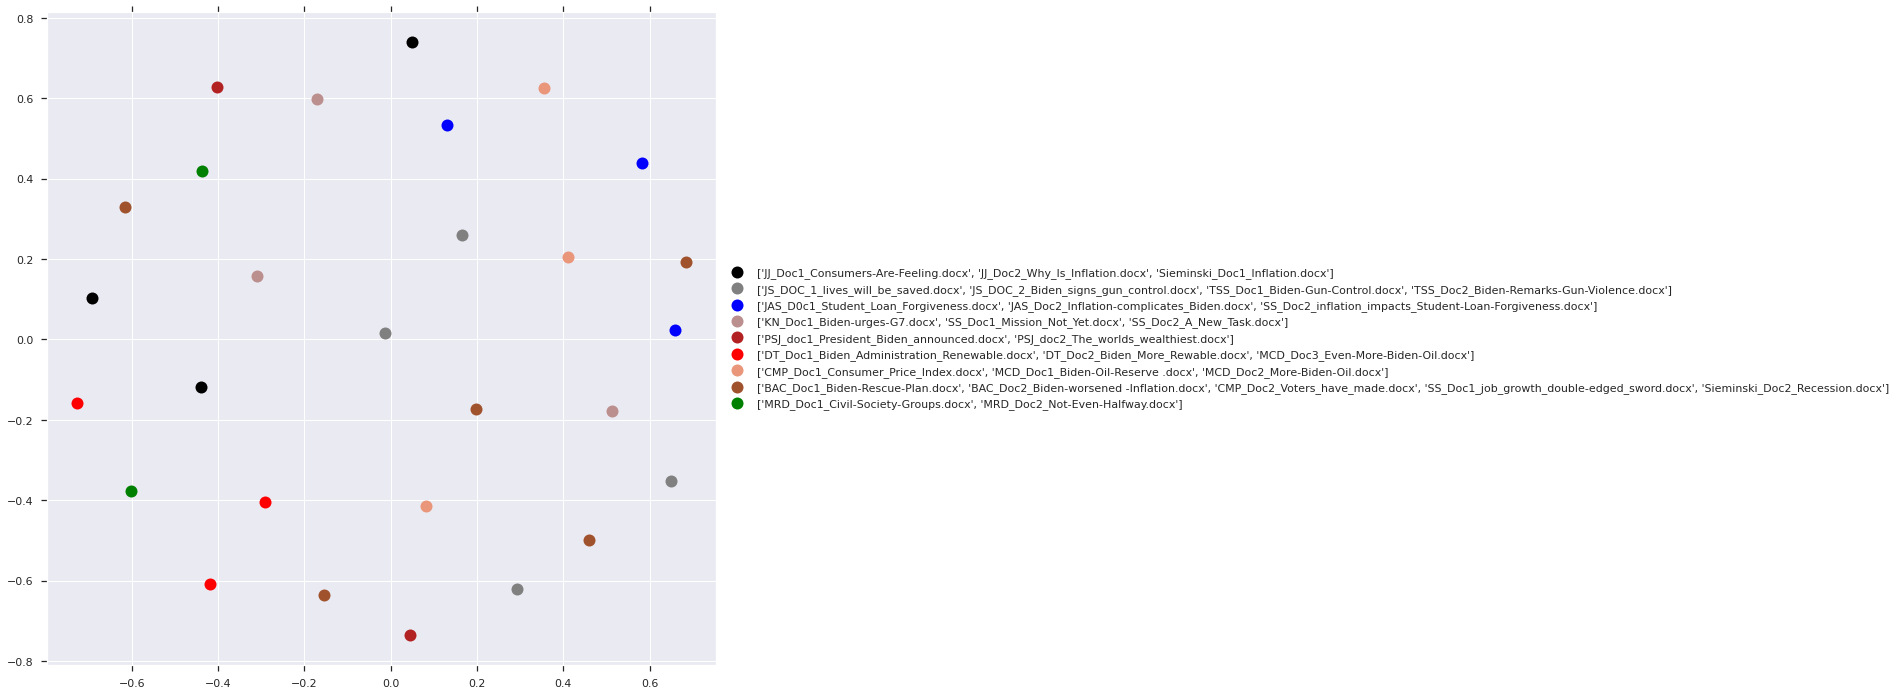

In [ ]:
###############################################################################
### Plotting
###############################################################################

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.

X=TFIDF_matrix
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(X)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                  5:'red', 6:'darksalmon', 7:'sienna', 8:'green'}


#set up cluster names using a dict.  
cluster_dict=cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

**Review Clusters**

In [ ]:
term_clusters = pd.DataFrame.from_dict(cluster_terms) #pull out terms into a dataframe
terms = term_clusters.stack() #stack terms names into 1 column
terms = terms.reset_index() #move index into a column
terms = terms.rename(columns={'level_1': 'cluster_term', 0:'term'}) #rename columns
terms = terms.drop(['level_0'], axis=1) #drop unecessary column
terms.head()
term_clusters

cluster_term     term
0             0      fed
1             1      gun
2             2  student
3             3  russian
4             4    world

0                 1                    2         3  \
0            fed               gun              student   russian   
1      inflation            weapon          forgiveness    leader   
2       consumer           assault  student forgiveness    russia   
3         survey          shooting             borrower  sanction   
4          point          violence            inflation     price   
5           rate    assault weapon                biden   ukraine   
6  interest rate            uvalde               relief       war   
7         market             texas              payment    global   
8       interest  background check                 loan     putin   
9          price        background         cancellation     biden   

                  4               5               6                7  \
0             world          energy           price        inflation   
1           project             oil             oil            price   
2        investment  administration          barrel           rescue   
3    infrastructure       renewable         reserve  american rescue   
4            africa           solar  million barrel         american   
5          offering             rfs             cpi              job   
6        developing      production       gas price            biden   
7  developing world         federal           march         spending   
8         democracy           tesla         million        economist   
9            sunday             gas         release     unemployment   

                   8  
0             budget  
1            defense  
2     defense budget  
3           military  
4  military spending  
5           pentagon  
6             senate  
7             fiscal  
8           spending  
9                 us

In [ ]:
Clusters = pd.DataFrame.from_dict(cluster_title, orient='index') #convert tiles to a dataframe
Clusters = Clusters.stack() #stack document names into 1 column
Clusters = Clusters.reset_index() #move index into a column
Clusters = Clusters.rename(columns={'level_0': 'cluster_doc', 0:'document'}) #rename columns
Clusters = Clusters.drop(['level_1'], axis=1) #drop unecessary column
Clusters.value_counts(sort=False)

cluster_doc  document                                               
0            JJ_Doc1_Consumers-Are-Feeling.docx                         1
             JJ_Doc2_Why_Is_Inflation.docx                              1
             Sieminski_Doc1_Inflation.docx                              1
1            JS_DOC_1_lives_will_be_saved.docx                          1
             JS_DOC_2_Biden_signs_gun_control.docx                      1
             TSS_Doc1_Biden-Gun-Control.docx                            1
             TSS_Doc2_Biden-Remarks-Gun-Violence.docx                   1
2            JAS_D0c1_Student_Loan_Forgiveness.docx                     1
             JAS_Doc2_Inflation-complicates_Biden.docx                  1
             SS_Doc2_inflation_impacts_Student-Loan-Forgiveness.docx    1
3            KN_Doc1_Biden-urges-G7.docx                                1
             SS_Doc1_Mission_Not_Yet.docx                               1
             SS_Doc2_A_New_Task.docx       

In [ ]:
term_list = terms['term'].values.tolist() #pull all terms into a list
matrix_clustering = matrix[term_list] #pull out only terms in clusters
full_titles = Clusters.set_index('document').join(matrix_clustering, how='left') # join in tf-idf values
full_titles.shape

(28, 91)

In [ ]:
# calculate average tf-idf values for each cluster of terms
for i in range (k):
    full_titles[i] = full_titles[term_clusters[i].values.tolist()].mean(axis=1)

In [ ]:
# remove all other columsn leaving only the average 
full_titles = full_titles.set_index('cluster_doc', append=True)
full_titles_final = full_titles[full_titles.columns[-k:]]

<Figure size 360x1800 with 0 Axes>

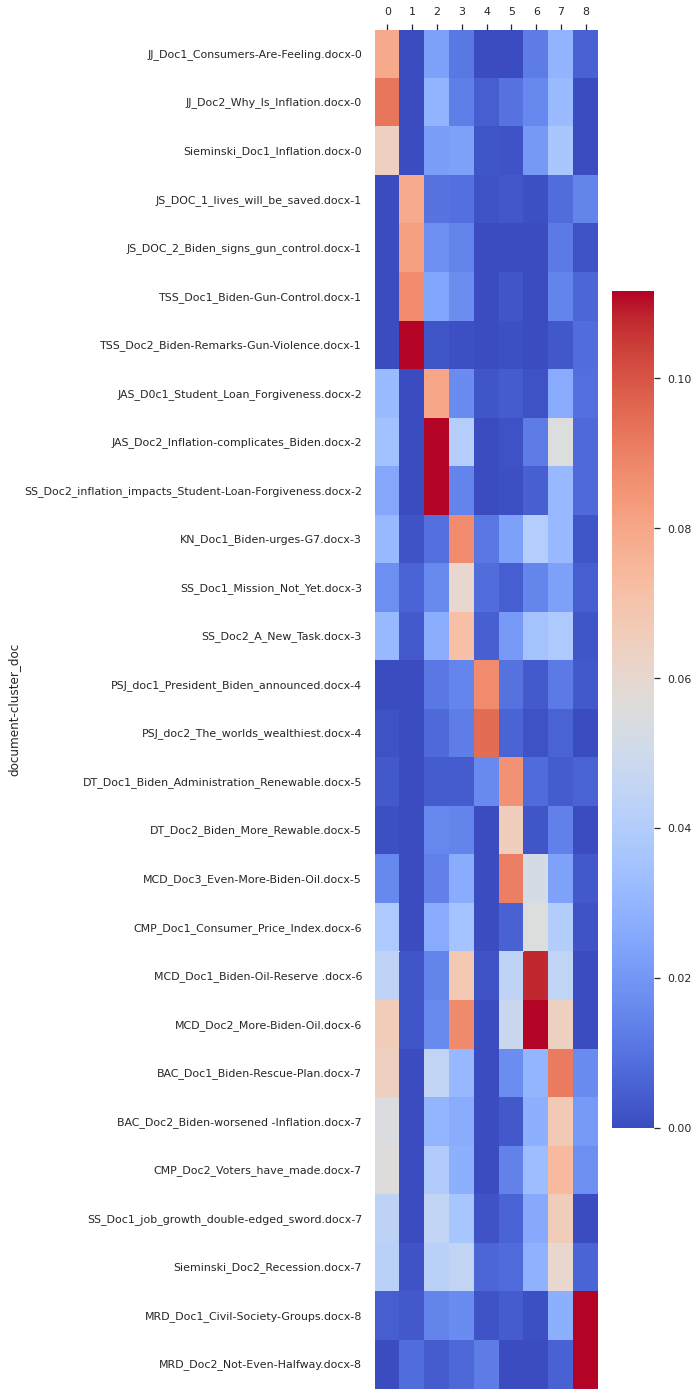

In [ ]:
plt.figure(figsize=(5,25))
plt.rcParams['font.size'] = 10
p=sns.heatmap(full_titles_final, cmap='coolwarm', robust=True)
p.xaxis.tick_top()
p.xaxis.set_label_position('top')

**Hierarchical Clustering - tfidf**

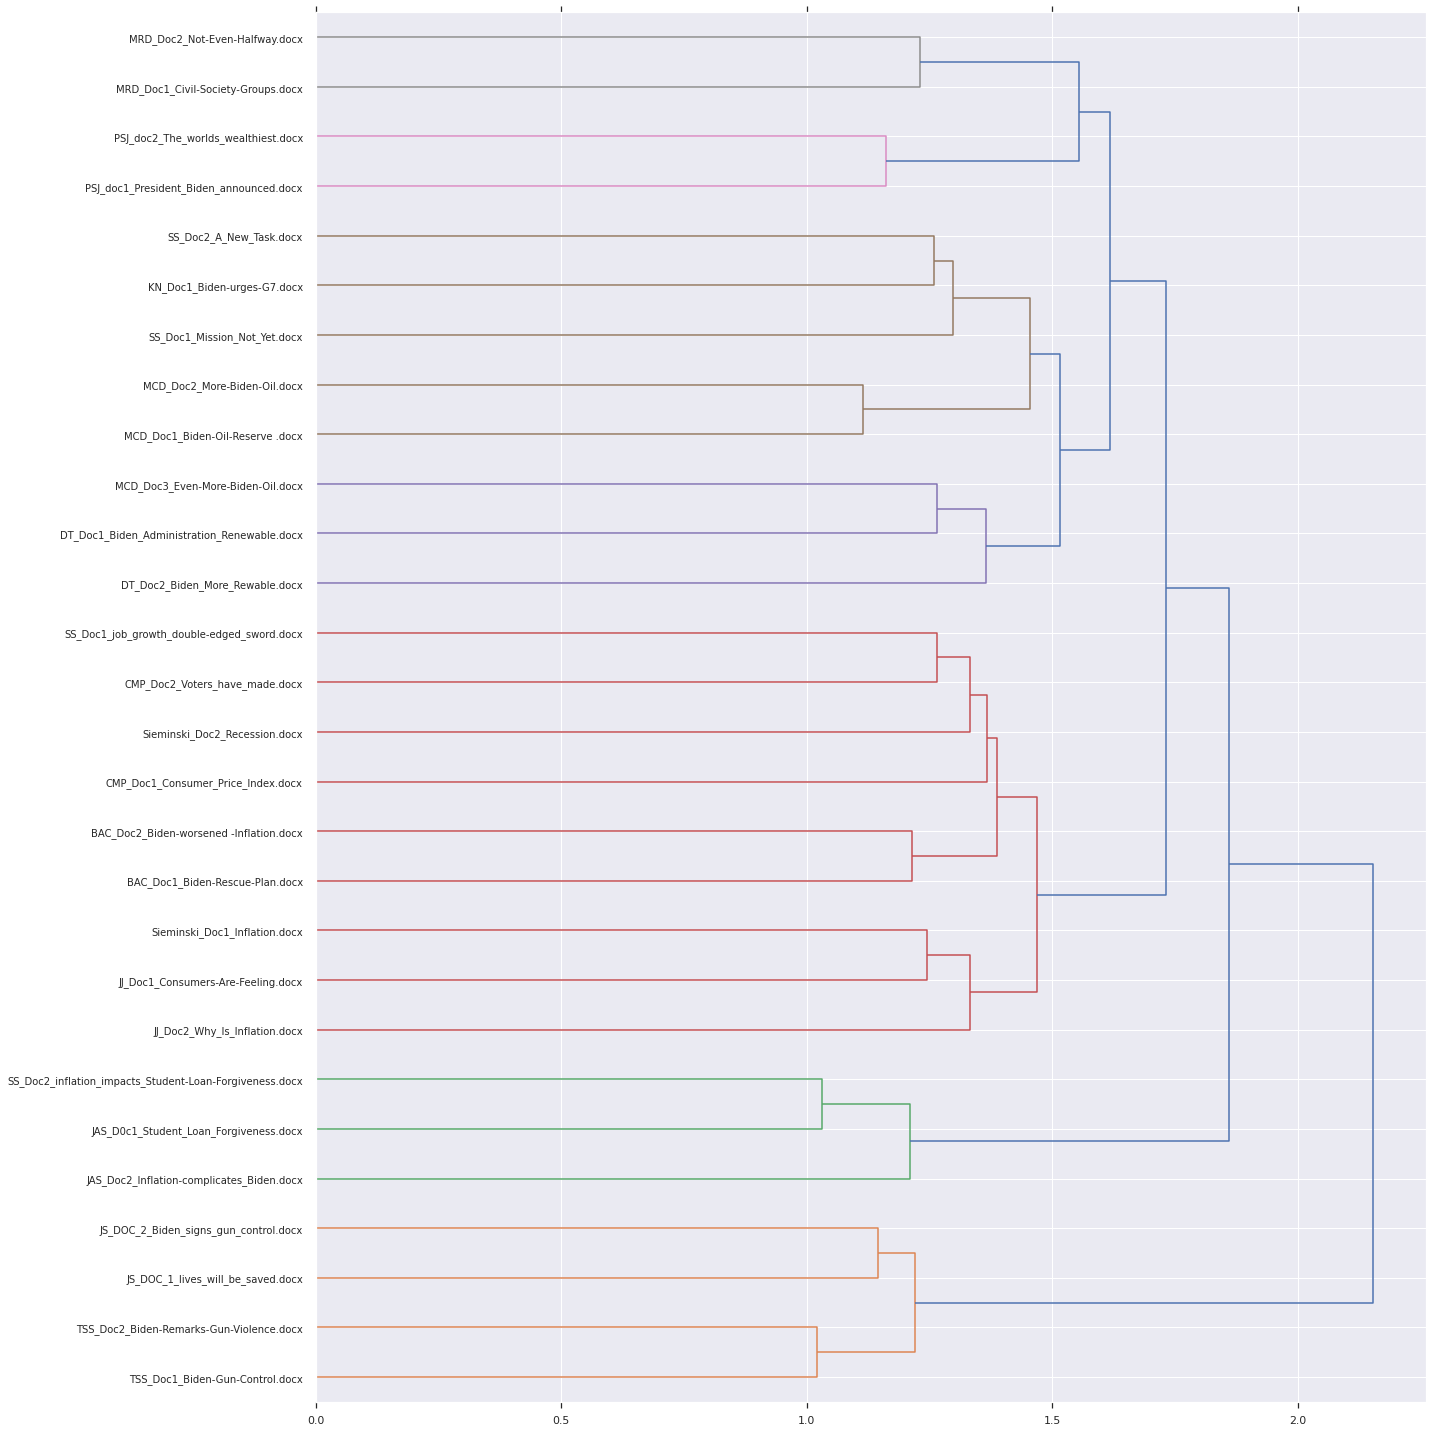

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(20, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

# **Experiment 2**

K Means Clustering Doc2Vec - Compare document clusters to the TFIDF matrix.


In [ ]:
final_processed_text_cd2v = final_processed_text.copy()
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text_cd2v)]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

doc2vec_df=pd.DataFrame()
for i in range(0,len(processed_text)):
    vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
    doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)

doc2vec_df=doc2vec_df.reset_index()

doc_titles={'title': titles}
t=pd.DataFrame(doc_titles)

doc2vec_df=pd.concat([doc2vec_df,t], axis=1)

doc2vec_df=doc2vec_df.drop('index', axis=1)

doc2vec_k_means=doc2vec_df.drop('title', axis=1)

**Elbow Method**

[KMeans(max_iter=600, n_clusters=1),
 KMeans(max_iter=600, n_clusters=2),
 KMeans(max_iter=600, n_clusters=3),
 KMeans(max_iter=600, n_clusters=4),
 KMeans(max_iter=600, n_clusters=5),
 KMeans(max_iter=600, n_clusters=6),
 KMeans(max_iter=600, n_clusters=7),
 KMeans(max_iter=600),
 KMeans(max_iter=600, n_clusters=9),
 KMeans(max_iter=600, n_clusters=10),
 KMeans(max_iter=600, n_clusters=11)]

[-0.023058492690324783,
 -0.021795187145471573,
 -0.020696811378002167,
 -0.019513115286827087,
 -0.018385060131549835,
 -0.017335105687379837,
 -0.01653706468641758,
 -0.015424980781972408,
 -0.014514638110995293,
 -0.013546859845519066,
 -0.012668142095208168]

Text(0.5, 0, 'Number of Clusters')

Text(0, 0.5, 'Score')

Text(0.5, 1.0, 'Elbow Method')

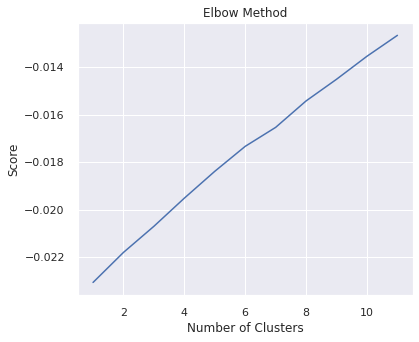

In [ ]:
number_clusters = range(1, 12)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(doc2vec_k_means).score(doc2vec_k_means) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

**Silhouette Score**

KMeans(n_clusters=2, random_state=89)

Number of Clusters: 2
Inertia: 0.02163650095462799
Silhouette: 0.026076743379235268


KMeans(n_clusters=3, random_state=89)

Number of Clusters: 3
Inertia: 0.020704131573438644
Silhouette: 0.009914672002196312


KMeans(n_clusters=4, random_state=89)

Number of Clusters: 4
Inertia: 0.019393622875213623
Silhouette: 0.01867992803454399


KMeans(n_clusters=5, random_state=89)

Number of Clusters: 5
Inertia: 0.018303703516721725
Silhouette: 0.016429666429758072


KMeans(n_clusters=6, random_state=89)

Number of Clusters: 6
Inertia: 0.017522424459457397
Silhouette: 0.010469594970345497


KMeans(n_clusters=7, random_state=89)

Number of Clusters: 7
Inertia: 0.016309361904859543
Silhouette: 0.021600037813186646


KMeans(random_state=89)

Number of Clusters: 8
Inertia: 0.01538015902042389
Silhouette: 0.021276535466313362


KMeans(n_clusters=9, random_state=89)

Number of Clusters: 9
Inertia: 0.014545517042279243
Silhouette: 0.020709138363599777


KMeans(n_clusters=10, random_state=89)

Number of Clusters: 10
Inertia: 0.013448309153318405
Silhouette: 0.021836506202816963


KMeans(n_clusters=11, random_state=89)

Number of Clusters: 11
Inertia: 0.01269327662885189
Silhouette: 0.017551051452755928


KMeans(n_clusters=12, random_state=89)

Number of Clusters: 12
Inertia: 0.01169329322874546
Silhouette: 0.024681901559233665


'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca56792150>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=2, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca567bcd50>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=3, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca56771290>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=4, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca56724790>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=5, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca566d7c90>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=6, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca5669a1d0>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=7, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca56651590>,
                     colors='yellowbrick', estimator=KMeans(random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca56607ad0>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=9, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca56633b50>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=10, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca565f8090>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=11, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca565b7a90>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=12, random_state=89))

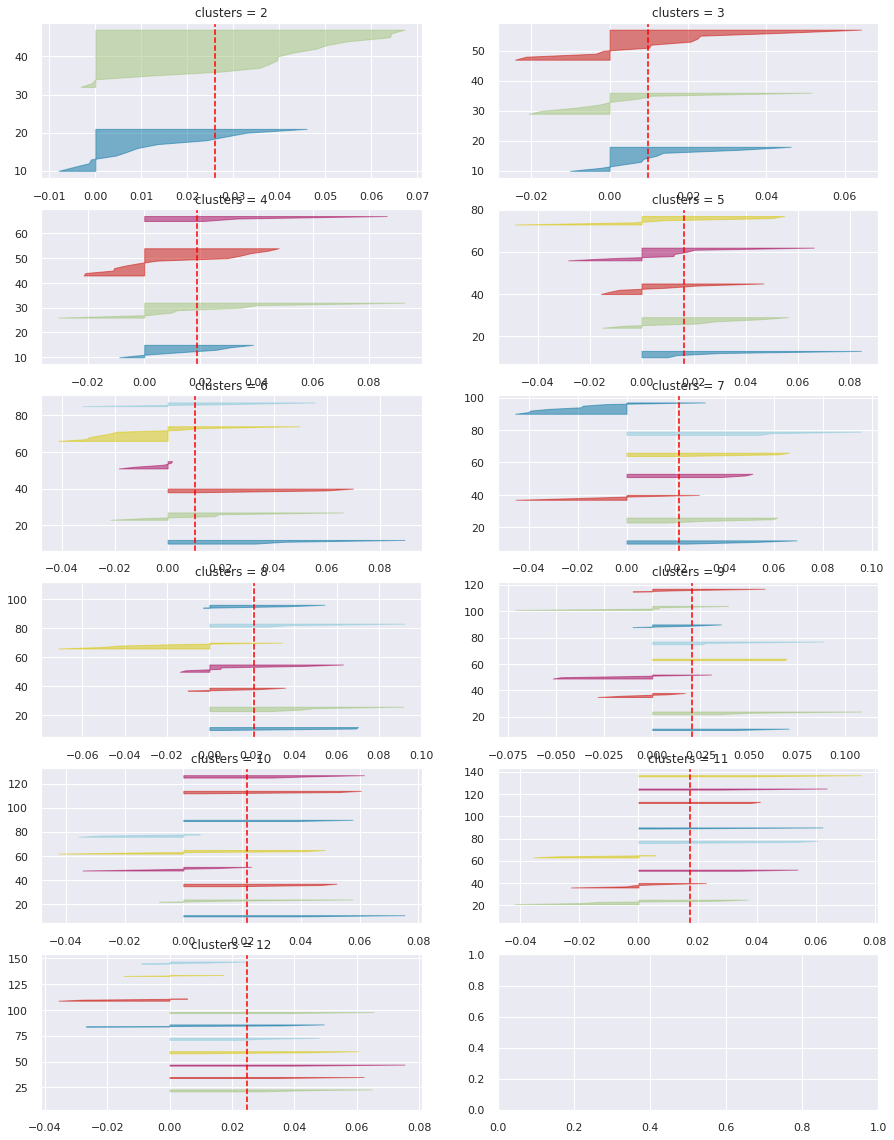

In [ ]:
clusters = [2,3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# test different numbers of clusters
for n_clusters in clusters:
    km = KMeans(n_clusters=n_clusters, random_state =89)
    km.fit(doc2vec_k_means)
    
    #print(km.labels_)
    # print cluster metrics
    calculate_metrics(km,doc2vec_k_means)

#Silhouette Visualizer for cluster

fig, ax = plt.subplots(6, 2, figsize=(15,20))
for i in range(2, 13):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, random_state =89)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    ax[q-1][mod].title.set_text(f'clusters = {i}')
    visualizer.fit(doc2vec_k_means)

**Kmeans - Doc2vec Cluster size 6**

In [ ]:
###############################################################################
### K Means Clustering - Doc2Vec k =6
###############################################################################
k=6
km = KMeans(n_clusters=k, random_state =89)
km.fit(doc2vec_k_means)
clusters_d2v = km.labels_.tolist()

Dictionary={'Doc Name':titles, 'Cluster':clusters_d2v,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

#dictionary to store terms and titles
cluster_title={}

for i in range(k):
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    temp_title_list=[]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_title_list.append(title)
    cluster_title[i]=temp_title_list

KMeans(n_clusters=6, random_state=89)

Cluster 0 titles: BAC_Doc2_Biden-worsened -Inflation.docx, MCD_Doc3_Even-More-Biden-Oil.docx, Sieminski_Doc1_Inflation.docx,Cluster 1 titles: BAC_Doc1_Biden-Rescue-Plan.docx, DT_Doc1_Biden_Administration_Renewable.docx, PSJ_doc2_The_worlds_wealthiest.docx, SS_Doc2_inflation_impacts_Student-Loan-Forgiveness.docx, TSS_Doc2_Biden-Remarks-Gun-Violence.docx,Cluster 2 titles: CMP_Doc1_Consumer_Price_Index.docx, DT_Doc2_Biden_More_Rewable.docx, SS_Doc1_job_growth_double-edged_sword.docx,Cluster 3 titles: CMP_Doc2_Voters_have_made.docx, JAS_D0c1_Student_Loan_Forgiveness.docx, JS_DOC_1_lives_will_be_saved.docx, MRD_Doc2_Not-Even-Halfway.docx, PSJ_doc1_President_Biden_announced.docx,Cluster 4 titles: JAS_Doc2_Inflation-complicates_Biden.docx, JJ_Doc1_Consumers-Are-Feeling.docx, JJ_Doc2_Why_Is_Inflation.docx, JS_DOC_2_Biden_signs_gun_control.docx, KN_Doc1_Biden-urges-G7.docx, MCD_Doc1_Biden-Oil-Reserve .docx, SS_Doc2_A_New_Task.docx, TSS_Doc1_Biden-Gun-Control.docx, Sieminski_Doc2_Recession.docx,

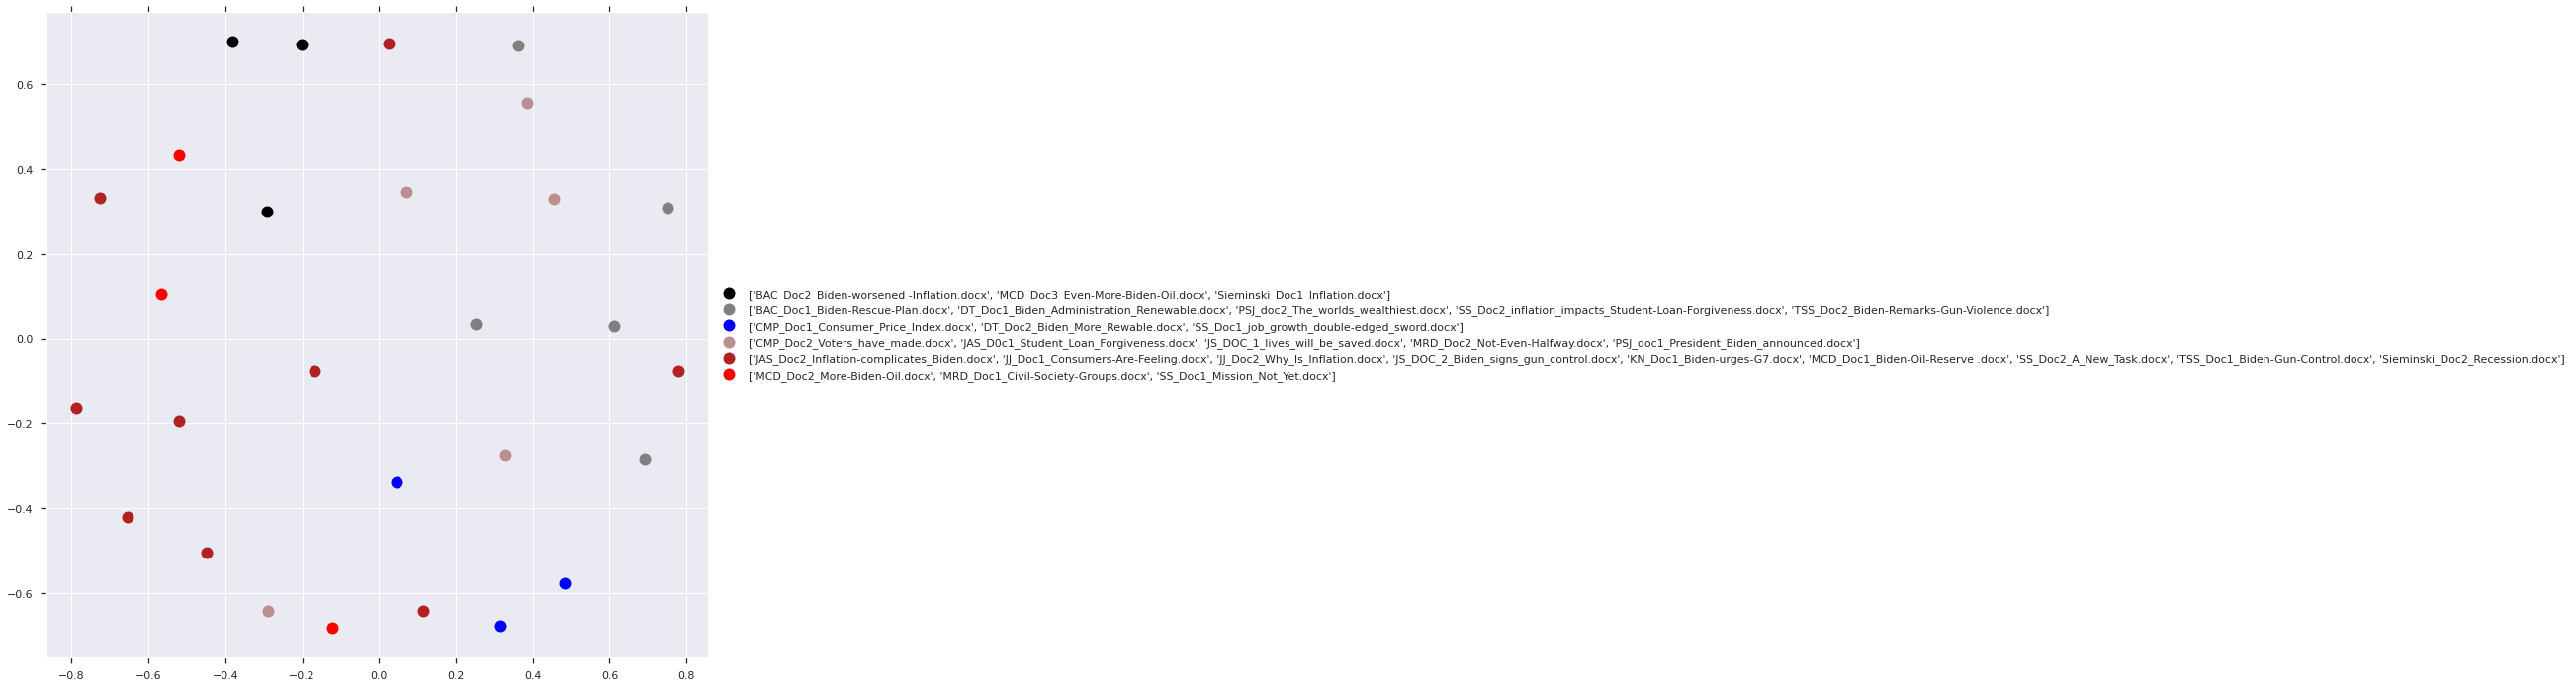

In [ ]:
###############################################################################
### Plotting
###############################################################################
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(doc2vec_k_means)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                  5:'red', 6:'darksalmon', 7:'sienna'}


#set up cluster names using a dict.  
cluster_dict=cluster_title         

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters_d2v, title=range(0,len(clusters_d2v)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

**Review Clusters**

In [ ]:
Clusters = pd.DataFrame.from_dict(cluster_title, orient='index') #convert tiles to a dataframe
Clusters = Clusters.stack() #stack document names into 1 column
Clusters = Clusters.reset_index() #move index into a column
Clusters = Clusters.rename(columns={'level_0': 'cluster_doc', 0:'document'}) #rename columns
Clusters = Clusters.drop(['level_1'], axis=1) #drop unecessary column
Clusters.value_counts(sort=False)

cluster_doc  document                                               
0            BAC_Doc2_Biden-worsened -Inflation.docx                    1
             MCD_Doc3_Even-More-Biden-Oil.docx                          1
             Sieminski_Doc1_Inflation.docx                              1
1            BAC_Doc1_Biden-Rescue-Plan.docx                            1
             DT_Doc1_Biden_Administration_Renewable.docx                1
             PSJ_doc2_The_worlds_wealthiest.docx                        1
             SS_Doc2_inflation_impacts_Student-Loan-Forgiveness.docx    1
             TSS_Doc2_Biden-Remarks-Gun-Violence.docx                   1
2            CMP_Doc1_Consumer_Price_Index.docx                         1
             DT_Doc2_Biden_More_Rewable.docx                            1
             SS_Doc1_job_growth_double-edged_sword.docx                 1
3            CMP_Doc2_Voters_have_made.docx                             1
             JAS_D0c1_Student_Loan_Forgiven

**Kmeans - Doc2vec Cluster size 7**

In [ ]:
###############################################################################
### K Means Clustering - Doc2Vec k =7
###############################################################################
k=7
km = KMeans(n_clusters=k, random_state =89)
km.fit(doc2vec_k_means)
clusters_d2v = km.labels_.tolist()

Dictionary={'Doc Name':titles, 'Cluster':clusters_d2v,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

#dictionary to store terms and titles
cluster_title={}

for i in range(k):
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    temp_title_list=[]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_title_list.append(title)
    cluster_title[i]=temp_title_list

KMeans(n_clusters=7, random_state=89)

Cluster 0 titles: JAS_D0c1_Student_Loan_Forgiveness.docx, MRD_Doc1_Civil-Society-Groups.docx, SS_Doc1_Mission_Not_Yet.docx,Cluster 1 titles: CMP_Doc2_Voters_have_made.docx, JS_DOC_1_lives_will_be_saved.docx, JS_DOC_2_Biden_signs_gun_control.docx, MCD_Doc2_More-Biden-Oil.docx,Cluster 2 titles: BAC_Doc1_Biden-Rescue-Plan.docx, DT_Doc1_Biden_Administration_Renewable.docx, MCD_Doc3_Even-More-Biden-Oil.docx, PSJ_doc1_President_Biden_announced.docx,Cluster 3 titles: KN_Doc1_Biden-urges-G7.docx, PSJ_doc2_The_worlds_wealthiest.docx, TSS_Doc2_Biden-Remarks-Gun-Violence.docx,Cluster 4 titles: CMP_Doc1_Consumer_Price_Index.docx, DT_Doc2_Biden_More_Rewable.docx, SS_Doc1_job_growth_double-edged_sword.docx,Cluster 5 titles: BAC_Doc2_Biden-worsened -Inflation.docx, MRD_Doc2_Not-Even-Halfway.docx, Sieminski_Doc1_Inflation.docx,Cluster 6 titles: JAS_Doc2_Inflation-complicates_Biden.docx, JJ_Doc1_Consumers-Are-Feeling.docx, JJ_Doc2_Why_Is_Inflation.docx, MCD_Doc1_Biden-Oil-Reserve .docx, SS_Doc2_A_New_T

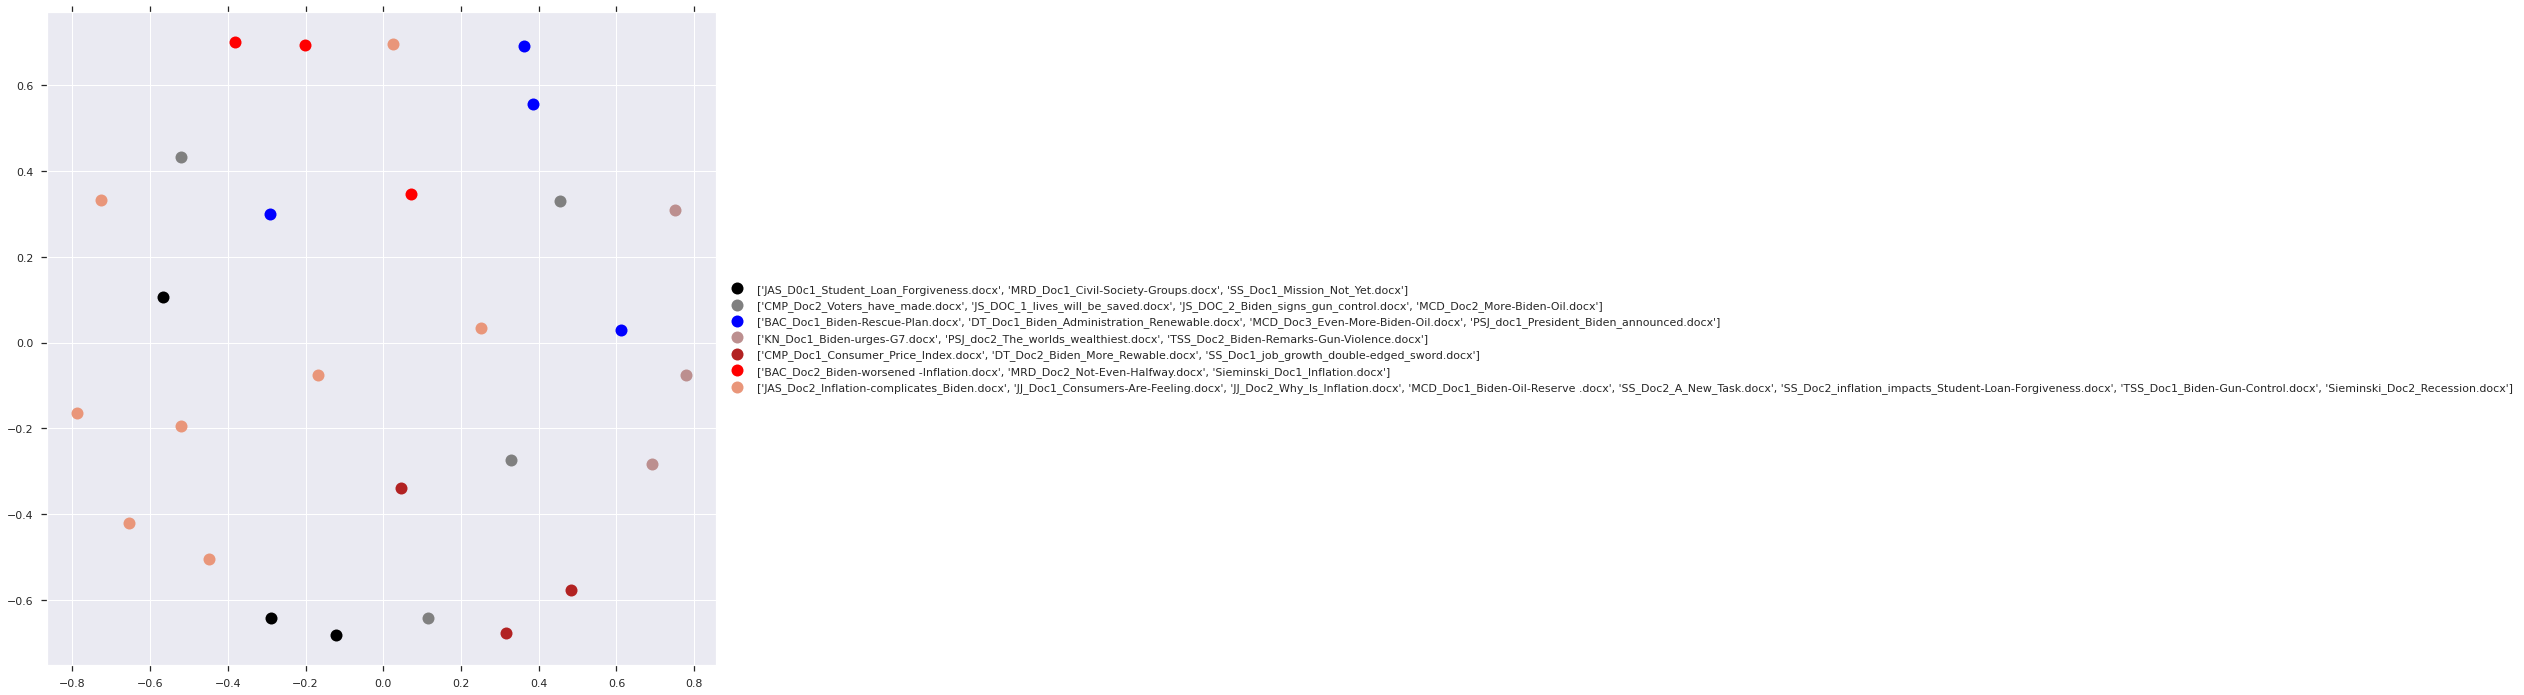

In [ ]:
###############################################################################
### Plotting
###############################################################################
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(doc2vec_k_means)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                  5:'red', 6:'darksalmon', 7:'sienna'}


#set up cluster names using a dict.  
cluster_dict=cluster_title         

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters_d2v, title=range(0,len(clusters_d2v)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

**Review Clusters**

In [ ]:
Clusters = pd.DataFrame.from_dict(cluster_title, orient='index') #convert tiles to a dataframe
Clusters = Clusters.stack() #stack document names into 1 column
Clusters = Clusters.reset_index() #move index into a column
Clusters = Clusters.rename(columns={'level_0': 'cluster_doc', 0:'document'}) #rename columns
Clusters = Clusters.drop(['level_1'], axis=1) #drop unecessary column
Clusters.value_counts(sort=False)

cluster_doc  document                                               
0            JAS_D0c1_Student_Loan_Forgiveness.docx                     1
             MRD_Doc1_Civil-Society-Groups.docx                         1
             SS_Doc1_Mission_Not_Yet.docx                               1
1            CMP_Doc2_Voters_have_made.docx                             1
             JS_DOC_1_lives_will_be_saved.docx                          1
             JS_DOC_2_Biden_signs_gun_control.docx                      1
             MCD_Doc2_More-Biden-Oil.docx                               1
2            BAC_Doc1_Biden-Rescue-Plan.docx                            1
             DT_Doc1_Biden_Administration_Renewable.docx                1
             MCD_Doc3_Even-More-Biden-Oil.docx                          1
             PSJ_doc1_President_Biden_announced.docx                    1
3            KN_Doc1_Biden-urges-G7.docx                                1
             PSJ_doc2_The_worlds_wealthiest

**Kmeans - Doc2vec Cluster size 8**

In [ ]:
###############################################################################
### K Means Clustering - Doc2Vec k = 8
###############################################################################
k=8
km = KMeans(n_clusters=k, random_state =89)
km.fit(doc2vec_k_means)
clusters_d2v = km.labels_.tolist()

Dictionary={'Doc Name':titles, 'Cluster':clusters_d2v,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

#dictionary to store terms and titles
cluster_title={}

for i in range(k):
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    temp_title_list=[]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_title_list.append(title)
    cluster_title[i]=temp_title_list

KMeans(random_state=89)

Cluster 0 titles: CMP_Doc1_Consumer_Price_Index.docx, DT_Doc2_Biden_More_Rewable.docx, SS_Doc1_job_growth_double-edged_sword.docx,Cluster 1 titles: JAS_D0c1_Student_Loan_Forgiveness.docx, JJ_Doc2_Why_Is_Inflation.docx, MRD_Doc1_Civil-Society-Groups.docx, SS_Doc1_Mission_Not_Yet.docx,Cluster 2 titles: DT_Doc1_Biden_Administration_Renewable.docx, SS_Doc2_inflation_impacts_Student-Loan-Forgiveness.docx, TSS_Doc2_Biden-Remarks-Gun-Violence.docx,Cluster 3 titles: BAC_Doc2_Biden-worsened -Inflation.docx, JAS_Doc2_Inflation-complicates_Biden.docx, MCD_Doc3_Even-More-Biden-Oil.docx, MRD_Doc2_Not-Even-Halfway.docx, PSJ_doc1_President_Biden_announced.docx, Sieminski_Doc1_Inflation.docx,Cluster 4 titles: JS_DOC_2_Biden_signs_gun_control.docx, MCD_Doc1_Biden-Oil-Reserve .docx, SS_Doc2_A_New_Task.docx, TSS_Doc1_Biden-Gun-Control.docx, Sieminski_Doc2_Recession.docx,Cluster 5 titles: BAC_Doc1_Biden-Rescue-Plan.docx, JS_DOC_1_lives_will_be_saved.docx, MCD_Doc2_More-Biden-Oil.docx,Cluster 6 titles: CMP

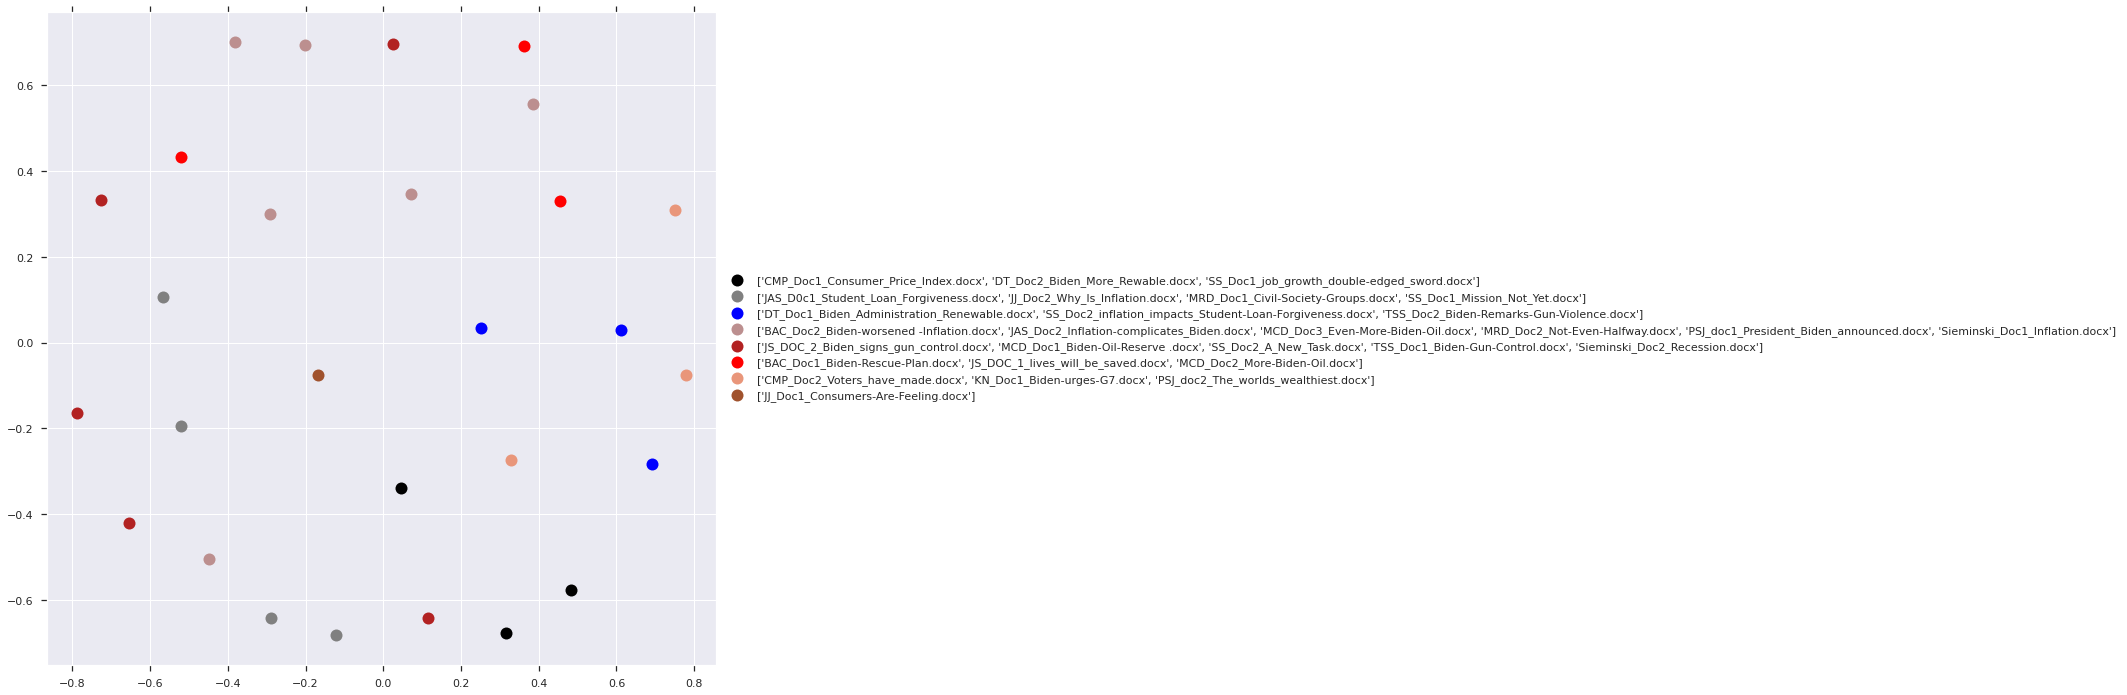

In [ ]:
###############################################################################
### Plotting
###############################################################################
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(doc2vec_k_means)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                  5:'red', 6:'darksalmon', 7:'sienna'}


#set up cluster names using a dict.  
cluster_dict=cluster_title         

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters_d2v, title=range(0,len(clusters_d2v)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

**Review Clusters**

In [ ]:
Clusters = pd.DataFrame.from_dict(cluster_title, orient='index') #convert tiles to a dataframe
Clusters = Clusters.stack() #stack document names into 1 column
Clusters = Clusters.reset_index() #move index into a column
Clusters = Clusters.rename(columns={'level_0': 'cluster_doc', 0:'document'}) #rename columns
Clusters = Clusters.drop(['level_1'], axis=1) #drop unecessary column
Clusters.value_counts(sort=False)

cluster_doc  document                                               
0            CMP_Doc1_Consumer_Price_Index.docx                         1
             DT_Doc2_Biden_More_Rewable.docx                            1
             SS_Doc1_job_growth_double-edged_sword.docx                 1
1            JAS_D0c1_Student_Loan_Forgiveness.docx                     1
             JJ_Doc2_Why_Is_Inflation.docx                              1
             MRD_Doc1_Civil-Society-Groups.docx                         1
             SS_Doc1_Mission_Not_Yet.docx                               1
2            DT_Doc1_Biden_Administration_Renewable.docx                1
             SS_Doc2_inflation_impacts_Student-Loan-Forgiveness.docx    1
             TSS_Doc2_Biden-Remarks-Gun-Violence.docx                   1
3            BAC_Doc2_Biden-worsened -Inflation.docx                    1
             JAS_Doc2_Inflation-complicates_Biden.docx                  1
             MCD_Doc3_Even-More-Biden-Oil.d

**Kmeans - Doc2vec Cluster size 9**

In [ ]:
###############################################################################
### K Means Clustering - Doc2Vec k =9
###############################################################################
k=9
km = KMeans(n_clusters=k, random_state =89)
km.fit(doc2vec_k_means)
clusters_d2v = km.labels_.tolist()

Dictionary={'Doc Name':titles, 'Cluster':clusters_d2v,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

#dictionary to store terms and titles
cluster_title={}

for i in range(k):
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    temp_title_list=[]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_title_list.append(title)
    cluster_title[i]=temp_title_list

KMeans(n_clusters=9, random_state=89)

Cluster 0 titles: KN_Doc1_Biden-urges-G7.docx, PSJ_doc2_The_worlds_wealthiest.docx,Cluster 1 titles: BAC_Doc2_Biden-worsened -Inflation.docx, MRD_Doc2_Not-Even-Halfway.docx, Sieminski_Doc1_Inflation.docx,Cluster 2 titles: DT_Doc2_Biden_More_Rewable.docx, JAS_D0c1_Student_Loan_Forgiveness.docx, JAS_Doc2_Inflation-complicates_Biden.docx, JJ_Doc2_Why_Is_Inflation.docx,Cluster 3 titles: MCD_Doc1_Biden-Oil-Reserve .docx, SS_Doc2_A_New_Task.docx, TSS_Doc1_Biden-Gun-Control.docx, Sieminski_Doc2_Recession.docx,Cluster 4 titles: CMP_Doc1_Consumer_Price_Index.docx, SS_Doc1_job_growth_double-edged_sword.docx,Cluster 5 titles: BAC_Doc1_Biden-Rescue-Plan.docx, JS_DOC_1_lives_will_be_saved.docx, MCD_Doc2_More-Biden-Oil.docx,Cluster 6 titles: DT_Doc1_Biden_Administration_Renewable.docx, SS_Doc2_inflation_impacts_Student-Loan-Forgiveness.docx, TSS_Doc2_Biden-Remarks-Gun-Violence.docx,Cluster 7 titles: CMP_Doc2_Voters_have_made.docx, JJ_Doc1_Consumers-Are-Feeling.docx, JS_DOC_2_Biden_signs_gun_control.

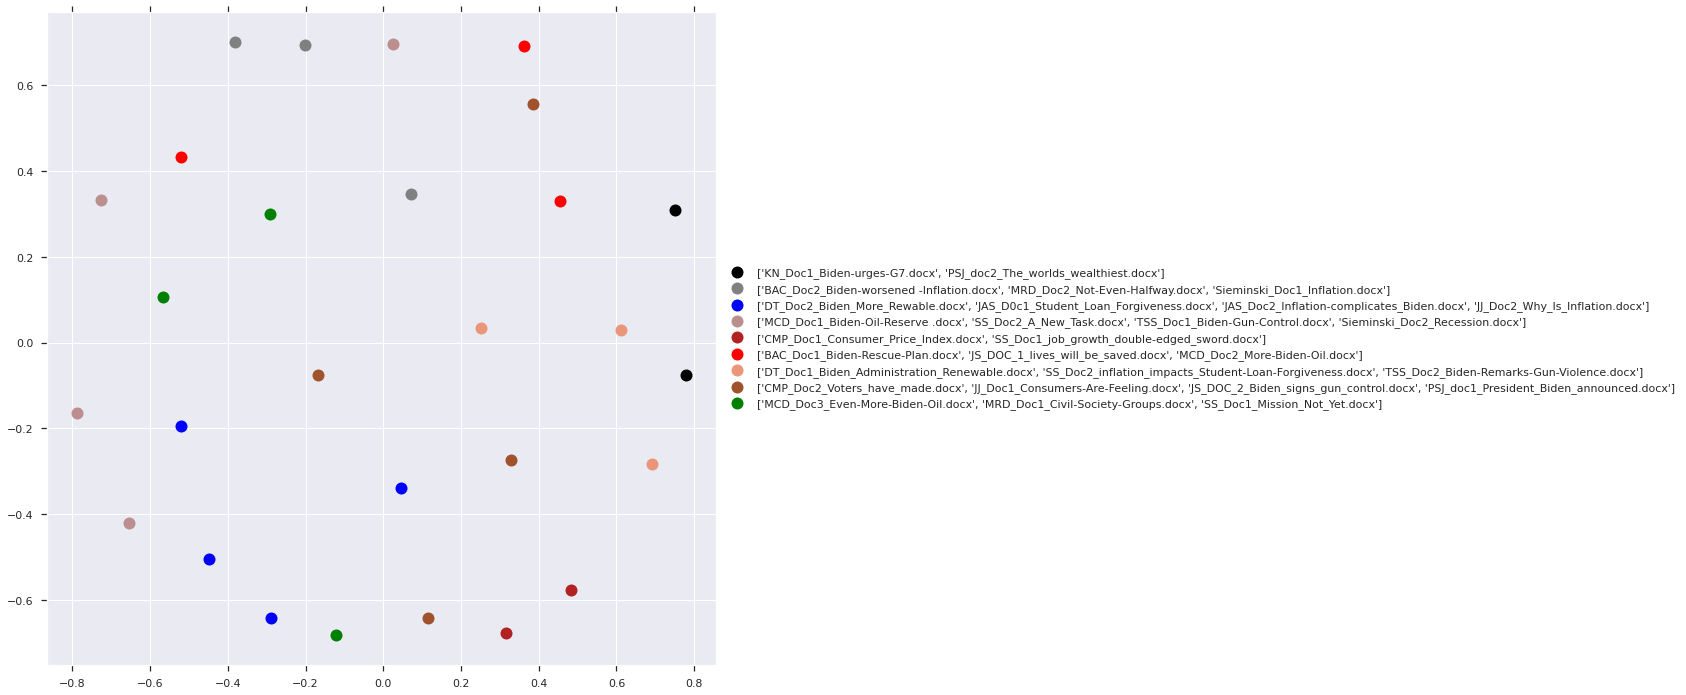

In [ ]:
###############################################################################
### Plotting
###############################################################################
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(doc2vec_k_means)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                  5:'red', 6:'darksalmon', 7:'sienna', 8:'green'}


#set up cluster names using a dict.  
cluster_dict=cluster_title         

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters_d2v, title=range(0,len(clusters_d2v)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

**Review Clusters**

In [ ]:
Clusters = pd.DataFrame.from_dict(cluster_title, orient='index') #convert tiles to a dataframe
Clusters = Clusters.stack() #stack document names into 1 column
Clusters = Clusters.reset_index() #move index into a column
Clusters = Clusters.rename(columns={'level_0': 'cluster_doc', 0:'document'}) #rename columns
Clusters = Clusters.drop(['level_1'], axis=1) #drop unecessary column
Clusters.value_counts(sort=False)

cluster_doc  document                                               
0            KN_Doc1_Biden-urges-G7.docx                                1
             PSJ_doc2_The_worlds_wealthiest.docx                        1
1            BAC_Doc2_Biden-worsened -Inflation.docx                    1
             MRD_Doc2_Not-Even-Halfway.docx                             1
             Sieminski_Doc1_Inflation.docx                              1
2            DT_Doc2_Biden_More_Rewable.docx                            1
             JAS_D0c1_Student_Loan_Forgiveness.docx                     1
             JAS_Doc2_Inflation-complicates_Biden.docx                  1
             JJ_Doc2_Why_Is_Inflation.docx                              1
3            MCD_Doc1_Biden-Oil-Reserve .docx                           1
             SS_Doc2_A_New_Task.docx                                    1
             Sieminski_Doc2_Recession.docx                              1
             TSS_Doc1_Biden-Gun-Control.doc

# **Experiment 3 - Entity Co-Referencing using Equivalence Class**

In [ ]:
###############################################################################
### EC Clean up Code
###############################################################################
    

dictionary = [{'biden' : ['mr. biden', 'biden', 'president joe biden','president biden', 'president', 'joe biden', 'joe_biden']},
              {'biden administration': ['administration', 'biden administration', 'White House Aides']},
              {'soaring': ['acceleration'] },
              {'tesla inc': ['tesla']},
              {'electric car': ['zero-emissions vehicle', 'electric vehicle']},
              {'renewable energy':['clean energy','solar']},
              {'renewable energy policy':['RFS', 'renewable fuel standard', 'energy policy']},
              {'student loan forgiveness' : ['studentloan forgiveness', 'student forgiveness','student cancellation','student relief', 
                                             'student debt forgiveness', 'debt cancellation']},
              {'student loan holders':['student loan borrowers']},
              {'loan repayments': ['loan payments', 'interest payments', 'debt payment']},
              {'reduce':['alleviate']},
              {'stimulus checks' :['stimulus', 'stimulus payments']},
              {'rescue plan':['rescue','american_rescue','package','covidrelief']},
              {'government':['federal','congress','senate']},
              {'war': ['conflict', 'war ukraine']},
              # {'inflation': ['economy,','economic','price','consumer price','cost','index']},
              {'political party':['party','democratic','democrat','republican', 'gop']},
              {'problem':['struggle','issue','threat','decline']},
              {'gun': ['firearms', 'rifles', 'semi-automatic','semi-automatic rifles','assault weapons','pistols','AR-15s','AR 15','AR-15','AR-15 pistols','AK-47s']}]


In [ ]:
# def equivalence_class(dictionary, text):
#     for k,v in dictionary.items():
#         for i in dictionary[k]:
#           #print(i)
#           #print(k)
#           processed_text=text.replace(i,k)
#           text = processed_text
#           #print(processed_text)
#     return processed_text    

In [ ]:
#the following section is example code to create ECs within the corpus.  A dictionary
#will need to be created for every EC.  Each EC will need to be applied to the corpus.
#Below is an example of how the function works.
###############################################################################
### EC clean up code 
###############################################################################
def create_ec(dictionary, corpus):
    for key, values in dictionary.items():
        for value in values:
            corpus= corpus.replace(value, key)
    return corpus


# corpus='i like swiss.  i like cheddar.  i like provolone.'
# cheese_dic={'cheese': ['swiss', 'cheddar', 'provolone']}

# corpus_new=create_ec(cheese_dic, corpus)
# corpus_new

In [ ]:
final_processed_text_replaced_with_eq_class=[]
for k in range(0,len(final_processed_text)):
  temp_text=final_processed_text[k]
  #print(temp_text)
  for dict_item in dictionary:
    processed_text_eq = create_ec(dict_item, temp_text)
    temp_text = processed_text_eq
  #print(processed_text_eq)
  final_processed_text_replaced_with_eq_class.append(processed_text_eq)

In [ ]:
len(final_processed_text_replaced_with_eq_class)

28

In [ ]:
#Call Tfidf Vectorizer
Tfidf=TfidfVectorizer(ngram_range=(1,3))

#fit the vectorizer using final processed documents.  The vectorizer requires the 
#stiched back together document.

TFIDF_matrix_eq=Tfidf.fit_transform(final_processed_text_replaced_with_eq_class)

#creating datafram from TFIDF Matrix
matrix_eq=pd.DataFrame(TFIDF_matrix_eq.toarray(), columns=Tfidf.get_feature_names_out(), index=titles)

[KMeans(max_iter=600, n_clusters=1),
 KMeans(max_iter=600, n_clusters=2),
 KMeans(max_iter=600, n_clusters=3),
 KMeans(max_iter=600, n_clusters=4),
 KMeans(max_iter=600, n_clusters=5),
 KMeans(max_iter=600, n_clusters=6),
 KMeans(max_iter=600, n_clusters=7),
 KMeans(max_iter=600),
 KMeans(max_iter=600, n_clusters=9),
 KMeans(max_iter=600, n_clusters=10),
 KMeans(max_iter=600, n_clusters=11)]

[-25.802698759541954,
 -24.452094725860178,
 -23.10069475250974,
 -21.72673797396243,
 -20.497569315209354,
 -19.448639875415573,
 -18.484905020742172,
 -17.280359521882218,
 -16.25804335460585,
 -15.301701741223862,
 -14.287969443546457]

Text(0.5, 0, 'Number of Clusters')

Text(0, 0.5, 'Score')

Text(0.5, 1.0, 'Elbow Method - TFIDF with equivalence class')

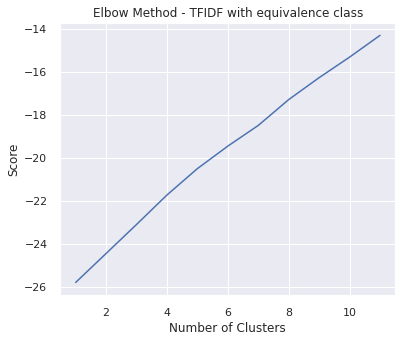

In [ ]:
number_clusters = range(1, 12)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(TFIDF_matrix_eq).score(TFIDF_matrix_eq) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method - TFIDF with equivalence class')
plt.show()

KMeans(n_clusters=2, random_state=89)

Number of Clusters: 2
Inertia: 24.497318606932687
Silhouette: 0.014655998938820317


KMeans(n_clusters=3, random_state=89)

Number of Clusters: 3
Inertia: 23.020423363706403
Silhouette: 0.02594668746263007


KMeans(n_clusters=4, random_state=89)

Number of Clusters: 4
Inertia: 21.690177887431915
Silhouette: 0.03411533725198711


KMeans(n_clusters=5, random_state=89)

Number of Clusters: 5
Inertia: 20.62662378542339
Silhouette: 0.034832935907058625


KMeans(n_clusters=6, random_state=89)

Number of Clusters: 6
Inertia: 19.525856435169963
Silhouette: 0.03709401844057174


KMeans(n_clusters=7, random_state=89)

Number of Clusters: 7
Inertia: 18.29719688914277
Silhouette: 0.045054017224860354


KMeans(random_state=89)

Number of Clusters: 8
Inertia: 17.288076142498447
Silhouette: 0.044888211912641585


KMeans(n_clusters=9, random_state=89)

Number of Clusters: 9
Inertia: 16.250178715222784
Silhouette: 0.04712366553285328


KMeans(n_clusters=10, random_state=89)

Number of Clusters: 10
Inertia: 15.280136290631344
Silhouette: 0.04589026535434032


KMeans(n_clusters=11, random_state=89)

Number of Clusters: 11
Inertia: 14.287969443546457
Silhouette: 0.04899176458731654


KMeans(n_clusters=12, random_state=89)

Number of Clusters: 12
Inertia: 13.37337399438908
Silhouette: 0.04764996474543431


'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca55f6ed90>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=2, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca55c66750>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=3, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca55d2fc50>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=4, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca55cd7190>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=5, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca55cf5690>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=6, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca55bd4b10>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=7, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca55bf4fd0>,
                     colors='yellowbrick', estimator=KMeans(random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca55b9b510>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=9, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca55bb5590>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=10, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca55b5cf90>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=11, random_state=89))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca55b074d0>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=12, random_state=89))

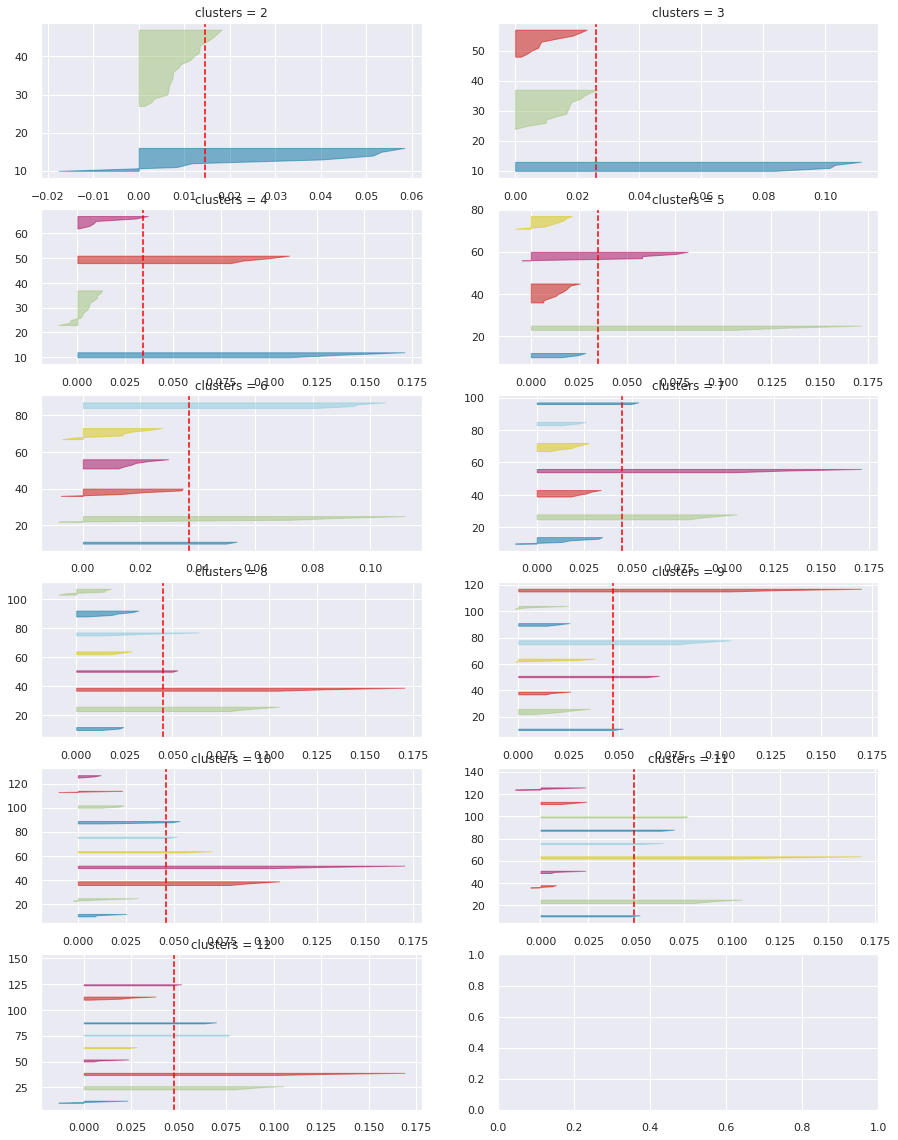

In [ ]:
clusters = [2,3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# test different numbers of clusters
for n_clusters in clusters:
    km = KMeans(n_clusters=n_clusters, random_state =89)
    km.fit(TFIDF_matrix_eq)
    
    #print(km.labels_)
    # print cluster metrics
    calculate_metrics(km,TFIDF_matrix_eq)

#Silhouette Visualizer for cluster

fig, ax = plt.subplots(6, 2, figsize=(15,20))
for i in range(2, 13):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, random_state =89)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    ax[q-1][mod].title.set_text(f'clusters = {i}')
    visualizer.fit(TFIDF_matrix_eq)

**Kmeans - TFIDF Cluster size 6 with Equivalence class**

In [ ]:
###############################################################################
### K Means Clustering - TFIDF with Equivalence class
###############################################################################
k=6
km = KMeans(n_clusters=k, random_state =89)
km.fit(TFIDF_matrix_eq)
clusters = km.labels_.tolist()


terms = Tfidf.get_feature_names()
Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text_replaced_with_eq_class}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]


#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

#dictionary to store terms and titles
cluster_terms={}
cluster_title={}


for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles

KMeans(n_clusters=6, random_state=89)

Top terms per cluster:
Cluster 0:


(None,)

 budget
 defense
 defense budget
 military
 military spending
 pentagon
 fiscal
 government
 spending
 us
Cluster 0 titles: MRD_Doc1_Civil-Society-Groups.docx, MRD_Doc2_Not-Even-Halfway.docx,Cluster 1:


(None,)

 student
 loan
 student loan
 forgiveness
 student loan forgiveness
 loan forgiveness
 inflation
 interest
 biden
 borrower
Cluster 1 titles: JAS_D0c1_Student_Loan_Forgiveness.docx, JAS_Doc2_Inflation-complicates_Biden.docx, JJ_Doc2_Why_Is_Inflation.docx, SS_Doc2_inflation_impacts_Student-Loan-Forgiveness.docx,Cluster 2:


(None,)

 renewable
 energy
 renewable energy
 biden
 project
 oil
 biden administration
 administration
 world
 investment
Cluster 2 titles: DT_Doc1_Biden_Administration_Renewable.docx, DT_Doc2_Biden_More_Rewable.docx, MCD_Doc3_Even-More-Biden-Oil.docx, PSJ_doc1_President_Biden_announced.docx, PSJ_doc2_The_worlds_wealthiest.docx,Cluster 3:


(None,)

 inflation
 price
 consumer
 survey
 american
 rescue plan
 rescue
 point
 american rescue plan
 american rescue
Cluster 3 titles: BAC_Doc1_Biden-Rescue-Plan.docx, BAC_Doc2_Biden-worsened -Inflation.docx, CMP_Doc2_Voters_have_made.docx, JJ_Doc1_Consumers-Are-Feeling.docx, SS_Doc1_job_growth_double-edged_sword.docx, Sieminski_Doc1_Inflation.docx,Cluster 4:


(None,)

 price
 biden
 oil
 russian
 russia
 reserve
 barrel
 sanction
 ukraine
 war
Cluster 4 titles: CMP_Doc1_Consumer_Price_Index.docx, KN_Doc1_Biden-urges-G7.docx, MCD_Doc1_Biden-Oil-Reserve .docx, MCD_Doc2_More-Biden-Oil.docx, SS_Doc1_Mission_Not_Yet.docx, SS_Doc2_A_New_Task.docx, Sieminski_Doc2_Recession.docx,Cluster 5:


(None,)

 gun
 weapon
 assault
 shooting
 violence
 assault weapon
 biden
 uvalde
 texas
 background check
Cluster 5 titles: JS_DOC_1_lives_will_be_saved.docx, JS_DOC_2_Biden_signs_gun_control.docx, TSS_Doc1_Biden-Gun-Control.docx, TSS_Doc2_Biden-Remarks-Gun-Violence.docx,

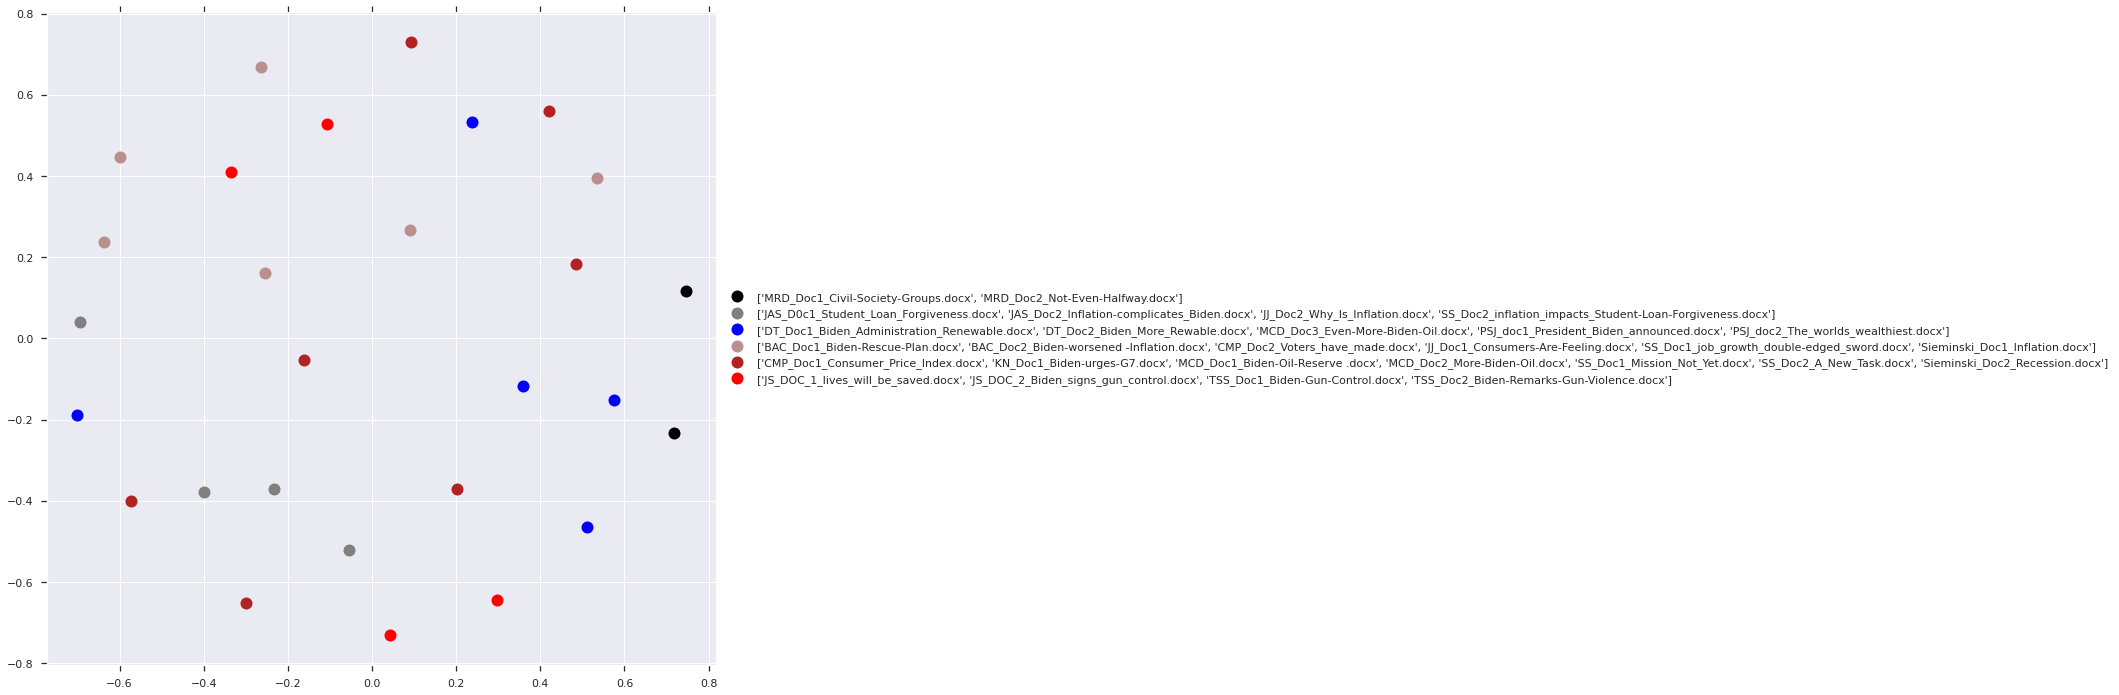

In [ ]:
###############################################################################
### Plotting
###############################################################################

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.

X=TFIDF_matrix_eq
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(X)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                  5:'red', 6:'darksalmon', 7:'sienna', 8:'green'}


#set up cluster names using a dict.  
cluster_dict=cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

**Review Clusters**

In [ ]:
term_clusters_eq = pd.DataFrame.from_dict(cluster_terms) #pull out terms into a dataframe
terms_eq = term_clusters_eq.stack() #stack terms names into 1 column
terms_eq = terms_eq.reset_index() #move index into a column
terms_eq = terms_eq.rename(columns={'level_1': 'cluster_term', 0:'term'}) #rename columns
terms_eq = terms_eq.drop(['level_0'], axis=1) #drop unecessary column
terms_eq.head()
term_clusters_eq

cluster_term       term
0             0     budget
1             1    student
2             2  renewable
3             3  inflation
4             4      price

0                         1                     2  \
0             budget                   student             renewable   
1            defense                      loan                energy   
2     defense budget              student loan      renewable energy   
3           military               forgiveness                 biden   
4  military spending  student loan forgiveness               project   
5           pentagon          loan forgiveness                   oil   
6             fiscal                 inflation  biden administration   
7         government                  interest        administration   
8           spending                     biden                 world   
9                 us                  borrower            investment   

                      3         4                 5  
0             inflation     price               gun  
1                 price     biden            weapon  
2              consumer       oil           assault  
3                survey   russian          shooting  
4              american    russia          violence  
5           rescue plan   reserve    assault weapon  
6                rescue    barrel             biden  
7                 point  sanction            uvalde  
8  american rescue plan   ukraine             texas  
9       american rescue       war  background check

In [ ]:
clusters_eq = pd.DataFrame.from_dict(cluster_title, orient='index') #convert tiles to a dataframe
clusters_eq = clusters_eq.stack() #stack document names into 1 column
clusters_eq = clusters_eq.reset_index() #move index into a column
clusters_eq = clusters_eq.rename(columns={'level_0': 'cluster_doc', 0:'document'}) #rename columns
clusters_eq = clusters_eq.drop(['level_1'], axis=1) #drop unecessary column
clusters_eq.value_counts(sort=False)

cluster_doc  document                                               
0            MRD_Doc1_Civil-Society-Groups.docx                         1
             MRD_Doc2_Not-Even-Halfway.docx                             1
1            JAS_D0c1_Student_Loan_Forgiveness.docx                     1
             JAS_Doc2_Inflation-complicates_Biden.docx                  1
             JJ_Doc2_Why_Is_Inflation.docx                              1
             SS_Doc2_inflation_impacts_Student-Loan-Forgiveness.docx    1
2            DT_Doc1_Biden_Administration_Renewable.docx                1
             DT_Doc2_Biden_More_Rewable.docx                            1
             MCD_Doc3_Even-More-Biden-Oil.docx                          1
             PSJ_doc1_President_Biden_announced.docx                    1
             PSJ_doc2_The_worlds_wealthiest.docx                        1
3            BAC_Doc1_Biden-Rescue-Plan.docx                            1
             BAC_Doc2_Biden-worsened -Infla

In [ ]:
term_list = terms_eq['term'].values.tolist() #pull all terms into a list
matrix_clustering_eq = matrix_eq[term_list] #pull out only terms in clusters
full_titles = clusters_eq.set_index('document').join(matrix_clustering_eq, how='left') # join in tf-idf values
full_titles.shape

(28, 61)

In [ ]:
# calculate average tf-idf values for each cluster of terms
for i in range (k):
    full_titles[i] = full_titles[term_clusters_eq[i].values.tolist()].mean(axis=1)

In [ ]:
# remove all other columsn leaving only the average 
full_titles = full_titles.set_index('cluster_doc', append=True)
full_titles_final = full_titles[full_titles.columns[-k:]]

<Figure size 360x1800 with 0 Axes>

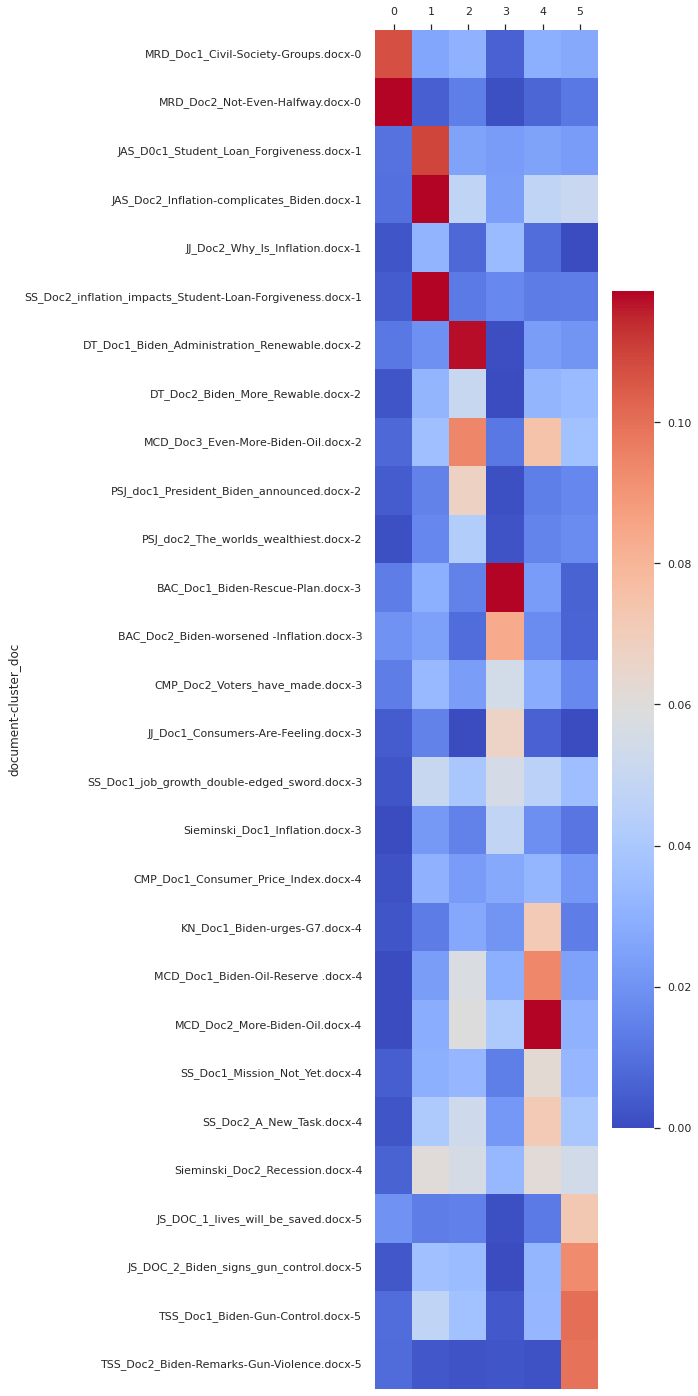

In [ ]:
plt.figure(figsize=(5,25))
plt.rcParams['font.size'] = 10
p=sns.heatmap(full_titles_final, cmap='coolwarm', robust=True)
p.xaxis.tick_top()
p.xaxis.set_label_position('top')

**Kmeans - Doc2vec Cluster size 6 with equivalence class**

In [ ]:
final_processed_text_cd2v_eq = final_processed_text_replaced_with_eq_class.copy()
documents_eq = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text_cd2v_eq)]
model = Doc2Vec(documents_eq, vector_size=100, window=2, min_count=1, workers=4)

doc2vec_df_eq=pd.DataFrame()
for i in range(0,len(final_processed_text_cd2v_eq)):
    vector=pd.DataFrame(model.infer_vector(final_processed_text_cd2v_eq[i])).transpose()
    doc2vec_df_eq=pd.concat([doc2vec_df_eq,vector], axis=0)

doc2vec_df_eq=doc2vec_df_eq.reset_index()

doc_titles={'title': titles}
t=pd.DataFrame(doc_titles)

doc2vec_df_eq=pd.concat([doc2vec_df_eq,t], axis=1)

doc2vec_df_eq=doc2vec_df_eq.drop('index', axis=1)

doc2vec_eq_k_means=doc2vec_df_eq.drop('title', axis=1)

In [ ]:
###############################################################################
### K Means Clustering - Doc2Vec k =6 with equivalence class corpus
###############################################################################
###############################################################################
### K Means Clustering - Doc2Vec k =6
###############################################################################
k=6
km = KMeans(n_clusters=k, random_state =89)
km.fit(doc2vec_eq_k_means)
clusters_d2v_eq = km.labels_.tolist()
clusters_d2v_eq
Dictionary_eq={'Doc Name':titles, 'Cluster':clusters_d2v_eq,  'Text': final_processed_text}
frame_eq=pd.DataFrame(Dictionary_eq, columns=['Cluster', 'Doc Name','Text'])

#dictionary to store terms and titles
cluster_title={}

for i in range(k):
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    temp_title_list=[]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_title_list.append(title)
    cluster_title[i]=temp_title_list

KMeans(n_clusters=6, random_state=89)

[2,
 5,
 5,
 5,
 0,
 1,
 1,
 3,
 3,
 4,
 3,
 0,
 3,
 4,
 3,
 1,
 5,
 3,
 4,
 4,
 5,
 0,
 1,
 2,
 4,
 0,
 4,
 3]

Cluster 0 titles: MRD_Doc1_Civil-Society-Groups.docx, MRD_Doc2_Not-Even-Halfway.docx,Cluster 1 titles: JAS_D0c1_Student_Loan_Forgiveness.docx, JAS_Doc2_Inflation-complicates_Biden.docx, JJ_Doc2_Why_Is_Inflation.docx, SS_Doc2_inflation_impacts_Student-Loan-Forgiveness.docx,Cluster 2 titles: DT_Doc1_Biden_Administration_Renewable.docx, DT_Doc2_Biden_More_Rewable.docx, MCD_Doc3_Even-More-Biden-Oil.docx, PSJ_doc1_President_Biden_announced.docx, PSJ_doc2_The_worlds_wealthiest.docx,Cluster 3 titles: BAC_Doc1_Biden-Rescue-Plan.docx, BAC_Doc2_Biden-worsened -Inflation.docx, CMP_Doc2_Voters_have_made.docx, JJ_Doc1_Consumers-Are-Feeling.docx, SS_Doc1_job_growth_double-edged_sword.docx, Sieminski_Doc1_Inflation.docx,Cluster 4 titles: CMP_Doc1_Consumer_Price_Index.docx, KN_Doc1_Biden-urges-G7.docx, MCD_Doc1_Biden-Oil-Reserve .docx, MCD_Doc2_More-Biden-Oil.docx, SS_Doc1_Mission_Not_Yet.docx, SS_Doc2_A_New_Task.docx, Sieminski_Doc2_Recession.docx,Cluster 5 titles: JS_DOC_1_lives_will_be_saved.docx, 

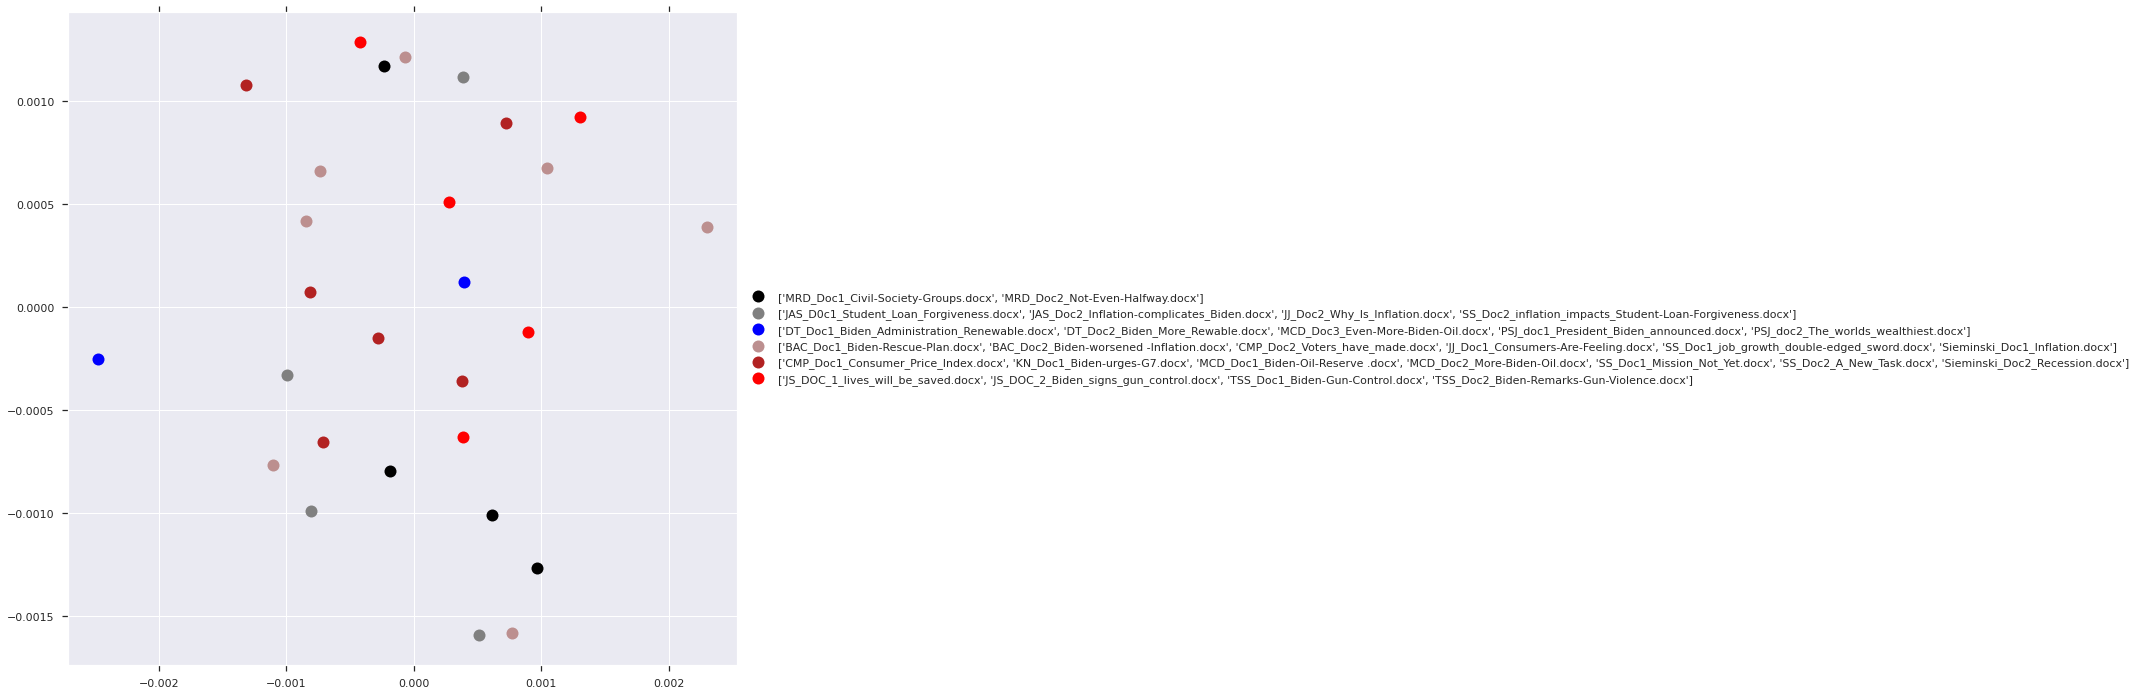

In [ ]:
###############################################################################
### Plotting
###############################################################################
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(doc2vec_eq_k_means)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                  5:'red', 6:'darksalmon', 7:'sienna'}


#set up cluster names using a dict.  
cluster_dict=cluster_title         

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters_d2v_eq, title=range(0,len(clusters_d2v_eq)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

**Review Clusters**

In [ ]:
Clusters = pd.DataFrame.from_dict(cluster_title, orient='index') #convert tiles to a dataframe
Clusters = Clusters.stack() #stack document names into 1 column
Clusters = Clusters.reset_index() #move index into a column
Clusters = Clusters.rename(columns={'level_0': 'cluster_doc', 0:'document'}) #rename columns
Clusters = Clusters.drop(['level_1'], axis=1) #drop unecessary column
Clusters.value_counts(sort=False)

cluster_doc  document                                               
0            MRD_Doc1_Civil-Society-Groups.docx                         1
             MRD_Doc2_Not-Even-Halfway.docx                             1
1            JAS_D0c1_Student_Loan_Forgiveness.docx                     1
             JAS_Doc2_Inflation-complicates_Biden.docx                  1
             JJ_Doc2_Why_Is_Inflation.docx                              1
             SS_Doc2_inflation_impacts_Student-Loan-Forgiveness.docx    1
2            DT_Doc1_Biden_Administration_Renewable.docx                1
             DT_Doc2_Biden_More_Rewable.docx                            1
             MCD_Doc3_Even-More-Biden-Oil.docx                          1
             PSJ_doc1_President_Biden_announced.docx                    1
             PSJ_doc2_The_worlds_wealthiest.docx                        1
3            BAC_Doc1_Biden-Rescue-Plan.docx                            1
             BAC_Doc2_Biden-worsened -Infla

# **EXPERIMENT 4**
LDA - Topic Modeling

In [ ]:
# Topic Modeling
# LDA using bag of words
dictionary = corpora.Dictionary(processed_text)
corpus = [dictionary.doc2bow(doc) for doc in processed_text]

ldamodel = gensim.models.ldamodel.LdaModel(
    corpus = corpus,
    id2word = dictionary,
    num_topics = 5,
    random_state = 100,
    update_every = 1,
    chunksize=100,
    passes=10,
    alpha="auto",
    per_word_topics=True
) 

for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

Topic: 0 
Words: 0.024*"biden" + 0.022*"student" + 0.012*"inflation" + 0.009*"forgiveness" + 0.009*"oil" + 0.008*"price" + 0.008*"gun" + 0.006*"administration" + 0.005*"president" + 0.005*"spending"
Topic: 1 
Words: 0.021*"gun" + 0.018*"weapon" + 0.011*"assault" + 0.009*"uvalde" + 0.009*"child" + 0.007*"people" + 0.007*"inflation" + 0.007*"check" + 0.006*"republican" + 0.006*"texas"
Topic: 2 
Words: 0.018*"biden" + 0.011*"inflation" + 0.011*"price" + 0.008*"president" + 0.008*"american" + 0.008*"oil" + 0.007*"economy" + 0.007*"world" + 0.006*"supply" + 0.005*"ukraine"
Topic: 3 
Words: 0.015*"inflation" + 0.014*"price" + 0.011*"consumer" + 0.010*"energy" + 0.010*"biden" + 0.009*"country" + 0.006*"american" + 0.006*"fed" + 0.005*"point" + 0.005*"president"
Topic: 4 
Words: 0.014*"inflation" + 0.012*"defense" + 0.011*"budget" + 0.008*"increase" + 0.007*"march" + 0.007*"price" + 0.006*"us" + 0.006*"rate" + 0.006*"interest" + 0.006*"cpi"


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=processed_text,dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for


Perplexity:  -7.363377119214921


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for


Coherence Score:  0.4208189103798454


In [ ]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(ldamodel, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.027600 -0.056810       1        1  31.608085
2     -0.051942 -0.084333       2        1  27.824490
3     -0.069168  0.013552       3        1  19.520392
1      0.146834  0.024623       4        1  11.433201
4     -0.053324  0.102968       5        1   9.613831, topic_info=           Term       Freq       Total Category  logprob  loglift
820     student  55.000000   55.000000  Default  30.0000  30.0000
1148        gun  38.000000   38.000000  Default  29.0000  29.0000
1201     weapon  30.000000   30.000000  Default  28.0000  28.0000
501      budget  14.000000   14.000000  Default  27.0000  27.0000
1286    defense  11.000000   11.000000  Default  26.0000  26.0000
...         ...        ...         ...      ...      ...      ...
12        biden   3.811988  113.477802   Topic5  -5.2191  -1.0515
326       house   2.517792   19.367550   Topic5  -5.6338   0.3018
380   according   2.515885   18.920334   Topic5  -5.6346   0.3244
375      united   2.496401   14.139381   Topic5  -5.6424   0.6079
259      states   2.494941   19.072730   Topic5  -5.6430   0.3080

[362 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
380       1  0.475679   according
380       2  0.052853   according
380       3  0.264266   according
380       4  0.052853   according
380       5  0.158560   according
...     ...       ...         ...
491       2  0.225170        year
491       3  0.225170        year
491       4  0.225170        year
491       5  0.056292        year
1110      5  0.794954  zaccarelli

[638 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2, 5])

Text(0.5, 1.0, 'Topic 0')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 1')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 2')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 3')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 4')

(-0.5, 2499.5, 1799.5, -0.5)

(-0.5, 2499.5, 1799.5, -0.5)

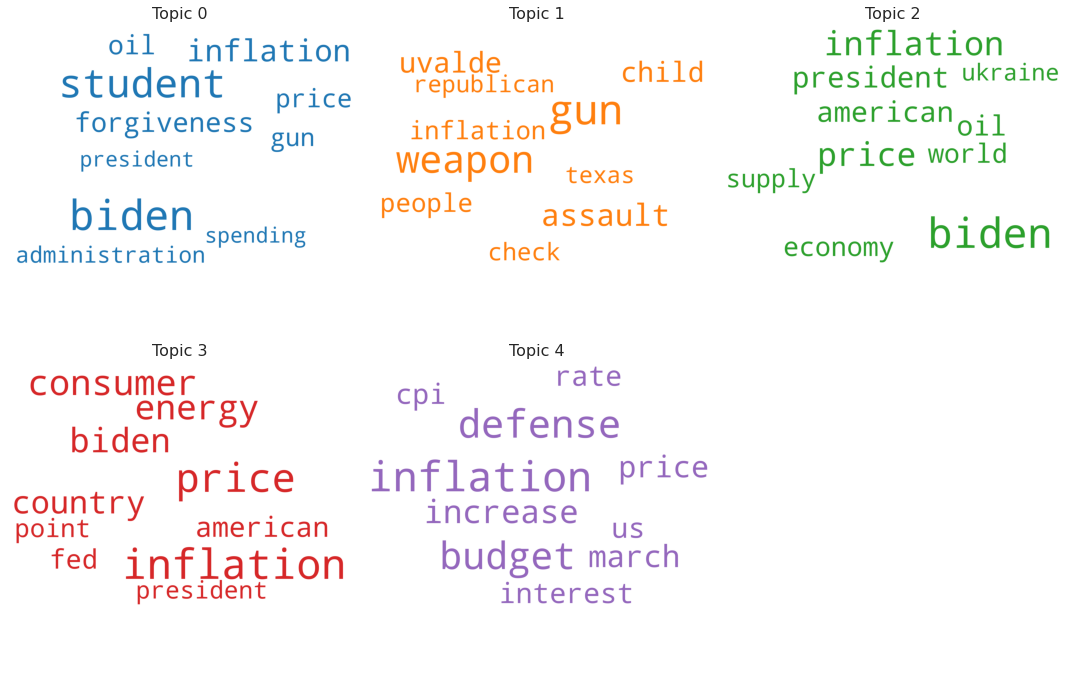

In [ ]:
# Wordcloud of Top N words in each topic
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodel.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(15,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    if i < len(topics):
          topic_words = dict(topics[i][1])
          cloud.generate_from_frequencies(topic_words, max_font_size=300)
          plt.gca().imshow(cloud)
          plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
          plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

In [ ]:
def dominant_topic_per_doc(dominant_topics):
  df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
  dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
  df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()
  return df_dominant_topic_in_each_doc

In [ ]:
def topic_weightage_per_doc(topic_percentages):
  topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
  df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()
  return df_topic_weightage_by_doc


In [ ]:
def topNwords_per_topic(model):
  topic_top3words = [(i, topic) for i, topics in model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

  df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
  df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
  df_top3words.reset_index(level=0,inplace=True)
  return df_top3words

In [ ]:
dominant_topics, topic_percentages = topics_per_document(model=ldamodel, corpus=corpus, end=-1)            

df_dominant_topic_in_each_doc = dominant_topic_per_doc(dominant_topics)
df_topic_weightage_by_doc = topic_weightage_per_doc(topic_percentages)
df_top3words = topNwords_per_topic(ldamodel)


<BarContainer object of 5 artists>

Text(0.5, 1.0, 'Number of Documents by Dominant Topic')

Text(0, 0.5, 'Number of Documents')

(0.0, 10.0)

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'Number of Documents by Topic Weightage')

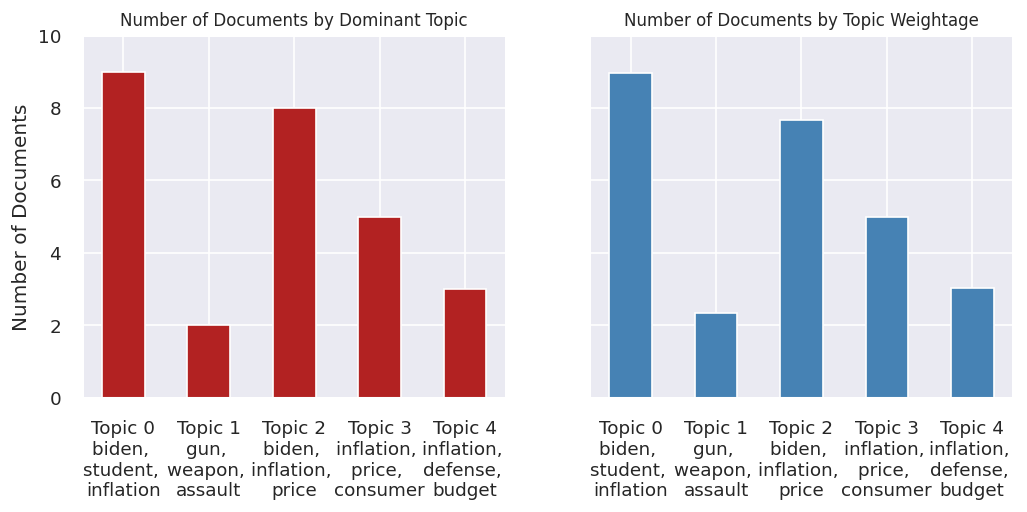

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 10)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

**Retrain Bow with 4 topics**

In [ ]:
ldamodel = gensim.models.ldamodel.LdaModel(
    corpus = corpus,
    id2word = dictionary,
    num_topics = 4,
    random_state = 100,
    update_every = 1,
    chunksize=100,
    passes=10,
    alpha="auto",
    per_word_topics=True
) 

for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

Topic: 0 
Words: 0.022*"biden" + 0.010*"oil" + 0.008*"gun" + 0.007*"administration" + 0.006*"price" + 0.006*"president" + 0.006*"inflation" + 0.006*"economic" + 0.005*"spending" + 0.005*"senate"
Topic: 1 
Words: 0.030*"student" + 0.016*"inflation" + 0.012*"gun" + 0.011*"weapon" + 0.010*"forgiveness" + 0.007*"biden" + 0.007*"assault" + 0.006*"check" + 0.006*"uvalde" + 0.006*"interest"
Topic: 2 
Words: 0.016*"biden" + 0.010*"inflation" + 0.008*"american" + 0.007*"president" + 0.006*"world" + 0.006*"economy" + 0.006*"price" + 0.005*"investment" + 0.005*"defense" + 0.005*"weapon"
Topic: 3 
Words: 0.019*"price" + 0.016*"inflation" + 0.012*"biden" + 0.008*"consumer" + 0.008*"energy" + 0.007*"gas" + 0.007*"oil" + 0.007*"country" + 0.006*"month" + 0.005*"president"


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

**Compute model performance metrics**

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel.log_perplexity(corpus)) 
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=processed_text, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
# change value of num_topics and re-run, you should notice these scores change


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for


Perplexity:  -7.354740378836644

Coherence Score:  0.505417215668012


In [ ]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(ldamodel, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.066264  0.090013       1        1  28.556405
2      0.060256 -0.033648       2        1  28.204835
0      0.008272 -0.080625       3        1  25.470184
1     -0.134792  0.024261       4        1  17.768576, topic_info=             Term       Freq       Total Category  logprob  loglift
820       student  47.000000   47.000000  Default  30.0000  30.0000
1148          gun  38.000000   38.000000  Default  29.0000  29.0000
765   forgiveness  18.000000   18.000000  Default  28.0000  28.0000
1201       weapon  31.000000   31.000000  Default  27.0000  27.0000
100         price  68.000000   68.000000  Default  26.0000  26.0000
...           ...        ...         ...      ...      ...      ...
12          biden   9.591804  108.110989   Topic4  -4.9105  -0.6945
78         market   4.994603   16.540355   Topic4  -5.5631   0.5303
69       increase   5.195590   25.714444   Topic4  -5.5236   0.1285
63         higher   4.793006   18.958874   Topic4  -5.6043   0.3526
181        enough   4.397388   11.956336   Topic4  -5.6904   0.7275

[302 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
380       1  0.417619       according
380       2  0.208810       according
380       3  0.313214       according
380       4  0.052202       according
280       1  0.408819  administration
...     ...       ...             ...
489       2  0.805596          worker
1202      1  0.161166           world
1202      2  0.698386           world
1202      3  0.107444           world
1110      4  0.696242      zaccarelli

[484 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

Text(0.5, 1.0, 'Topic 0')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 1')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 2')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 3')

(-0.5, 2499.5, 1799.5, -0.5)

(-0.5, 2499.5, 1799.5, -0.5)

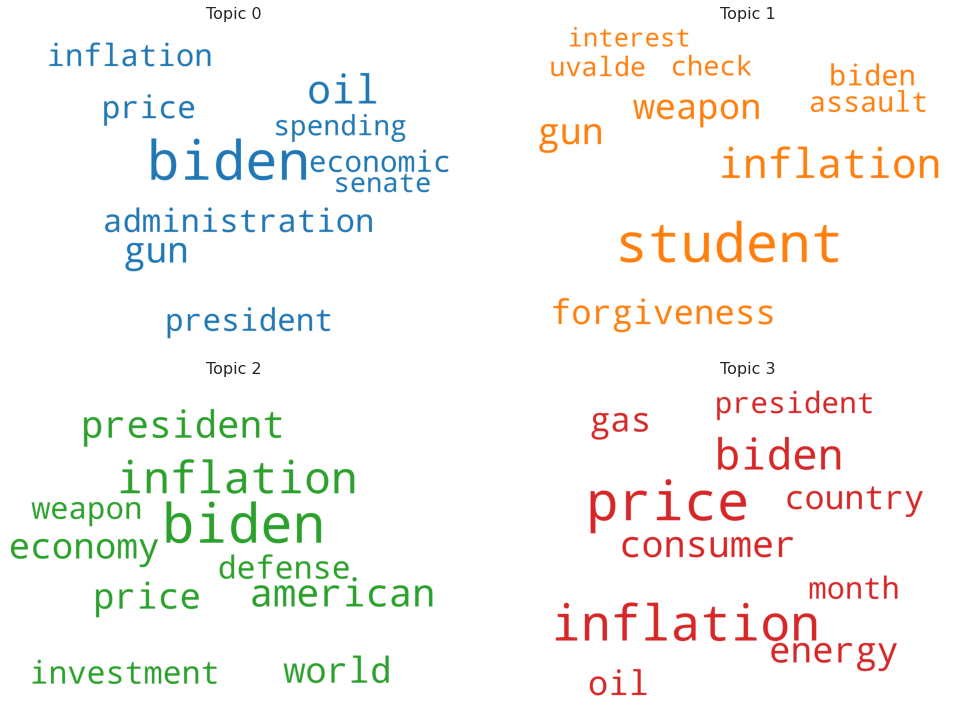

In [ ]:
# Wordcloud of Top N words in each topic
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodel.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(15,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    if i < len(topics):
          topic_words = dict(topics[i][1])
          cloud.generate_from_frequencies(topic_words, max_font_size=300)
          plt.gca().imshow(cloud)
          plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
          plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
dominant_topics, topic_percentages = topics_per_document(model=ldamodel, corpus=corpus, end=-1)            

df_dominant_topic_in_each_doc = dominant_topic_per_doc(dominant_topics)
df_topic_weightage_by_doc = topic_weightage_per_doc(topic_percentages)
df_top3words = topNwords_per_topic(ldamodel)

<BarContainer object of 4 artists>

Text(0.5, 1.0, 'Number of Documents by Dominant Topic')

Text(0, 0.5, 'Number of Documents')

(0.0, 10.0)

<BarContainer object of 4 artists>

Text(0.5, 1.0, 'Number of Documents by Topic Weightage')

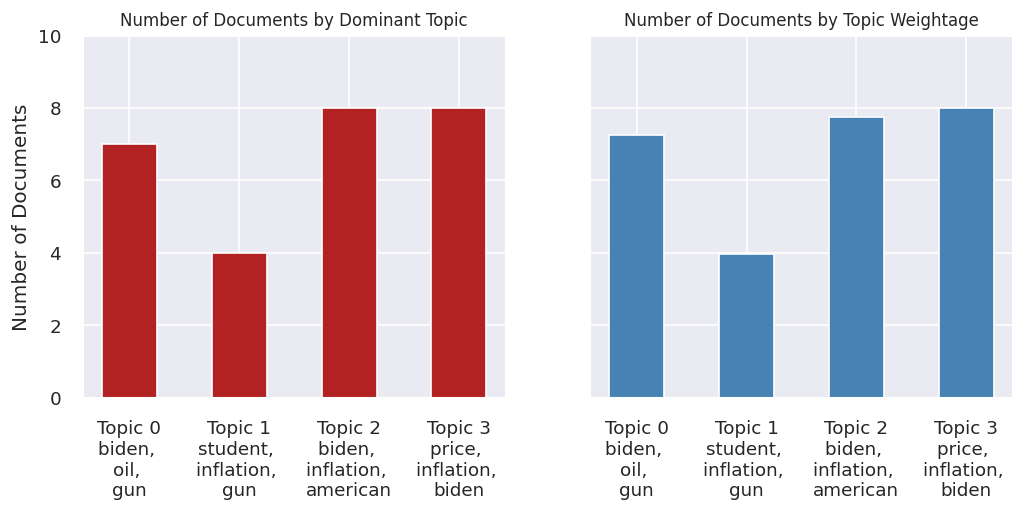

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 10)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

**LDA using TFIDF**


In [ ]:
id2word = corpora.Dictionary(processed_text)


corpus = [id2word.doc2bow(text) for text in processed_text]

In [ ]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [ ]:
#LDA using TFIDF
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
 

ldamodel_tfidf = gensim.models.ldamodel.LdaModel(
    corpus = corpus_tfidf,
    id2word = dictionary,
    num_topics = 3,
    random_state = 100,
    update_every = 1,
    chunksize=100,
    passes=10,
    alpha="auto",
    per_word_topics=True
) 

for idx, topic in ldamodel_tfidf.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

Topic: 0 
Words: 0.002*"student" + 0.001*"forgiveness" + 0.001*"barrel" + 0.001*"oil" + 0.001*"reserve" + 0.001*"borrower" + 0.001*"price" + 0.001*"pentagon" + 0.001*"rfs" + 0.001*"stimulus"
Topic: 1 
Words: 0.001*"fed" + 0.001*"solar" + 0.001*"rate" + 0.001*"recession" + 0.001*"job" + 0.001*"interest" + 0.001*"household" + 0.001*"inflation" + 0.001*"investor" + 0.001*"economist"
Topic: 2 
Words: 0.002*"gun" + 0.001*"weapon" + 0.001*"defense" + 0.001*"us" + 0.001*"russian" + 0.001*"leader" + 0.001*"world" + 0.001*"investment" + 0.001*"sanction" + 0.001*"rescue"


In [ ]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel_tfidf.log_perplexity(corpus_tfidf))  # a measure of how good the model is. lower the better.

from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel_tfidf, texts=processed_text,dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.457682699734836


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for


Coherence Score:  0.4612366118302149


In [ ]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(ldamodel_tfidf, corpus_tfidf, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.003951 -0.000943       1        1  47.580524
0      0.003190 -0.001829       2        1  33.961733
1      0.000760  0.002772       3        1  18.457743, topic_info=             Term      Freq     Total Category  logprob  loglift
820       student  0.000000  0.000000  Default  30.0000  30.0000
765   forgiveness  0.000000  0.000000  Default  29.0000  29.0000
973           fed  0.000000  0.000000  Default  28.0000  28.0000
580          rate  0.000000  0.000000  Default  27.0000  27.0000
1355       barrel  0.000000  0.000000  Default  26.0000  26.0000
...           ...       ...       ...      ...      ...      ...
42         energy  0.039430  0.215892   Topic3  -7.2785  -0.0106
94          point  0.038118  0.194462   Topic3  -7.3123   0.0601
100         price  0.037682  0.248174   Topic3  -7.3238  -0.1953
57            gas  0.035578  0.175155   Topic3  -7.3813   0.0957
584     renewable  0.035266  0.153656   Topic3  -7.3901   0.2179

[158 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

Text(0.5, 1.0, 'Topic 0')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 1')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 2')

(-0.5, 2499.5, 1799.5, -0.5)

(-0.5, 2499.5, 1799.5, -0.5)

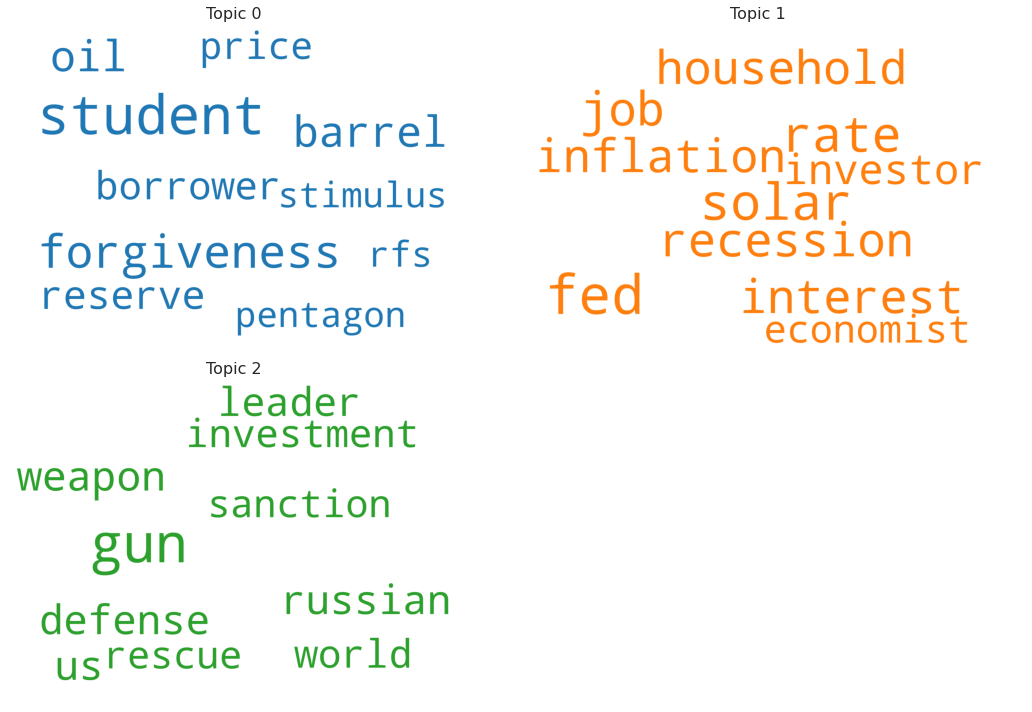

In [ ]:
# Wordcloud of Top N words in each topic
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodel_tfidf.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(15,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    if i < len(topics):
          topic_words = dict(topics[i][1])
          cloud.generate_from_frequencies(topic_words, max_font_size=300)
          plt.gca().imshow(cloud)
          plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
          plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
#plt.title("wordcloud of Top N words - LDA Topic Model with TFIDF", loc='best')
plt.show()

In [ ]:
dominant_topics, topic_percentages = topics_per_document(model=ldamodel_tfidf, corpus=corpus, end=-1)            

df_dominant_topic_in_each_doc = dominant_topic_per_doc(dominant_topics)
df_topic_weightage_by_doc = topic_weightage_per_doc(topic_percentages)
df_top3words = topNwords_per_topic(ldamodel_tfidf)

<BarContainer object of 3 artists>

Text(0.5, 1.0, 'Number of Documents by Dominant Topic')

Text(0, 0.5, 'Number of Documents')

(0.0, 20.0)

<BarContainer object of 3 artists>

Text(0.5, 1.0, 'Number of Documents by Topic Weightage')

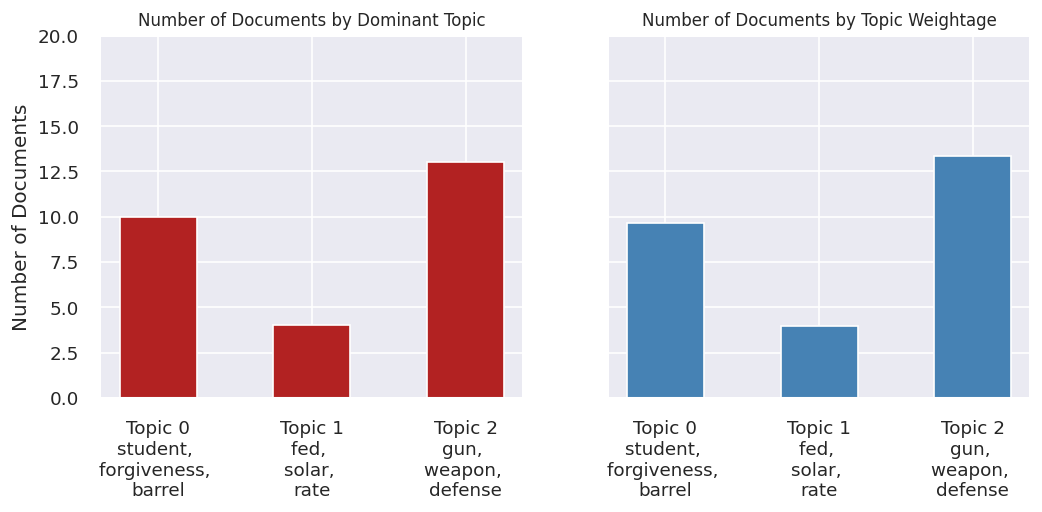

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 20)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

# **Experiment 5**
Bert Embedding

In [ ]:
distillbert_model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings_distillbert = distillbert_model.encode(final_processed_text_replaced_with_eq_class, show_progress_bar=True)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
###############################################################################
### K Means Clustering - BERT Embedding Matrix 
###############################################################################
k=6
km = KMeans(n_clusters=k, random_state =89)
km.fit(embeddings_distillbert)
clusters = km.labels_.tolist()

Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text_replaced_with_eq_class}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]


#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

#dictionary to store terms and titles
cluster_terms={}
cluster_title={}


for i in range(k):
    print("Cluster %d:" % i),
    temp_titles=[]    
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles

KMeans(n_clusters=6, random_state=89)

Top terms per cluster:
Cluster 0:


(None,)

Cluster 0 titles: KN_Doc1_Biden-urges-G7.docx, PSJ_doc1_President_Biden_announced.docx, PSJ_doc2_The_worlds_wealthiest.docx, SS_Doc1_Mission_Not_Yet.docx,Cluster 1:


(None,)

Cluster 1 titles: DT_Doc1_Biden_Administration_Renewable.docx, DT_Doc2_Biden_More_Rewable.docx, JAS_D0c1_Student_Loan_Forgiveness.docx, JAS_Doc2_Inflation-complicates_Biden.docx, JJ_Doc2_Why_Is_Inflation.docx,Cluster 2:


(None,)

Cluster 2 titles: MRD_Doc1_Civil-Society-Groups.docx, MRD_Doc2_Not-Even-Halfway.docx, SS_Doc2_inflation_impacts_Student-Loan-Forgiveness.docx,Cluster 3:


(None,)

Cluster 3 titles: JS_DOC_1_lives_will_be_saved.docx, JS_DOC_2_Biden_signs_gun_control.docx, TSS_Doc1_Biden-Gun-Control.docx, TSS_Doc2_Biden-Remarks-Gun-Violence.docx,Cluster 4:


(None,)

Cluster 4 titles: BAC_Doc1_Biden-Rescue-Plan.docx, CMP_Doc1_Consumer_Price_Index.docx, CMP_Doc2_Voters_have_made.docx, MCD_Doc1_Biden-Oil-Reserve .docx, MCD_Doc2_More-Biden-Oil.docx, MCD_Doc3_Even-More-Biden-Oil.docx, SS_Doc1_job_growth_double-edged_sword.docx, SS_Doc2_A_New_Task.docx, Sieminski_Doc2_Recession.docx, Sieminski_Doc1_Inflation.docx,Cluster 5:


(None,)

Cluster 5 titles: BAC_Doc2_Biden-worsened -Inflation.docx, JJ_Doc1_Consumers-Are-Feeling.docx,

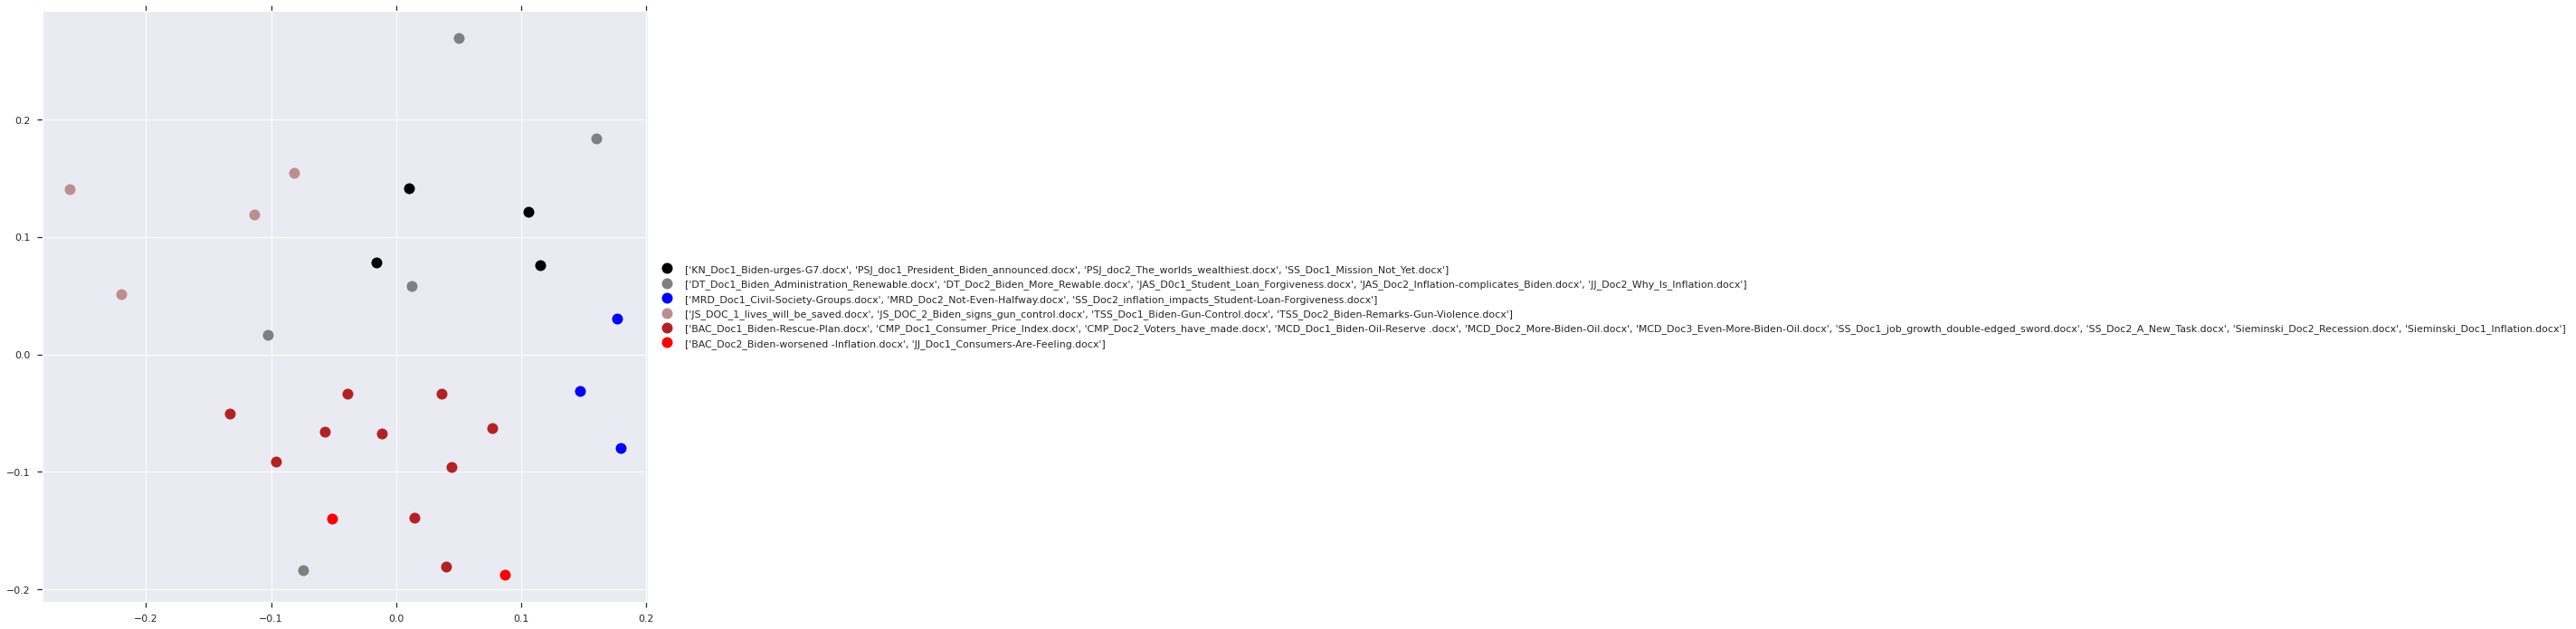

In [ ]:
###############################################################################
### Plotting
###############################################################################

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.

X=embeddings_distillbert
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(X)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                  5:'red', 6:'darksalmon', 7:'sienna', 8:'green'}


#set up cluster names using a dict.  
cluster_dict=cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

**Review Clusters**

In [ ]:
Clusters_bert = pd.DataFrame.from_dict(cluster_title, orient='index') #convert tiles to a dataframe
Clusters_bert = Clusters_bert.stack() #stack document names into 1 column
Clusters_bert = Clusters_bert.reset_index() #move index into a column
Clusters_bert = Clusters_bert.rename(columns={'level_0': 'cluster_doc', 0:'document'}) #rename columns
Clusters_bert = Clusters_bert.drop(['level_1'], axis=1) #drop unecessary column
Clusters_bert.value_counts(sort=False)

cluster_doc  document                                               
0            KN_Doc1_Biden-urges-G7.docx                                1
             PSJ_doc1_President_Biden_announced.docx                    1
             PSJ_doc2_The_worlds_wealthiest.docx                        1
             SS_Doc1_Mission_Not_Yet.docx                               1
1            DT_Doc1_Biden_Administration_Renewable.docx                1
             DT_Doc2_Biden_More_Rewable.docx                            1
             JAS_D0c1_Student_Loan_Forgiveness.docx                     1
             JAS_Doc2_Inflation-complicates_Biden.docx                  1
             JJ_Doc2_Why_Is_Inflation.docx                              1
2            MRD_Doc1_Civil-Society-Groups.docx                         1
             MRD_Doc2_Not-Even-Halfway.docx                             1
             SS_Doc2_inflation_impacts_Student-Loan-Forgiveness.docx    1
3            JS_DOC_1_lives_will_be_saved.d

# Experiment 6
Topic Modeling using DistillBert embedding

In [ ]:
roberta_model = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')
embeddings_roberta_mat = roberta_model.encode(final_processed_text_replaced_with_eq_class, show_progress_bar=True)

distillbert_model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings_distillbert = distillbert_model.encode(final_processed_text_replaced_with_eq_class, show_progress_bar=True)

bert_model = SentenceTransformer('bert-base-nli-mean-tokens')
embeddings_bert_mat = bert_model.encode(final_processed_text_replaced_with_eq_class, show_progress_bar=True)

Downloading:   0%|          | 0.00/748 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.00k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/688 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/334 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#umap - Dimension reduction
umap_embeddings = umap.UMAP(n_components=5, 
                            metric='cosine', random_state=42).fit_transform(embeddings_roberta_mat)

In [ ]:
#HDBSCAN - Clustering
min_clusters = 3
cluster = hdbscan.HDBSCAN(min_cluster_size= min_clusters, metric='euclidean', cluster_selection_method='eom').fit(umap_embeddings)

In [ ]:
cluster.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1])

In [ ]:
# Visualize clusters
#Prepare data
umap_data = umap.UMAP(n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings_roberta_mat)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_


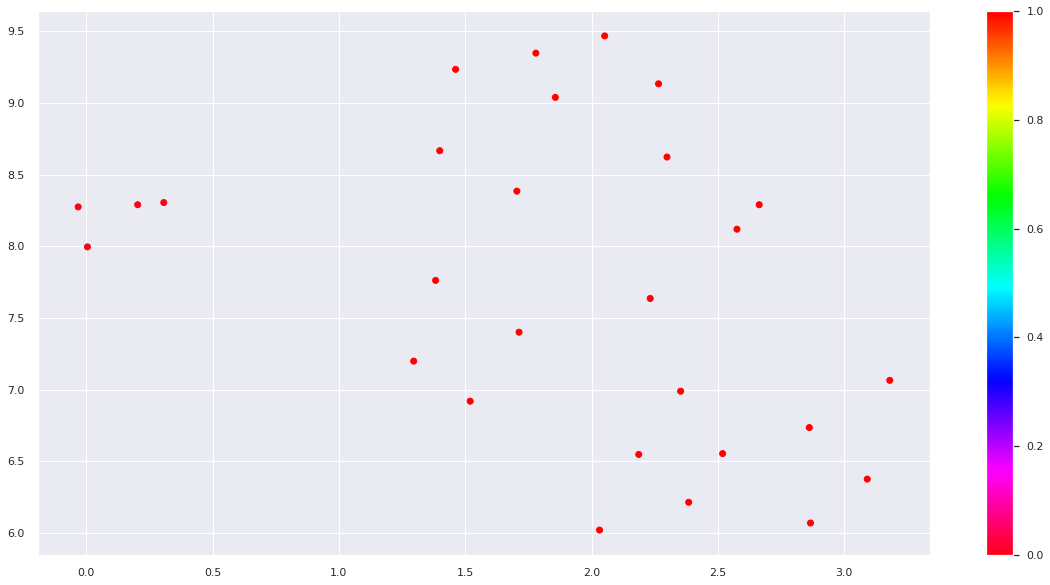

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD')
plt.scatter(clustered.x, clustered.y, c=clustered.labels, cmap='hsv_r')
plt.colorbar()

In [ ]:
Dictionary={'Doc_Name':titles, 'Topic':cluster.labels_ ,  'Text': final_processed_text}
docs_df=pd.DataFrame(Dictionary, columns=['Topic', 'Doc_Name','Text'])

In [ ]:
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Text': ' '.join})

In [ ]:
docs_df.groupby(['Topic','Doc_Name']).count()

Text
Topic Doc_Name                                                
0     JS_DOC_1_lives_will_be_saved.docx                      1
      JS_DOC_2_Biden_signs_gun_control.docx                  1
      TSS_Doc1_Biden-Gun-Control.docx                        1
      TSS_Doc2_Biden-Remarks-Gun-Violence.docx               1
1     BAC_Doc1_Biden-Rescue-Plan.docx                        1
      BAC_Doc2_Biden-worsened -Inflation.docx                1
      CMP_Doc1_Consumer_Price_Index.docx                     1
      CMP_Doc2_Voters_have_made.docx                         1
      DT_Doc1_Biden_Administration_Renewable.docx            1
      DT_Doc2_Biden_More_Rewable.docx                        1
      JAS_D0c1_Student_Loan_Forgiveness.docx                 1
      JAS_Doc2_Inflation-complicates_Biden.docx              1
      JJ_Doc1_Consumers-Are-Feeling.docx                     1
      JJ_Doc2_Why_Is_Inflation.docx                          1
      KN_Doc1_Biden-urges-G7.docx                            1
      MCD_Doc1_Biden-Oil-Reserve .docx                       1
      MCD_Doc2_More-Biden-Oil.docx                           1
      MCD_Doc3_Even-More-Biden-Oil.docx                      1
      MRD_Doc1_Civil-Society-Groups.docx                     1
      MRD_Doc2_Not-Even-Halfway.docx                         1
      PSJ_doc1_President_Biden_announced.docx                1
      PSJ_doc2_The_worlds_wealthiest.docx                    1
      SS_Doc1_Mission_Not_Yet.docx                           1
      SS_Doc1_job_growth_double-edged_sword.docx             1
      SS_Doc2_A_New_Task.docx                                1
      SS_Doc2_inflation_impacts_Student-Loan-Forgiven...     1
      Sieminski_Doc1_Inflation.docx                          1
      Sieminski_Doc2_Recession.docx                          1

In [ ]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [ ]:
tf_idf, count = c_tf_idf(docs_per_topic.Text.values, m=len(data))

In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

In [ ]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
top_n_words

{0: [('school', 0.008173291257754376),
  ('background', 0.008173291257754376),
  ('owner', 0.0078006917426360406),
  ('shooting', 0.0078006917426360406),
  ('magazine', 0.0078006917426360406),
  ('uvalde', 0.0078006917426360406),
  ('law', 0.0075105244162124865),
  ('red', 0.007449015076069472),
  ('mental', 0.007429799232864064),
  ('killed', 0.007429799232864064),
  ('buffalo', 0.007429799232864064),
  ('injured', 0.007429799232864064),
  ('signed', 0.007429799232864064),
  ('place', 0.007049309308253679),
  ('bipartisan', 0.007049309308253679),
  ('violence', 0.007024244635869706),
  ('rifle', 0.006924303045583213),
  ('teacher', 0.006924303045583213),
  ('victim', 0.006924303045583213),
  ('firearm', 0.006924303045583213)],
 1: [('continue', 0.0017906424646628837),
  ('economist', 0.0017906424646628837),
  ('invasion', 0.0017906424646628837),
  ('unemployment', 0.0017906424646628837),
  ('china', 0.0017906424646628837),
  ('percent', 0.0017906424646628837),
  ('ally', 0.00179064246

Text(0.5, 1.0, 'Topic 0')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 1')

(-0.5, 2499.5, 1799.5, -0.5)

(-0.5, 2499.5, 1799.5, -0.5)

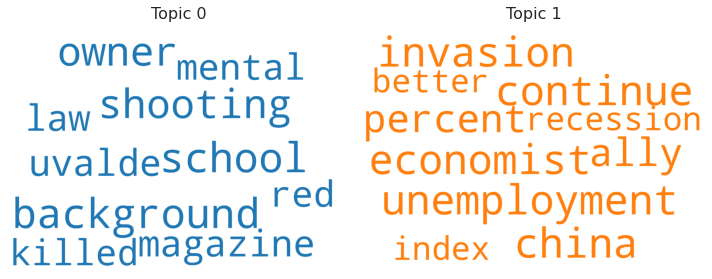

In [ ]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] 

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = top_n_words

fig, axes = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    if i < len(topics):
      topic_words = dict(topics[i][:10])
      cloud.generate_from_frequencies(topic_words, max_font_size=300)
      plt.gca().imshow(cloud)
      # if i == 0:
      #     plt.gca().set_title('Topic ' + str(i) + '(Outlier)', fontdict=dict(size=16))
      # else:
      plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
      plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                      .Doc_Name	
                      .count()
                      .reset_index()
                      .rename({"Topic": "Topic", "Doc_Name": "Size"}, axis='columns')
                      .sort_values("Size", ascending=False))
    return topic_sizes

topic_sizes = extract_topic_sizes(docs_df); 
topic_sizes

Topic  Size
1      1    24
0      0     4

# Experiment 7
BERTopic Model

In [ ]:
topic_model = BERTopic(min_topic_size=3, n_gram_range=(1,3), verbose=True)
topics, _ = topic_model.fit_transform(final_processed_text_replaced_with_eq_class)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-09-01 00:28:17,995 - BERTopic - Transformed documents to Embeddings
2022-09-01 00:28:21,212 - BERTopic - Reduced dimensionality
2022-09-01 00:28:21,229 - BERTopic - Clustered reduced embeddings


In [ ]:
freq = topic_model.get_topic_info()
freq.head(10)

Topic  Count                                 Name
0     -1      1  -1_defense_defense budget_budget_us
1      0     13       0_inflation_biden_student_loan
2      1     10             1_biden_energy_oil_price
3      2      4           2_gun_weapon_biden_assault

In [ ]:
dict_cols={'Doc_Name':titles, 'Topic':topics ,  'Text': final_processed_text_replaced_with_eq_class}
berttopic_df=pd.DataFrame(dict_cols, columns=['Topic', 'Doc_Name','Text'])

In [ ]:
berttopic_df.groupby(['Topic','Doc_Name']).count()

Text
Topic Doc_Name                                                
-1    MRD_Doc2_Not-Even-Halfway.docx                         1
 0    BAC_Doc1_Biden-Rescue-Plan.docx                        1
      BAC_Doc2_Biden-worsened -Inflation.docx                1
      CMP_Doc1_Consumer_Price_Index.docx                     1
      CMP_Doc2_Voters_have_made.docx                         1
      JAS_D0c1_Student_Loan_Forgiveness.docx                 1
      JAS_Doc2_Inflation-complicates_Biden.docx              1
      JJ_Doc1_Consumers-Are-Feeling.docx                     1
      JJ_Doc2_Why_Is_Inflation.docx                          1
      MRD_Doc1_Civil-Society-Groups.docx                     1
      SS_Doc1_job_growth_double-edged_sword.docx             1
      SS_Doc2_inflation_impacts_Student-Loan-Forgiven...     1
      Sieminski_Doc1_Inflation.docx                          1
      Sieminski_Doc2_Recession.docx                          1
 1    DT_Doc1_Biden_Administration_Renewable.docx            1
      DT_Doc2_Biden_More_Rewable.docx                        1
      KN_Doc1_Biden-urges-G7.docx                            1
      MCD_Doc1_Biden-Oil-Reserve .docx                       1
      MCD_Doc2_More-Biden-Oil.docx                           1
      MCD_Doc3_Even-More-Biden-Oil.docx                      1
      PSJ_doc1_President_Biden_announced.docx                1
      PSJ_doc2_The_worlds_wealthiest.docx                    1
      SS_Doc1_Mission_Not_Yet.docx                           1
      SS_Doc2_A_New_Task.docx                                1
 2    JS_DOC_1_lives_will_be_saved.docx                      1
      JS_DOC_2_Biden_signs_gun_control.docx                  1
      TSS_Doc1_Biden-Gun-Control.docx                        1
      TSS_Doc2_Biden-Remarks-Gun-Violence.docx               1

In [ ]:
#https://github.com/MaartenGr/BERTopic/issues/97
topic_model.visualize_hierarchy()

/usr/local/lib/python3.7/dist-packages/plotly/figure_factory/_dendrogram.py:350: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  icoord = scp.array(P["icoord"])
/usr/local/lib/python3.7/dist-packages/plotly/figure_factory/_dendrogram.py:351: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  dcoord = scp.array(P["dcoord"])
/usr/local/lib/python3.7/dist-packages/plotly/figure_factory/_dendrogram.py:352: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  ordered_labels = scp.array(P["ivl"])
/usr/local/lib/python3.7/dist-packages/plotly/figure_factory/_dendrogram.py:353: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  color_list = scp.array(P["color_list"])


In [ ]:
topic_model.visualize_barchart()